<h1> DYNAMIC MALWARE CLASSIFICATION</h1>

Supervised, classification, multi-class

# 0. Basic Set-Up and General info

Note: there are a lot of non-used imports (to be removed at the end)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy import stats

from scipy.stats import loguniform

from skopt.space import Real

import copy
import yaml

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier


In [6]:
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy

In [7]:
from library.utils.ownModels.majorityClassModel import MajorityClassClassifier # Importing self-developed model object
from library.utils.ownModels.neuralNets.feedForward import FeedForwardNeuralNetwork

In [14]:
import importlib

# Import your modules initially
import library.pipeline

# Reload the modules in case they were updated
importlib.reload(library.pipeline)

# Now you can import specific classes/functions
from library.pipeline.pipeline import Pipeline
from library.pipeline.pipeline_manager import PipelineManager

## Documentation Standarization
Follow the following guidelines to make sure our document is consistent and easier to undestand
- All constant should be writte in full capitall letters (e.g: MY_CONSTANT). Notebook-level constants should be written in the cell assigned to it (see below)
- Every new major section (EDA, Feature engineering) should be written with '# My title'#
- Subsequent sections should use '##', '###' or '####' hierarchacically
- At the beginning of each major section write a content index with the content included in that section (see 'feature engineering' section as an example)
- Please write paragraphs before and after each cell explain what u are about to do and the conclusions, correspondingly. Do not assume they are too obvious.
- Avoid excessive ChatGPT-originated comments
- Avoid writing more than 20 lines per code cell (exceptions for subroutines, which should be written in utilitied_functions.py)
- Ideally, add a "Questions" and "Things to be done" section in each major sections where u write about futher iterations u want to do (while sharing in with the rest)


## Set-up

In [11]:
import yaml

In [12]:
variables = yaml.load(open("library/configurations.yaml"), Loader=yaml.FullLoader)


We start off with a pipeline for all the models. Then at some moment, whenever we think the pipelines will diverge, we remove the by-object-refrence (that we will create in the next cell), and create a new copy with our modifications ready.

## Pipeline Selection
We will having pipelines for:
- ensembled_models (random forest, gradient boosting)
- tree-based (decision trees)
- support vectors machines (non-linear*)
- naive bayes (gaussian naive bayes)
- stacking (stacking models)


* We originally conceived to add linear for the sake of model diversity. While the theory already pointed us out that the linear SVM wont be able to find the separating hyperplane (i.e., model is able to fit), we wanted to see if by setting

In [15]:
default_pipeline = ensembled_pipeline = tree_pipeline = supportVectorsMachine_pipeline = baseline_pipeline = naiveBayes_pipeline = stacking_pipeline = feedForwardNN_pipeline = example = Pipeline(
                        dataset_path=variables["PIPELINE_RUNNER"]["dataset_path"], 
                        model_results_path="results/model_evaluation/results.csv",
                        model_task="classification")

In [16]:
pipelines = {
            "not_baseline": {
                  "ensembled": ensembled_pipeline,
                  "tree_based": tree_pipeline,
                  "support_vector_machine": supportVectorsMachine_pipeline,
                  "naive_bayes": naiveBayes_pipeline,
                  "feed_forward_neural_network": feedForwardNN_pipeline,
                  "stacking": stacking_pipeline,
                  }, 
            "baseline": {
                  "baselines": baseline_pipeline, 
                  "example":  example               
            }
}
pipeline_manager = PipelineManager(pipelines)

Here I show an example of how we will be working with by-object-reference.

In [17]:
baseline_pipeline.dataset.example_attribute = "1"

In [18]:
default_pipeline.dataset.example_attribute

'1'

However, if we do a (deep) copy:
Note that the difference between a deep and a shallow copy is that the former copies all the objects that are inside the class. We need that.
We will overwrite the prior attribute and show is this is not propagated to the other results anymore

In [19]:
import copy

In [20]:
new_pipeline = copy.deepcopy(default_pipeline)
new_pipeline.dataset.example_attribute = "2"

In [21]:
default_pipeline.dataset.example_attribute

'1'

It may also be of interest for you to propagate the same method's invokation to all the pipelines within the pipeline manager. For instance, after a divergence in, lets say, feature scaling, you may need to fit all the models in the corresponding pipelines. You would want to avoid reduntandly calling the same method with the same parameters for all the Pipeline class instances. In order to do so, we present an example that avoids such annoyance

In [22]:
pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="example", print_results=True)

Pipeline example in category baseline has diverged
 Pipeline schema is now: {'not_baseline': {'ensembled': <library.pipeline.pipeline.Pipeline object at 0x000002050CDEAE70>, 'tree_based': <library.pipeline.pipeline.Pipeline object at 0x000002050CDEAE70>, 'support_vector_machine': <library.pipeline.pipeline.Pipeline object at 0x000002050CDEAE70>, 'naive_bayes': <library.pipeline.pipeline.Pipeline object at 0x000002050CDEAE70>, 'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline object at 0x000002050CDEAE70>, 'stacking': <library.pipeline.pipeline.Pipeline object at 0x000002050CDEAE70>}, 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline object at 0x000002050CDEAE70>, 'example': <library.pipeline.pipeline.Pipeline object at 0x00000205042A1FD0>}}


In [23]:
pipeline_manager.pipelines["baseline"]["example"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd")

Whats goooddd from 2220718772912. You are at automatic feature selection!


In [24]:
pipeline_manager.all_pipelines_execute(methodName="speak", message="Hello, world!")

Hello, world! from 2220714012272
Hello, world! from 2220567961552


{'not_baseline': {'ensembled': None}, 'baseline': {'example': None}}

A method present deeper down the class:

Instead of doing:
'pipeline_manager.pipelines["baseline"]["logistic"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd") for all objects'

we can do:

In [25]:
pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_selection.automatic_feature_selection.speak", message="Whats good")

Whats good from 2220699267440. You are at automatic feature selection!
Whats good from 2220718772912. You are at automatic feature selection!


{'not_baseline': {'ensembled': None}, 'baseline': {'example': None}}

In [26]:
# lets delete the example obj
del new_pipeline 
del pipeline_manager.pipelines["baseline"]["example"]

In [27]:
pipeline_manager.pipelines

{'not_baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>,
  'tree_based': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>,
  'support_vector_machine': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>,
  'naive_bayes': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>,
  'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>,
  'stacking': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>},
 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>}}

<hr>

# Start Of The Pipeline

In [28]:
default_pipeline.dataset.df.head()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  Memory_PrivateDirty  \
0            31053             2448               14044                23472   
1           107787            21976               11852                74548   
2            86584            18460               12284                59992   
3            41248              924               10328                36280   
4            38621             5080               12392                27388   

   Memory_SharedClean  Memory_PrivateClean  Memory_SwapPssDirty  \
0               74824                 2452                    0   
1               69052                23152                    0   
2               91548                19376                    0   
3               55768                  928                    0   
4               71048                 5088                    0   

   Memory_HeapSize  Memory_HeapAlloc  Memory_HeapFree  ...  Logcat_error  \
0             8919              4786             4132  ...          1635   
1            25341             20965             4375  ...          1816   
2            24500             21378             3121  ...          2244   
3            10082              7281             2800  ...           974   
4             9077              5750             3326  ...           936   

   Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  Process_total  \
0            2351          3285            1551         11221            193   
1             826          1544            2045          8457            189   
2            3406          1565            2819         10780            195   
3            4134          3138            1556         11739            191   
4            2298          3752            1992         10488            188   

                                                Hash    Category    Family  \
0  f460abb8f2e4e3fb689966ddaea6d6babbd1738bb691c7...  Trojan_SMS    opfake   
1  556c238536d837007e647543eaf3ea95ae9aaf1c1a52d0...  Trojan_SMS    opfake   
2  398322f94b5bfa2a9e7b3756a4cf409764595003280c48...  Trojan_SMS  fakeinst   
3  4a9c14872b2c66165599a969a1a8654bb6887d7a18ab6d...  Trojan_SMS  fakeinst   
4  6b37b9b9c170727f706b69731e64da4bbca2638b4237a7...  Trojan_SMS  fakeinst   

   Reboot  
0  before  
1  before  
2  before  
3  before  
4  before  

[5 rows x 145 columns]

In [29]:
for col in default_pipeline.dataset.df.columns.to_list():
    print(col)

Memory_PssTotal
Memory_PssClean
Memory_SharedDirty
Memory_PrivateDirty
Memory_SharedClean
Memory_PrivateClean
Memory_SwapPssDirty
Memory_HeapSize
Memory_HeapAlloc
Memory_HeapFree
Memory_Views
Memory_ViewRootImpl
Memory_AppContexts
Memory_Activities
Memory_Assets
Memory_AssetManagers
Memory_LocalBinders
Memory_ProxyBinders
Memory_ParcelMemory
Memory_ParcelCount
Memory_DeathRecipients
Memory_OpenSSLSockets
Memory_WebViews
API_Process_android.os.Process_start
API_Process_android.app.ActivityManager_killBackgroundProcesses
API_Process_android.os.Process_killProcess
API_Command_java.lang.Runtime_exec
API_Command_java.lang.ProcessBuilder_start
API_JavaNativeInterface_java.lang.Runtime_loadLibrary
API_JavaNativeInterface_java.lang.Runtime_load
API_WebView_android.webkit.WebView_loadUrl
API_WebView_android.webkit.WebView_loadData
API_WebView_android.webkit.WebView_loadDataWithBaseURL
API_WebView_android.webkit.WebView_addJavascriptInterface
API_WebView_android.webkit.WebView_evaluateJavascript

In [30]:
default_pipeline.dataset.df["Category"].value_counts()

Category
Riskware          14053
Adware            10980
Trojan             8437
Zero_Day           4475
Ransomware         3411
Trojan_Spy         2840
Trojan_SMS         1939
No_Category        1932
Trojan_Dropper     1570
PUA                1290
Backdoor           1137
Scareware           886
FileInfector        248
Trojan_Banker       241
Name: count, dtype: int64

In [31]:
default_pipeline.dataset.df.rename(columns={"reboot": "Reboot"}, inplace=True) # consistency with other features' names
default_pipeline.dataset.df.drop(columns=["Family", "Hash"], inplace=True) # We have decided to use only category as target variable; Hash is temporary while im debugging (it will be deleted in EDA)

We also have to delete all the records with categories zero day and no category"

In [32]:
default_pipeline.dataset.df.shape[0]

53439

In [33]:
default_pipeline.dataset.df.drop(default_pipeline.dataset.df[default_pipeline.dataset.df["Category"] == "Zero_Day"].index, inplace=True)
default_pipeline.dataset.df.drop(default_pipeline.dataset.df[default_pipeline.dataset.df["Category"] == "No_Category"].index, inplace=True)
default_pipeline.dataset.df["Category"].value_counts()


Category
Riskware          14053
Adware            10980
Trojan             8437
Ransomware         3411
Trojan_Spy         2840
Trojan_SMS         1939
Trojan_Dropper     1570
PUA                1290
Backdoor           1137
Scareware           886
FileInfector        248
Trojan_Banker       241
Name: count, dtype: int64

In [34]:
default_pipeline.dataset.df.shape[0]

47032

### Description of our features

For each of our entries in the dataset we have a feature describing the state of the (operating) system under which the malware was running. Here is an intial description for each of them.
Please access this document for a complete problem context description: https://docs.google.com/document/d/1yH9gvnJVSH9GLv9ATQ5JQWA2z8Jy4umxxRfMF-y2fiU/edit?usp=sharing

This section below shall be deleted

In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


### SUGGESTIONS FOR IMPROVEMENTS
- Cluster analysis

<hr>

# 2. DATA SPLITTING
### TO BE DONE
- Statistical analysis of this
- Make sure they follow the same distributions

### Data Splitting: Category as target variable
Originally, we will focus only on category

Lets first get the X and y extracted from our dataset

Also object!
Lets get back to the splitting!

Before, we split the dataset lets observe the SE of accuracy variation based on our choice of split. 
Brief explanation: we can model accuracy via a Binomial distribution. We know each event in a binomial distribution can be modelled through a bernoulli distribution, where the outcome represents the probability predicting the correct class or not. We make the assumption that each classification error is independent from each other. For:
$$
\text{Bin} \sim (n, p)
$$
 let us assume that the parameter of this distribution is p = .85 and n is given by the choice of sample split for the test set. The SE of the sample proportion can be modeled via: 
$$
\text{SE}_{\hat{p}} = \sqrt{\frac{p(1 - p)}{n}}

$$

Before we continue to assess all possible choices of split based on a variant n, also note that that choice of evenly distributed split (e.g: 10% for each hold-out set) between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.

Finally, also note that that choice of evenly distributed split between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.


In [35]:
default_pipeline.dataset.split.asses_split_classifier(p=.85,
                                                      step=.05, 
                                                      save_plots=False,
                                                      save_path=None)

c:\Users\irina\ml-final-project\library\phases\phases_implementation\dataset\split\strategies\noTimeSeries.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  differenceToPriorSE_percentage = (currentSE - priorSE) /  priorSE


train_size (%)  train_size_count  validation_size (%)  \
0            0.95           44680.0                0.025   
1            0.90           42329.0                0.050   
2            0.85           39977.0                0.075   
3            0.80           37626.0                0.100   
4            0.75           35274.0                0.125   
5            0.70           32922.0                0.150   
6            0.65           30571.0                0.175   
7            0.60           28219.0                0.200   
8            0.55           25868.0                0.225   
9            0.50           23516.0                0.250   

   validation_size_count  test_size (%)  test_size_coount  currentSE  \
0                 1176.0          0.025            1176.0   0.010412   
1                 2352.0          0.050            2352.0   0.007363   
2                 3527.0          0.075            3527.0   0.006012   
3                 4703.0          0.100            4703.0   0.005207   
4                 5879.0          0.125            5879.0   0.004657   
5                 7055.0          0.150            7055.0   0.004251   
6                 8231.0          0.175            8231.0   0.003936   
7                 9406.0          0.200            9406.0   0.003682   
8                10582.0          0.225           10582.0   0.003471   
9                11758.0          0.250           11758.0   0.003293   

   differenceToPriorSE  differenceToPriorSE (%)  
0             0.010412                      inf  
1            -0.003050                -0.292893  
2            -0.001350                -0.183388  
3            -0.000806                -0.134005  
4            -0.000550                -0.105592  
5            -0.000406                -0.087142  
6            -0.000315                -0.074189  
7            -0.000254                -0.064543  
8            -0.000211                -0.057202  
9            -0.000178                -0.051326

[We can see a diminishing-returns class graph](https://en.wikipedia.org/wiki/Knee_of_a_curve). The more we decline the training set percentage the slower and more steadier the current SE varies as well as the difference to prior SE, in percentage. We can see that the knee in the curve is between 80 and 90 training set percentage. This represents the area where when you start going below the lower bound, no **significant** improve appears. Given the fact that our criteria for choice of split percentage is to keep as much training possible while increasing hold-out sets size only if the decrease in SE is significant **we are going to select 80% for the training set**.

In [36]:
default_pipeline.dataset.split.split_data(y_column="Category",
                                   train_size=.8, 
                                   validation_size=.1,
                                   test_size=.1, 
                                   save_plots=False,
                                   save_path=None)

X_train: (37625, 142)
X_val: (4703, 142)
X_test: (4704, 142)
y_train: (37625,)
y_val: (4703,)
y_test: (4704,)


{'Memory_PssTotal': {6520: 43041,
  2425: 125178,
  44969: 43428,
  50354: 34651,
  21242: 80981},
 'Memory_PssClean': {6520: 6544,
  2425: 31456,
  44969: 2288,
  50354: 804,
  21242: 32356},
 'Memory_SharedDirty': {6520: 12304,
  2425: 12704,
  44969: 10748,
  50354: 11008,
  21242: 10760},
 'Memory_PrivateDirty': {6520: 28616,
  2425: 84372,
  44969: 32624,
  50354: 29224,
  21242: 37032},
 'Memory_SharedClean': {6520: 93928,
  2425: 85144,
  44969: 84988,
  50354: 73772,
  21242: 92240},
 'Memory_PrivateClean': {6520: 6556,
  2425: 32908,
  44969: 4792,
  50354: 812,
  21242: 33756},
 'Memory_SwapPssDirty': {6520: 0, 2425: 0, 44969: 0, 50354: 0, 21242: 0},
 'Memory_HeapSize': {6520: 14237,
  2425: 36882,
  44969: 19668,
  50354: 8070,
  21242: 10749},
 'Memory_HeapAlloc': {6520: 12368,
  2425: 29212,
  44969: 16381,
  50354: 6645,
  21242: 9088},
 'Memory_HeapFree': {6520: 1868,
  2425: 7669,
  44969: 3286,
  50354: 1424,
  21242: 1660},
 'Memory_Views': {6520: 7, 2425: 62, 44969: 

In [37]:
default_pipeline.dataset.X_train.shape, default_pipeline.dataset.X_val.shape, default_pipeline.dataset.X_test.shape, default_pipeline.dataset.y_train.shape, default_pipeline.dataset.y_val.shape, default_pipeline.dataset.y_test.shape

((37625, 142), (4703, 142), (4704, 142), (37625,), (4703,), (4704,))

<hr>

<hr>

# 4. FEATURE ANALYSIS

Here we will take adjust the features that compose the learning inputs to our model. The correctness of this section is pivotal for proper learning by the model


## FEATURE ENGINEERING
- Domain-specific features
- Binning
- Interaction terms


In [38]:
featuresToEncode = ["Reboot"]

In [39]:
encoded_maps_perPipeline = pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_transformation.get_categorical_features_encoded", verbose=True, features=featuresToEncode, encode_y=True)
encoded_maps_perPipeline

Pipeline ensembled in category not_baseline has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'PUA': 3, 'Ransomware': 4, 'Riskware': 5, 'Scareware': 6, 'Trojan': 7, 'Trojan_Banker': 8, 'Trojan_Dropper': 9, 'Trojan_SMS': 10, 'Trojan_Spy': 11}


{'not_baseline': {'ensembled': {'Adware': 0,
   'Backdoor': 1,
   'FileInfector': 2,
   'PUA': 3,
   'Ransomware': 4,
   'Riskware': 5,
   'Scareware': 6,
   'Trojan': 7,
   'Trojan_Banker': 8,
   'Trojan_Dropper': 9,
   'Trojan_SMS': 10,
   'Trojan_Spy': 11}},
 'baseline': {}}

In [40]:
pipeline_manager.pipelines_analysis.encoded_map = encoded_maps_perPipeline["not_baseline"]["ensembled"] # setting baseline as an arbitrary example (all are the same as for now)

Lets visualize the results of the encoding...

In [41]:
default_pipeline.dataset.X_train

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
6520             43041             6544               12304   
2425            125178            31456               12704   
44969            43428             2288               10748   
50354            34651              804               11008   
21242            80981            32356               10760   
...                ...              ...                 ...   
49104            80448             2476               10352   
42415            44710             5304               11572   
52672            89585             1072               10880   
24471            45050             7588               12352   
35720            62856             3936               10692   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
6520                 28616               93928                 6556   
2425                 84372               85144                32908   
44969                32624               84988                 4792   
50354                29224               73772                  812   
21242                37032               92240                33756   
...                    ...                 ...                  ...   
49104                70328               58332                 4364   
42415                30416               67004                 5320   
52672                82664               84236                 1084   
24471                28748               86512                 7612   
35720                46164               95492                10148   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
6520                     0            14237             12368   
2425                     0            36882             29212   
44969                    0            19668             16381   
50354                    0             8070              6645   
21242                    0            10749              9088   
...                    ...              ...               ...   
49104                    0            36495             29908   
42415                    0             7949              5545   
52672                    0            26521             22153   
24471                    0            13236             10377   
35720                    0            25490             19053   

       Memory_HeapFree  ...  Battery_wakelock  Battery_service  Logcat_info  \
6520              1868  ...                 3                2         3024   
2425              7669  ...                 3                0         1724   
44969             3286  ...                 3                0         1376   
50354             1424  ...                 4                1         1468   
21242             1660  ...                 4                1         1271   
...                ...  ...               ...              ...          ...   
49104             6586  ...                 4                1         1551   
42415             2403  ...                 2                0         3249   
52672             4367  ...                 2                0         1956   
24471             2858  ...                 6                2         1550   
35720             6436  ...                 3                0          119   

       Logcat_error  Logcat_warning  Logcat_debug  Logcat_verbose  \
6520           4730            1510          1127            4815   
2425           2295             752         11157            1514   
44969           649            1478          2121            1709   
50354           466            4828          1355            1511   
21242          4007            3247          1885            4913   
...             ...             ...           ...             ...   
49104          1870             783          2859            2296   
42415          1181            7295          1630            2900   
52672           982            2593          2

In [42]:
default_pipeline.dataset.y_train

6520      0
2425      0
44969     7
50354     1
21242     5
         ..
49104     4
42415    11
52672     3
24471     5
35720     5
Length: 37625, dtype: int64

In [43]:
baseline_pipeline.dataset.X_train

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
6520             43041             6544               12304   
2425            125178            31456               12704   
44969            43428             2288               10748   
50354            34651              804               11008   
21242            80981            32356               10760   
...                ...              ...                 ...   
49104            80448             2476               10352   
42415            44710             5304               11572   
52672            89585             1072               10880   
24471            45050             7588               12352   
35720            62856             3936               10692   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
6520                 28616               93928                 6556   
2425                 84372               85144                32908   
44969                32624               84988                 4792   
50354                29224               73772                  812   
21242                37032               92240                33756   
...                    ...                 ...                  ...   
49104                70328               58332                 4364   
42415                30416               67004                 5320   
52672                82664               84236                 1084   
24471                28748               86512                 7612   
35720                46164               95492                10148   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
6520                     0            14237             12368   
2425                     0            36882             29212   
44969                    0            19668             16381   
50354                    0             8070              6645   
21242                    0            10749              9088   
...                    ...              ...               ...   
49104                    0            36495             29908   
42415                    0             7949              5545   
52672                    0            26521             22153   
24471                    0            13236             10377   
35720                    0            25490             19053   

       Memory_HeapFree  ...  Battery_wakelock  Battery_service  Logcat_info  \
6520              1868  ...                 3                2         3024   
2425              7669  ...                 3                0         1724   
44969             3286  ...                 3                0         1376   
50354             1424  ...                 4                1         1468   
21242             1660  ...                 4                1         1271   
...                ...  ...               ...              ...          ...   
49104             6586  ...                 4                1         1551   
42415             2403  ...                 2                0         3249   
52672             4367  ...                 2                0         1956   
24471             2858  ...                 6                2         1550   
35720             6436  ...                 3                0          119   

       Logcat_error  Logcat_warning  Logcat_debug  Logcat_verbose  \
6520           4730            1510          1127            4815   
2425           2295             752         11157            1514   
44969           649            1478          2121            1709   
50354           466            4828          1355            1511   
21242          4007            3247          1885            4913   
...             ...             ...           ...             ...   
49104          1870             783          2859            2296   
42415          1181            7295          1630            2900   
52672           982            2593          2

In [44]:
baseline_pipeline.dataset.y_train

6520      0
2425      0
44969     7
50354     1
21242     5
         ..
49104     4
42415    11
52672     3
24471     5
35720     5
Length: 37625, dtype: int64

## FEATURE SELECTION
- Analyze correlation and low-variances


## Feature selection 
As explained before, we now proceed to carefully reduce the present high-dimensionality. High-dimensionality increases the chances of the model overfitting (capturing noise from irrelevant features; increasing variance and reducing bias), as well as introducing a significant computational overhead. We match this high-dimensionality with a highly filtering models_pipeline of feature selection.
The most extensive cut comes given at the first level, with the mutual information threshold-based cut. This metric captures the level of uncertainity between the feature and the target variable (cnt). In marked contrast with pearson coefficeint (correlation), it is able to model non-linear and linea relationships altoghther. 
This feature-selectin models_pipeline is compromised of five (3 as of the final models_pipeline) cuts:
 - mutual information
 - low variance
 - multicolinearity analysis
 - PCA
 - Boruta and/or Lasso

The different thresholds for each of this cuts have been altered over the different models_pipeline iterations. Specifically, in the bias-variance tradeoff (to be elaborated in further detail later), I increased all the thresholds in order to avoid por performance.

#### Feature to target variable mutual information

In [37]:
# models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="MutualInformation", threshold=.2, delete_features=True, plot=True)

#### Eliminating low-variances features
Features with low variances provide little new information for the model to learn from, thus they could introduce statistical noise. Due to this reason, they should be elimanted from the dataset. The reason why we don't focus on high-variance is because this symbolizes outliers, which have been dealt with before in data preporcesing.
This function call eliminate low-variance (based on threshold) and all cosntant variables (regardless of threshold)

We will start off this analysis eliminating univariate features (i.e: the featuers with constant values)

In [38]:
# default_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="LowVariances", 
#                                                                          threshold=0.5, 
#                                                                          delete_features=True, 
#                                                                          plot=True)

As explained in scikit-learn's in (1.13.1 Feature selection)[https://scikit-learn.org/stable/modules/feature_selection.html], the variance threshold must be selected carefully. Too low may delete few variables, and too may be too restrictive, deleting more variables than it should.

#### Eliminating highly correlated feature 
Highly correlated variables (multicolinearity) are problem for models because they introduce a redundancy (features that contain significantly related similar information are not bringing much new insight into the model's input) to the model that can introduce significant variance. This is due to the fact that small changes in the data may make the coefficeints of the highly correlated variables **swing** more than it should

A note on the shape of this heatmap: due to the high amount of features, and the redundancy to measure the correlation between features (where corr(A,B) = corr(B,A)) we set 'np.triu(np.ones_like(corr, dtype=bool))' in the utilities functions in order to show only new non-redudant correlations between features, thus the right triangle shape.
Well, thats a lot to digest! We can see some solid red (high positive correlation) and medium-solid blue (some high negative correlation). 
Lets use a non-visual methodology to confirm our initial hypothesis. We will use variance inflaction factor (VIF) along with checking manually.
A brief explanation on VIF. 
Formula: 
$$
VIF_i = \frac{1}{1 - R_i^2}
$$
You regress (i.e: do linear regression) on the ith feature as target variable, and all other features as predictors. You then compute the coefficient of determination as a way to measure how well the predictors fit the target variable. VIF values ranges from [1, inf], where lower bound signifies little multicolinearity (R^2 = 0), and upper bound occurs when R^2=1 (perfect multicolineairty). 5 is considered a standard threshold for VIF as it symbolized an 80% R^2.
Once you ve obtained the results of VIF, you need to delete the variable with the highest VIF, and recompute VIF until there is no multicolinearity. For example, say there are three features that are 4 features, 3 of them being linear combinations of each other. You would delete the variables with VIF until there is no VIF (when only one of those linear combinations remains). You cant delete all n-1 variables where n are the amount of variables with exceeding (with respect to the chosen threshold), because you may be deleting one that has high VIF due to another feature.

A relevant note on why one-hot-encoding must be done dropping the first one:
If we were to not remove one of the labels of one hot encoding, you would be able to predict which level of the categorical variable based on all other ones (there is only degree of freedom for categories levels; they are a linear combination). You would essentially see inf VIF in that area and delete it in this section. 
The VIF has to be computed every time we delete a feature due to high multicolinearity. Lets do that

In [39]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="VIF", threshold=10, delete_features=True, plot=False)

### PCA
PCA can still bring some more value to feature selection. It will take into account interaction effects by itself and find the principals that capture as much variance as we specify. Thus, its inclusion in the feature selection models_pipeline.
It has been excldued due to underperformance.

In [40]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="PCA", threshold=.95, delete_features=False, plot=False)

### 1.3 Automatic Feature Selection
#### L1 regularization
Because of L1 regularization being able to set weights 0, we can briefly train our logistic regression model with such regulartization and see which features it uses. The reason why it sets 0 to insignificant feature is because the objective function is not only the MSE but added a component of the wieght magnitude (which is trying to minimize)

In [41]:
# excluded_features, predictive_features, coefficients = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="L1",
#                                                                                                                                     max_iter=1000, 
#                                                                                                                                     print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

#### BORUTA
Boruta is a more powerful feature selection method (thus we use it as a reference for variable deletion). It is more powerful that L1 becuase it compares the importance of features to shuffled versions, ensuring robust feature selection


In [42]:
# excluded_features, predictive_features = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="Boruta", max_iter=10, print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

Awesome, lets move onto the actual modelling part!

<hr>

# MODELLING

## Fitting the model

QUESTIONS FOR THIS SECTION
- Can the ROC curve be used for multiclass?
- Can a unsupervised learning algorithm (e.g: KNN) be used for this problem even tough its nature is to be supervised?
- Does val to train deltas are meaningful here?

TO BE DONE FOR THIS SECTION
- Multiple models as classifiers
- Learn more about each alogrithms' paremters
- Can KNN be used here?

## Random Forest & Decision Trees
Instead of the originally planned logistic regression, we will be using an ensembled model first: random forest (collection of week decision trees). This model is not only likely to outperform the original choice because its nature to handle multiclass better, but also does this several orders of magnitude faster. We will add its not ensembled version too, along with gradient boosted machine
Note we are not using not-by-default multiclass classifiers (e.g: logistic regressions, svms)

## Non-optimized fitting
We first fit all these models with the default paramterers. This is done to constrat more starkly the difference between pre and post tuning.

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from library.utils.ownModels.neuralNets.feedForward import FeedForwardNeuralNetwork
from sklearn.linear_model import LogisticRegression
from library.utils.ownModels.majorityClassModel import MajorityClassClassifier

In [46]:
# Ensembled models
gradientBoostingModel = GradientBoostingClassifier()
randomForestModel = RandomForestClassifier()

# Tree-based models
decisionTreeModel = DecisionTreeClassifier()

# Support Vector Machines models
nonLinearSupportVectorModel = SVC()
linearSupportVectorModel = LinearSVC()

# Naive Bayes model
naiveBayesModel = GaussianNB()

# Neural Network model
num_features = default_pipeline.dataset.X_train.shape[1]
num_classes = default_pipeline.dataset.y_train.value_counts().shape[0]
neuralNetworkModel = FeedForwardNeuralNetwork(num_features, num_classes, epochs=2)

# Baseline models
logisticRegressionModel = LogisticRegression()
majorityClassModel = MajorityClassClassifier()

#### MODEL PERFORMANCE, HYPOTHESIS
- Trees (e.g: random forest, decision trees):
  - Time to fit:
    - Ensemble models (random forest) take more time to train due to the fact that they are larger and heavier than their non-ensembled version. 
  - Correctness:
     - High
- Binary-classifiers by default models (e.g: SMV, logistic regression)
  - Time to fit:
    - compute C models for all C number of classes. Each trained to detect a single class, then when we make predictions, we select the ones that has the highest probability in its predictions ("the most confident in its prediction"). This strategy is called One-vs-Rest, note however, a single logistic regression may be used if we used the softmax objective function (instead of log-odds) (it still heavy computationally, tough). They will be sloder than ensemble models
  - Correctness:
     - Very low if the problem is non-linear which it is for the SVM and logistic regression

In [47]:
pipeline_manager.pipelines

{'not_baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>,
  'tree_based': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>,
  'support_vector_machine': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>,
  'naive_bayes': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>,
  'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>,
  'stacking': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>},
 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>}}

Pipelines always need to diverge from training onwards. Otherwise they will have each other results (which does not follow the isolation pattern we have programmed this with)

In [48]:
# Ensembled models
ensembled_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="ensembled")

# Tree-based models
tree_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="tree_based")

# Support Vector Machines models
supportVectorsMachine_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="support_vector_machine")

# Naive Bayes model
naiveBayes_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="naive_bayes")

# Stacking model
stacking_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="stacking")

# Feed Forward Neural Network model
feedForwardNN_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="feed_forward_neural_network")

# Baseline (we leave the orignal object)

In [49]:
pipeline_manager.pipelines

{'not_baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x2050d277fb0>,
  'tree_based': <library.pipeline.pipeline.Pipeline at 0x2050d277050>,
  'support_vector_machine': <library.pipeline.pipeline.Pipeline at 0x2050cbfb830>,
  'naive_bayes': <library.pipeline.pipeline.Pipeline at 0x2050cf6b770>,
  'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline at 0x2050de7a750>,
  'stacking': <library.pipeline.pipeline.Pipeline at 0x2050cf6a2a0>},
 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline at 0x2050cdeae70>}}

In [50]:
# Ensembled models
ensembled_pipeline.modelling.add_model("Gradient Boosting", gradientBoostingModel)
ensembled_pipeline.modelling.add_model("Random Forest", randomForestModel)

# Tree-based models
tree_pipeline.modelling.add_model("Decision Tree", decisionTreeModel)

# Support Vector Machines models
supportVectorsMachine_pipeline.modelling.add_model("Non-linear Support Vector Machine", nonLinearSupportVectorModel) 
supportVectorsMachine_pipeline.modelling.add_model("Linear Support Vector Machine", linearSupportVectorModel) 

# Naive Bayes
naiveBayes_pipeline.modelling.add_model("Naive Bayes", naiveBayesModel)

# Stacking model (delayed till models are optimized)


# Feed Forward Neural Network model
feedForwardNN_pipeline.modelling.add_model("Feed Forward Neural Network", neuralNetworkModel, model_type="neural_network")

# Baseline
baseline_pipeline.modelling.add_model("Logistic Regression (baseline)", logisticRegressionModel)
baseline_pipeline.modelling.add_model("Majority Class (baseline)", majorityClassModel)


In [51]:
baseline_pipeline.modelling.list_of_models["Majority Class (baseline)"].tuning_states["pre"].assesment # just an example

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Majority Class (baseline)',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': None}

#### THIS WILL BE DELETED
While we debug, lets exlclude some models we dont need for now (they are very slow to train).

#### THIS WONT BE DELETED
As indicated throughout the notebook this is the part where we eliminate the models that have been excluded from the final training.

| Model | Reason for Exclusion |
|-------|----------------------|
|Linear SVM | Ran the training for 1h never converged| 

In [52]:
# Ensembled models
ensembled_pipeline.modelling.models_to_exclude = variables["modelling_runner"]["models_to_exclude"]["ensembled"]

# Tree-based models
tree_pipeline.modelling.models_to_exclude = variables["modelling_runner"]["models_to_exclude"]["tree_based"]

# Support Vector Machines models
supportVectorsMachine_pipeline.modelling.models_to_exclude = variables["modelling_runner"]["models_to_exclude"]["support_vector_machine"]

# Naive Bayes models
naiveBayes_pipeline.modelling.models_to_exclude = variables["modelling_runner"]["models_to_exclude"]["naive_bayes"]

# Feed Forward Neural Network model
feedForwardNN_pipeline.modelling.models_to_exclude = variables["modelling_runner"]["models_to_exclude"]["feed_forward_neural_network"]

# Baseline models
baseline_pipeline.modelling.models_to_exclude = variables["modelling_runner"]["models_to_exclude"]["baselines"]

# Stacking model
stacking_pipeline.modelling.models_to_exclude = variables["modelling_runner"]["models_to_exclude"]["stacking"]


Lets finally start fitting the models:

In [53]:
pipeline_manager.pipeline_state = "pre"

In [54]:
pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models",
                                       verbose=False, 
                                       exclude_pipeline_names=["stacking"],
                                       current_phase=pipeline_manager.pipeline_state)

Gonna start fitting models in pre phase
Gonna start fitting models in pre phase
Gonna start fitting models in pre phase
Skipping pipeline stacking in category not_baseline because it is in the exclude list
Gonna start fitting models in pre phase
Gonna start fitting models in pre phase
Gonna start fitting models in pre phase


{'not_baseline': {'ensembled': None,
  'support_vector_machine': None,
  'naive_bayes': None,
  'tree_based': None,
  'feed_forward_neural_network': None},
 'baseline': {'baselines': None}}

In [55]:
estimators = []
for pipelineName, pipelineObject in pipeline_manager.pipelines["not_baseline"].items():
      for modelName, modelObject in pipelineObject.modelling.list_of_models.items():
            if modelName in pipelineObject.modelling.models_to_exclude:
                  continue
            modelSklearn = modelObject.tuning_states["pre"].assesment["model_sklearn"]
            estimators.append((modelName, modelSklearn))

estimators

[('Decision Tree', DecisionTreeClassifier()),
 ('Naive Bayes', GaussianNB()),
 ('Feed Forward Neural Network',
  FeedForwardNeuralNetwork(activations=['relu', 'relu', 'relu', 'relu'],
                           batch_size=128, epochs=2,
                           kernel_initializer='glorot_uniform',
                           learning_rate=0.001, n_layers=4, num_classes=12,
                           num_features=142, units_per_layer=[512, 256, 128, 64]))]

In [56]:
from sklearn.ensemble import StackingClassifier

In [57]:
#Stacking model
stackingModel = StackingClassifier(
      estimators=estimators,
      final_estimator=LogisticRegression(),
      cv=5,
      verbose=3
)

In [58]:
X_train = pipeline_manager.pipelines["not_baseline"]["stacking"].dataset.X_train
y_train = pipeline_manager.pipelines["not_baseline"]["stacking"].dataset.y_train
X_val = pipeline_manager.pipelines["not_baseline"]["stacking"].dataset.X_val


In [59]:
stacking_pipeline.modelling.add_model("Stacking", stackingModel, model_type="stacking")

In [60]:
all_pipelines_to_exclude = []

for pipelineName, pipelineObject in pipeline_manager.pipelines["not_baseline"].items():
      if pipelineName == "stacking":
            continue
      all_pipelines_to_exclude.append(pipelineName)

all_pipelines_to_exclude



['ensembled',
 'tree_based',
 'support_vector_machine',
 'naive_bayes',
 'feed_forward_neural_network']

Stacking currently not implemented

In [61]:
pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models", 
                                       current_phase="pre",
                                       exclude_category="baseline",
                                       exclude_pipeline_names=all_pipelines_to_exclude
                                       )

Skipping pipeline ensembled in category not_baseline because it is in the exclude list
Skipping pipeline tree_based in category not_baseline because it is in the exclude list
Skipping pipeline support_vector_machine in category not_baseline because it is in the exclude list
Skipping pipeline naive_bayes in category not_baseline because it is in the exclude list
Skipping pipeline feed_forward_neural_network in category not_baseline because it is in the exclude list
Gonna start fitting models in pre phase


{'not_baseline': {'stacking': None}}

Let's make sure the predictions vary between holdout sets

<i> the aforeshown diagram was originally done with the sole intention to debug an error that made predictions be the same across sets. Insights may not be much meaningful after correctio, but it is worth keeping until the end of the notebook development </i>

### PREDICTIONS RESULTS 
Before we get into the actual results, lets elaborate briefly on all the metrics that we are using to asses our classifiers:

- Accuracy => total correctly predicted elemetnts (sigma over the moments we predicted x_i and it was actually x_i / number_of_samples)
$$
\text{Accuracy} = \frac{\sum_{i} \mathbf{1}(\hat{y}_i = y_i)}{N}
$$
- Precision => out of how many predicted for that class were actually from that class (predicted for class x when it was x/ predicted for class x when it was x + predicted for class x when it was NOT x)
$$
\text{Precision}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FP}_x}
$$
- Recall => out of all cases that were positive how many got predicted correctly?
$$
\text{Recall}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FN}_x}
$$
- F1-score => harmonic mean of precision and recall (balances both metrics, heavily penalize spreadness between ratios that are being averaged out)
$$
\text{F1}_x = 2 \times \frac{\text{Precision}_x \times \text{Recall}_x}{\text{Precision}_x + \text{Recall}_x}
$$
- Support => number of actual occurences of class in the dataset
- macro avg => averages given metric across all classes
$$
\text{Macro Avg} = \frac{1}{C} \sum_{i=1}^{C} M_i
$$
- weighted avg => averages with weights per class occurence (considers frequency of class in average computation)
$$
\text{Weighted Avg} = \sum_{i=1}^{C} \frac{\text{Support}_i}{\text{Total Instances}} \times M_i
$$

In [62]:
comments = "I know cate will not like this comment"

In [63]:
pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models["Feed Forward Neural Network"].tuning_states["pre"].assesment

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Feed Forward Neural Network',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': 12.63980221748352,
 'timeToPredict': 6.077171802520752,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': array([ 1,  5,  0, ..., 11,  7,  0]),
 'predictions_train': array([5, 0, 1, ..., 1, 1, 5]),
 'predictions_test': None,
 'model_sklearn': FeedForwardNeuralNetwork(activations=['relu', 'relu', 'relu', 'relu'],
                          batch_size=128, epochs=2,
                          kernel_initializer='glorot_uniform',
                          learning_rate=0.001, n_layers=4, num_classes=12,
                          num_features=142, units_per_layer=[512, 256, 128, 64])}

In [64]:
pipeline_manager.pipelines["not_baseline"]["tree_based"].modelling.list_of_models["Decision Tree"].tuning_states["pre"].assesment

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Decision Tree',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': 6.7950119972229,
 'timeToPredict': 0.11341977119445801,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': array([5, 7, 5, ..., 0, 7, 5]),
 'predictions_train': array([0, 0, 7, ..., 3, 5, 5]),
 'predictions_test': None,
 'model_sklearn': DecisionTreeClassifier()}

In [65]:
model_results = pipeline_manager.all_pipelines_execute(methodName="modelling.evaluate_and_store_models", 
                                                       verbose=False,
                                                       comments=comments, 
                                                       current_phase=pipeline_manager.pipeline_state)

METADATA IS: {'id': None, 'timeStamp': None, 'comments': None, 'modelName': 'Naive Bayes', 'currentPhase': None, 'features_used': None, 'hyperParameters': None, 'timeToFit': 0.3560001850128174, 'timeToPredict': 1.5893080234527588, 'accuracy': None, 'precision': None, 'recall': None, 'f1-score': None, 'kappa': None, 'predictions_val': array([4, 4, 6, ..., 4, 6, 6]), 'predictions_train': array([4, 6, 4, ..., 1, 4, 4]), 'predictions_test': None, 'model_sklearn': GaussianNB(), 'metrics': {'base_metrics': {'accuracy': 0.1807357006166277, 'precision': 0.4509437493190124, 'recall': 0.1807357006166277, 'f1-score': 0.17162393693884967}, 'additional_metrics': {'not_train': {'kappa': np.float64(0.11043739066804215)}, 'train': {'kappa_train': np.float64(0.11018994650852587)}}}}
COL IS: accuracy
COL IS: precision
COL IS: recall
COL IS: f1-score
COL IS: kappa
****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
                               You tr

## Performance Evaluation 
Below are shown all the metrics we can compare our plots to:

In [66]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["pre"].assesment

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Stacking',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': 90.85231232643127,
 'timeToPredict': 6.645667552947998,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': array([5, 7, 5, ..., 0, 7, 5]),
 'predictions_train': array([0, 0, 7, ..., 3, 5, 5]),
 'predictions_test': None,
 'model_sklearn': StackingClassifier(cv=5,
                    estimators=[('Decision Tree', DecisionTreeClassifier()),
                                ('Naive Bayes', GaussianNB()),
                                ('Feed Forward Neural Network',
                                 FeedForwardNeuralNetwork(activations=['relu',
                                                                       'relu',
                                                                       'relu',
                                                                       

### Cross-Model Evaluation (pre-tuning)

In [67]:
pipeline_manager.pipelines_analysis._compute_classification_report()

precision         recall       f1-score        support  \
Adware               0.837121       0.831609       0.834356         1063.0   
Backdoor             0.623656       0.610526       0.617021           95.0   
FileInfector         0.806452       0.675676       0.735294           37.0   
PUA                  0.723077       0.770492       0.746032          122.0   
Ransomware            0.77591       0.795977       0.785816          348.0   
Riskware             0.872431        0.87058       0.871504         1414.0   
Scareware            0.792208       0.709302       0.748466           86.0   
Trojan               0.843387       0.843387       0.843387          862.0   
Trojan_Banker        0.576923            0.6       0.588235           25.0   
Trojan_Dropper       0.650307         0.6625       0.656347          160.0   
Trojan_SMS           0.688372       0.708134       0.698113          209.0   
Trojan_Spy            0.85461        0.85461        0.85461          282.0   
macro avg            0.753705       0.744399       0.748265         4703.0   
weighted avg         0.822723       0.822241       0.822353         4703.0   
modelName       Decision Tree  Decision Tree  Decision Tree  Decision Tree   

                     accuracy          kappa    precision       recall  \
Adware               0.822241       0.780958      0.45614     0.048918   
Backdoor             0.822241       0.780958     0.063492     0.042105   
FileInfector         0.822241       0.780958          0.0          0.0   
PUA                  0.822241       0.780958     0.542373     0.262295   
Ransomware           0.822241       0.780958     0.127424     0.925287   
Riskware             0.822241       0.780958     0.837838     0.197313   
Scareware            0.822241       0.780958      0.06237     0.697674   
Trojan               0.822241       0.780958     0.082353     0.008121   
Trojan_Banker        0.822241       0.780958     0.014388         0.08   
Trojan_Dropper       0.822241       0.780958          0.4       0.0625   
Trojan_SMS           0.822241       0.780958     0.685714     0.114833   
Trojan_Spy           0.822241       0.780958     0.179567     0.205674   
macro avg            0.822241       0.780958     0.287638     0.220393   
weighted avg         0.822241       0.780958     0.450944     0.180736   
modelName       Decision Tree  Decision Tree  Naive Bayes  Naive Bayes   

                   f1-score      support  ...  f1-score   support  accuracy  \
Adware              0.08836       1063.0  ...  0.821479    1063.0  0.817351   
Backdoor           0.050633         95.0  ...  0.620321      95.0  0.817351   
FileInfector            0.0         37.0  ...  0.746269      37.0  0.817351   
PUA                0.353591        122.0  ...   0.71875     122.0  0.817351   
Ransomware            0.224        348.0  ...  0.785816     348.0  0.817351   
Riskware           0.319405       1414.0  ...  0.867965    1414.0  0.817351   
Scareware          0.114504         86.0  ...    0.7375      86.0  0.817351   
Trojan             0.014784        862.0  ...  0.844239     862.0  0.817351   
Trojan_Banker       0.02439         25.0  ...  0.565217      25.0  0.817351   
Trojan_Dropper     0.108108        160.0  ...  0.647975     160.0  0.817351   
Trojan_SMS         0.196721        209.0  ...    0.7109     209.0  0.817351   
Trojan_Spy         0.191736        282.0  ...  0.843034     282.0  0.817351   
macro avg          0.140519       4703.0  ...  0.742455    4703.0  0.817351   
weighted avg       0.171624       4703.0  ...  0.817246    4703.0  0.817351   
modelName       Naive Bayes  Naive Bayes  ...  Stacking  Stacking  Stacking   

                   kappa                  precision  \
Adware          0.774845                        0.0   
Backdoor        0.774845                        0.0   
FileInfector    0.774845                        0.0   
PUA             0.774845                        0.0   
Ransomware      0.774845                      

In [68]:
pipeline_manager.pipelines_analysis.merged_report_per_phase["pre"]

precision         recall       f1-score        support  \
Adware               0.837121       0.831609       0.834356         1063.0   
Backdoor             0.623656       0.610526       0.617021           95.0   
FileInfector         0.806452       0.675676       0.735294           37.0   
PUA                  0.723077       0.770492       0.746032          122.0   
Ransomware            0.77591       0.795977       0.785816          348.0   
Riskware             0.872431        0.87058       0.871504         1414.0   
Scareware            0.792208       0.709302       0.748466           86.0   
Trojan               0.843387       0.843387       0.843387          862.0   
Trojan_Banker        0.576923            0.6       0.588235           25.0   
Trojan_Dropper       0.650307         0.6625       0.656347          160.0   
Trojan_SMS           0.688372       0.708134       0.698113          209.0   
Trojan_Spy            0.85461        0.85461        0.85461          282.0   
macro avg            0.753705       0.744399       0.748265         4703.0   
weighted avg         0.822723       0.822241       0.822353         4703.0   
modelName       Decision Tree  Decision Tree  Decision Tree  Decision Tree   

                     accuracy          kappa    precision       recall  \
Adware               0.822241       0.780958      0.45614     0.048918   
Backdoor             0.822241       0.780958     0.063492     0.042105   
FileInfector         0.822241       0.780958          0.0          0.0   
PUA                  0.822241       0.780958     0.542373     0.262295   
Ransomware           0.822241       0.780958     0.127424     0.925287   
Riskware             0.822241       0.780958     0.837838     0.197313   
Scareware            0.822241       0.780958      0.06237     0.697674   
Trojan               0.822241       0.780958     0.082353     0.008121   
Trojan_Banker        0.822241       0.780958     0.014388         0.08   
Trojan_Dropper       0.822241       0.780958          0.4       0.0625   
Trojan_SMS           0.822241       0.780958     0.685714     0.114833   
Trojan_Spy           0.822241       0.780958     0.179567     0.205674   
macro avg            0.822241       0.780958     0.287638     0.220393   
weighted avg         0.822241       0.780958     0.450944     0.180736   
modelName       Decision Tree  Decision Tree  Naive Bayes  Naive Bayes   

                   f1-score      support  ...  f1-score   support  accuracy  \
Adware              0.08836       1063.0  ...  0.821479    1063.0  0.817351   
Backdoor           0.050633         95.0  ...  0.620321      95.0  0.817351   
FileInfector            0.0         37.0  ...  0.746269      37.0  0.817351   
PUA                0.353591        122.0  ...   0.71875     122.0  0.817351   
Ransomware            0.224        348.0  ...  0.785816     348.0  0.817351   
Riskware           0.319405       1414.0  ...  0.867965    1414.0  0.817351   
Scareware          0.114504         86.0  ...    0.7375      86.0  0.817351   
Trojan             0.014784        862.0  ...  0.844239     862.0  0.817351   
Trojan_Banker       0.02439         25.0  ...  0.565217      25.0  0.817351   
Trojan_Dropper     0.108108        160.0  ...  0.647975     160.0  0.817351   
Trojan_SMS         0.196721        209.0  ...    0.7109     209.0  0.817351   
Trojan_Spy         0.191736        282.0  ...  0.843034     282.0  0.817351   
macro avg          0.140519       4703.0  ...  0.742455    4703.0  0.817351   
weighted avg       0.171624       4703.0  ...  0.817246    4703.0  0.817351   
modelName       Naive Bayes  Naive Bayes  ...  Stacking  Stacking  Stacking   

                   kappa                  precision  \
Adware          0.774845                        0.0   
Backdoor        0.774845                        0.0   
FileInfector    0.774845                        0.0   
PUA             0.774845                        0.0   
Ransomware      0.774845                      

PLOTTING CROSS MODEL COMPARISON FOR pre PHASE
Plotting: accuracy
Plotting: precision
Plotting: recall
Plotting: f1-score
Plotting: kappa


c:\Users\irina\ml-final-project\library\pipeline\analysis\pipelines_analysis.py:197: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
c:\Users\irina\ml-final-project\library\pipeline\analysis\pipelines_analysis.py:197: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


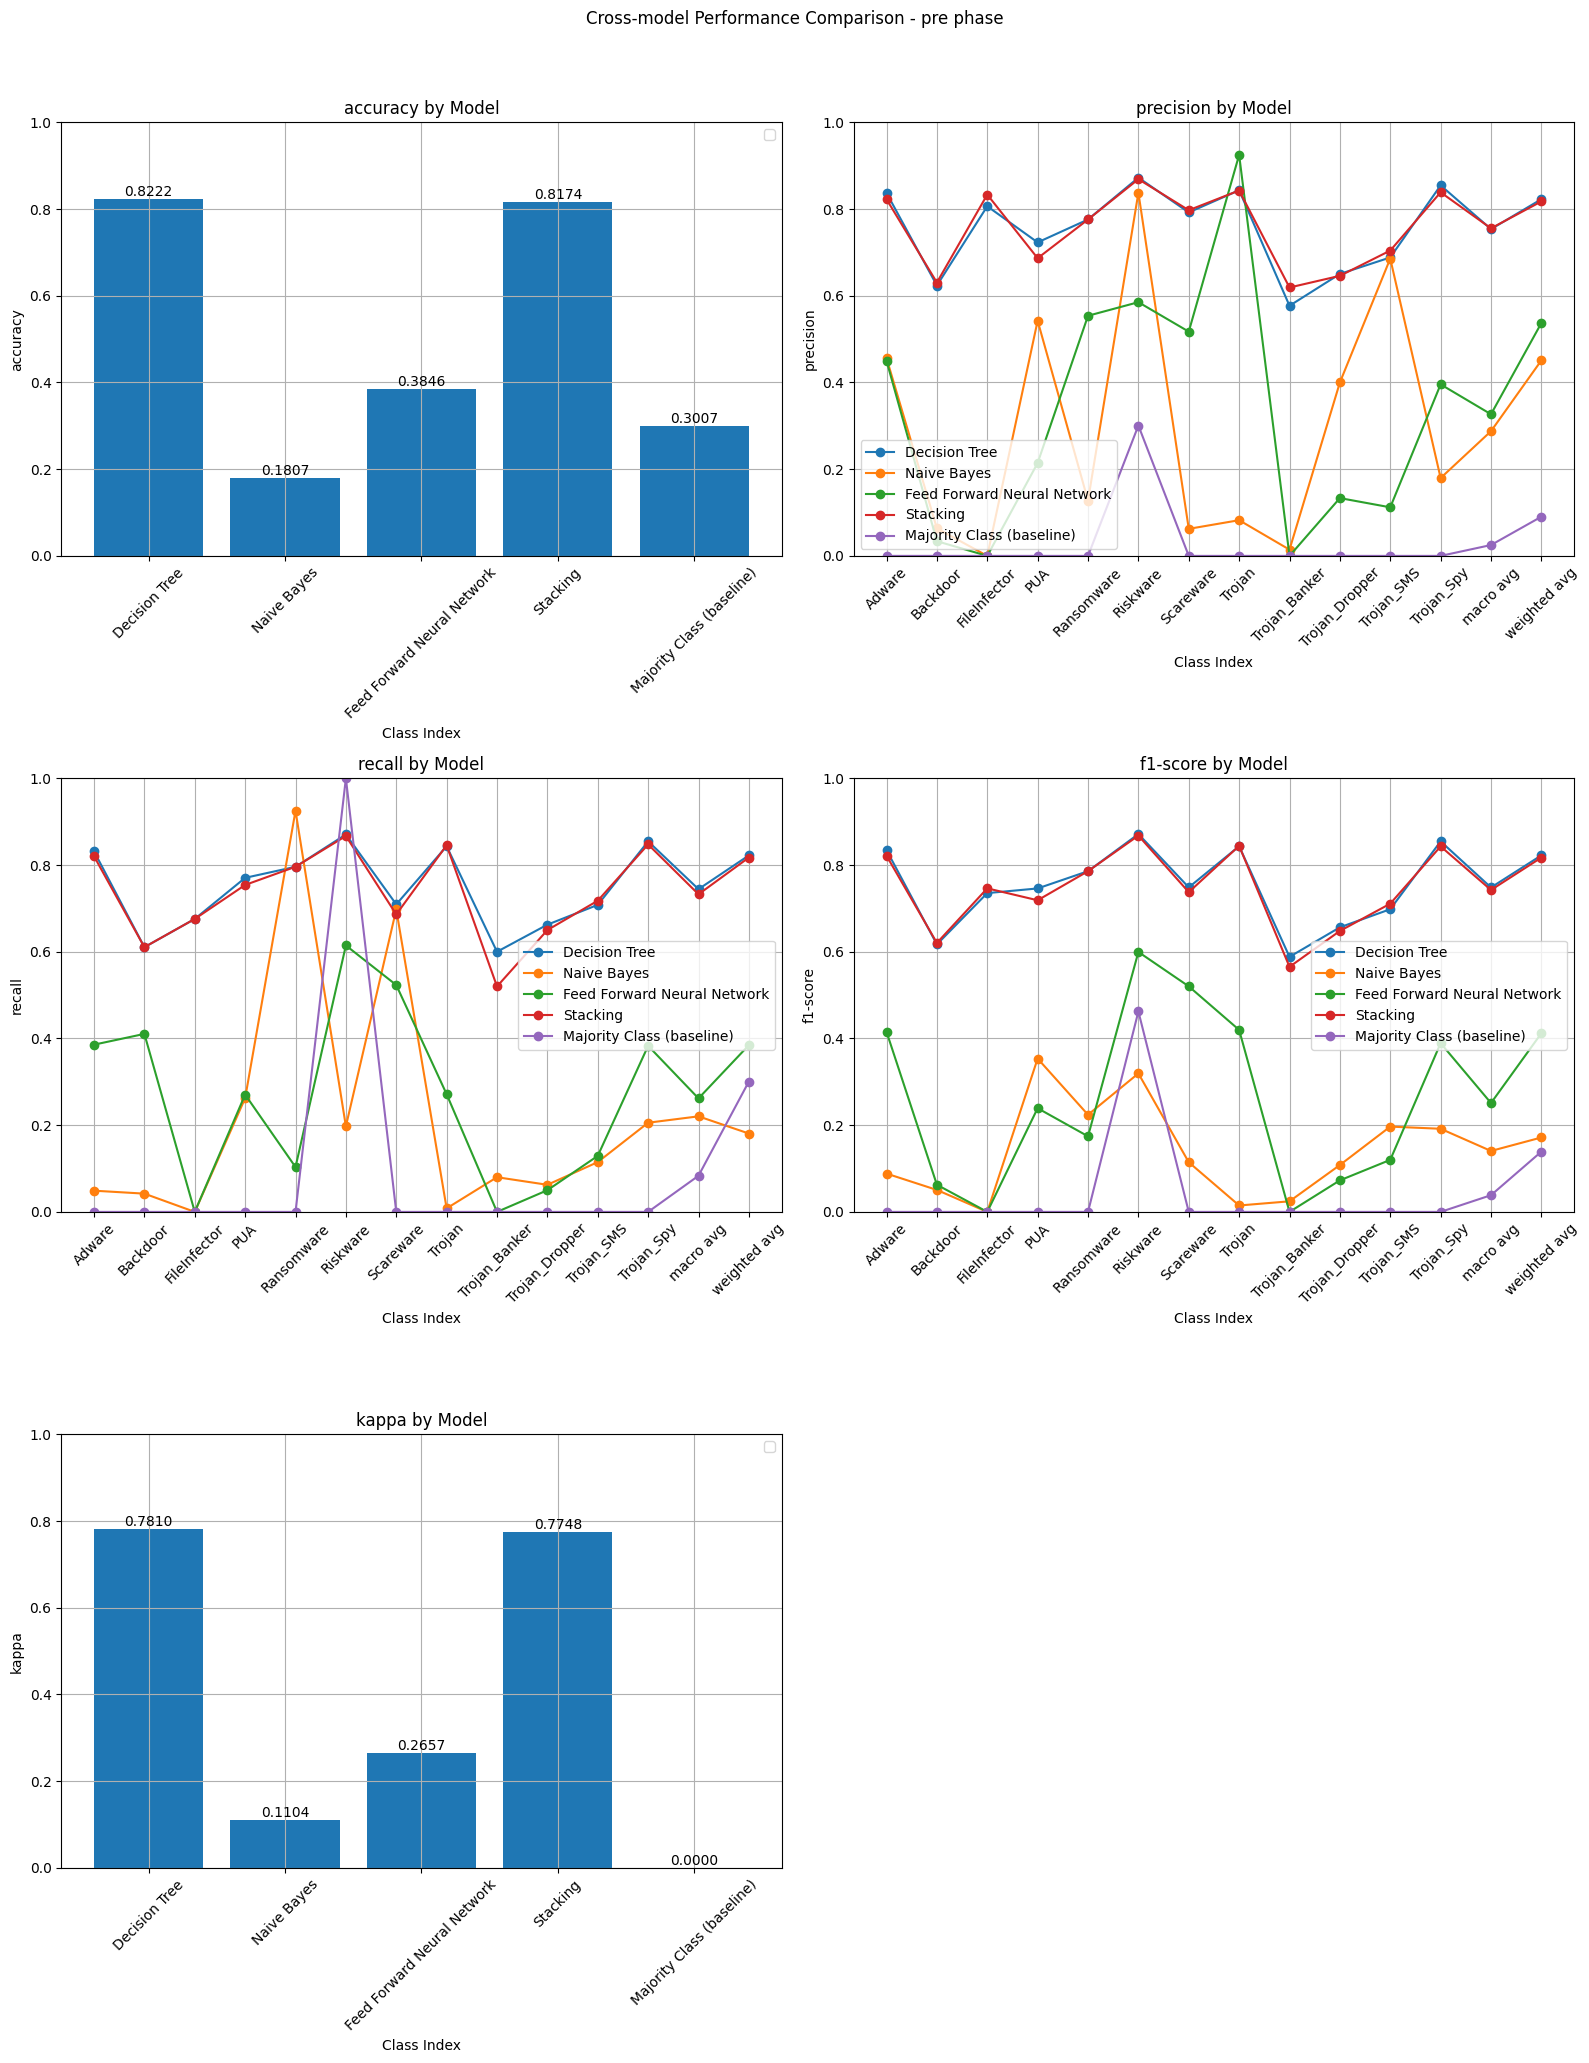

In [69]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(save_plots=False, save_path="")

Metrics df:                                                   id            timeStamp  \
0  e9eb10fb5bc1c54f16b7b4ddd18ba40a975f64710132e2...  2025-05-11 10:37:27   

                                         comments      modelName currentPhase  \
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME  Decision Tree          pre   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   6.795012   

   timeToPredict  accuracy_val  accuracy_test  precision_val  precision_test  \
0        0.11342      0.822241             -1       0.822723              -1   

   recall_val  recall_test  f1-score_val  f1-score_test  kappa_val  kappa_test  
0    0.822241           -1      0.822353             -1   0.780958          -1  


c:\Users\irina\ml-final-project\library\pipeline\analysis\pipelines_analysis.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
c:\Users\irina\ml-final-project\library\pipeline\analysis\pipelines_analysis.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


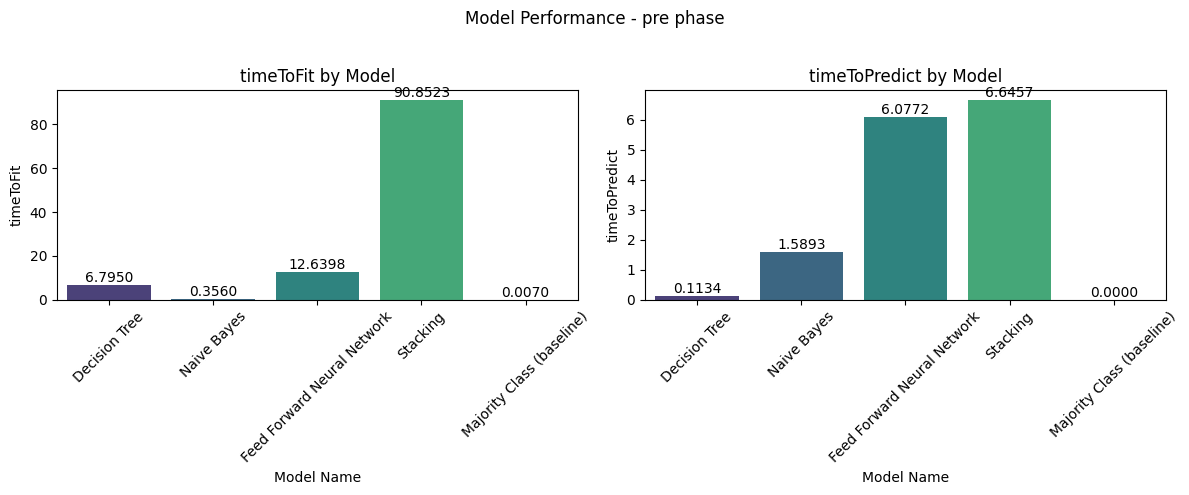

id            timeStamp  \
0  e9eb10fb5bc1c54f16b7b4ddd18ba40a975f64710132e2...  2025-05-11 10:37:27   
0  94e3f79e86b3440af7b877b13b51f00fdc0ec0082275ff...  2025-05-11 10:37:27   
0  bb79e359cc2d4935b7df909de9784a769a595cd240f014...  2025-05-11 10:37:31   
0  4335f91bbb5705ae47f32db6f6c28a6f1dfabda08d7a47...  2025-05-11 10:37:31   
0  4befebefd4f4f643dc75a7afad2b5e224a9bcf5a19eefa...  2025-05-11 10:37:28   

                                         comments  \
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME   
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME   
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME   
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME   
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME   

                     modelName currentPhase  \
0                Decision Tree          pre   
0                  Naive Bayes          pre   
0  Feed Forward Neural Network          pre   
0                     Stacking          pre   
0    Majority Class (baseline)          pre   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   6.795012   
0           {'priors': None, 'var_smoothing': 1e-09}   0.356000   
0  {'num_features': 142, 'num_classes': 12, 'batc...  12.639802   
0  {'cv': 5, 'estimators': [('Decision Tree', Dec...  90.852312   
0                                                 {}   0.007022   

   timeToPredict  accuracy_val  accuracy_test  precision_val  precision_test  \
0       0.113420      0.822241             -1       0.822723              -1   
0       1.589308      0.180736             -1       0.450944              -1   
0       6.077172      0.384648             -1       0.537108              -1   
0       6.645668      0.817351             -1       0.817587              -1   
0       0.000000      0.300659             -1       0.090396              -1   

   recall_val  recall_test  f1-score_val  f1-score_test  kappa_val  kappa_test  
0    0.822241           -1      0.822353             -1   0.780958          -1  
0    0.180736           -1      0.171624             -1   0.110437          -1  
0    0.384648           -1      0.412097             -1   0.265734          -1  
0    0.817351           -1      0.817246             -1   0.774845          -1  
0    0.300659           -1      0.139000             -1   0.000000          -1

In [70]:
metrics_df = pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"], save_plots=False, save_path="")
metrics_df

### Results Summary Visualization

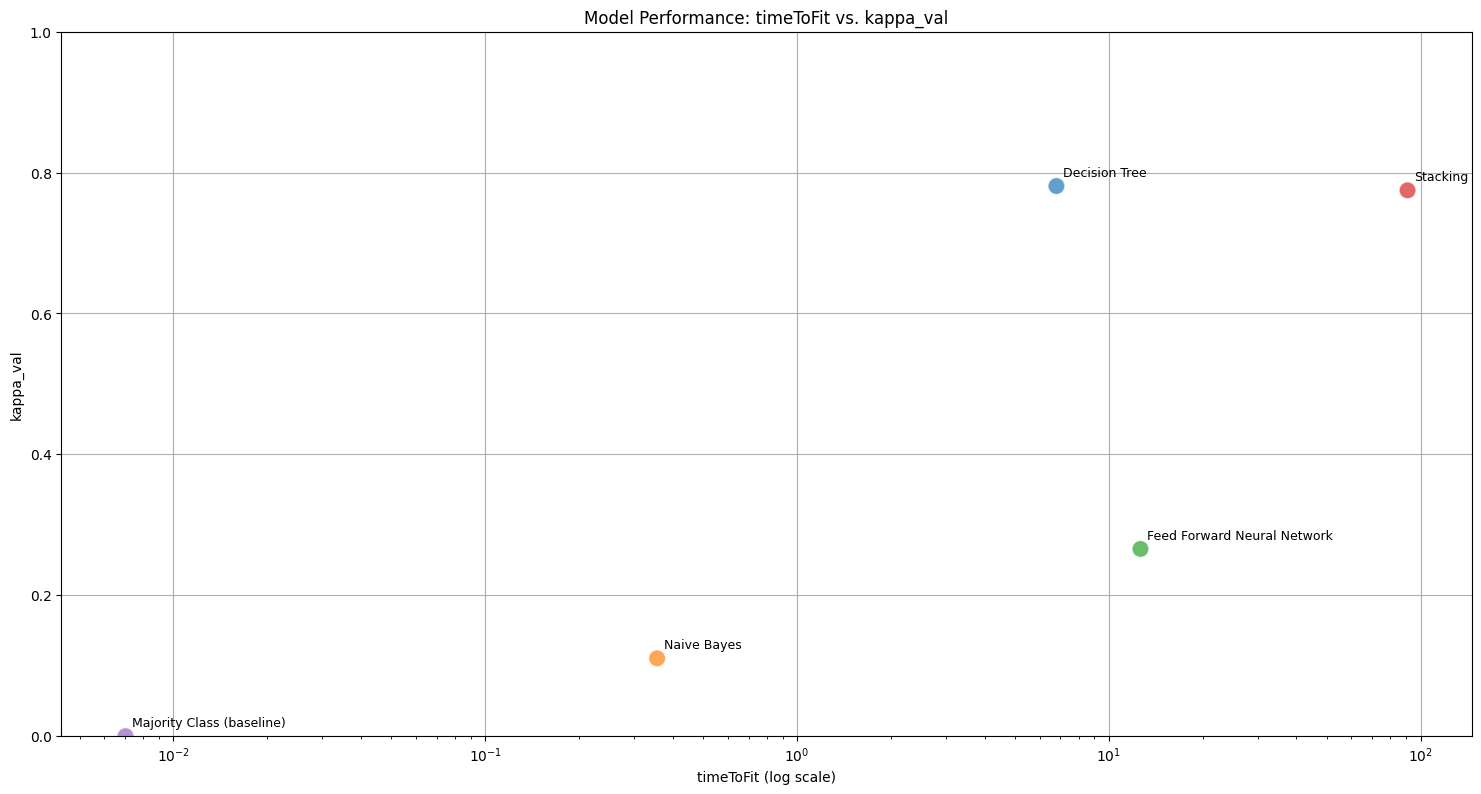

In [71]:
pipeline_manager.pipelines_analysis.plot_results_summary(training_metric="timeToFit", performance_metric="kappa", save_plots=False, save_path="")

### Intra-model Evaluation (pre-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

In [72]:
pipeline_manager.pipelines["not_baseline"]["tree_based"].modelling.list_of_models["Decision Tree"].tuning_states["pre"].assesment

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Decision Tree',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': 6.7950119972229,
 'timeToPredict': 0.11341977119445801,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': array([5, 7, 5, ..., 0, 7, 5]),
 'predictions_train': array([0, 0, 7, ..., 3, 5, 5]),
 'predictions_test': None,
 'model_sklearn': DecisionTreeClassifier(),
 'metrics': {'base_metrics': {'accuracy': 0.8222411226876462,
   'precision': 0.8227231869610717,
   'recall': 0.8222411226876462,
   'f1-score': 0.822352802303754},
  'additional_metrics': {'not_train': {'kappa': np.float64(0.78095838825101)},
   'train': {'kappa_train': np.float64(1.0)}}}}

METRICS IS None


c:\Users\irina\ml-final-project\library\pipeline\analysis\pipelines_analysis.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
c:\Users\irina\ml-final-project\library\pipeline\analysis\pipelines_analysis.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
c:\Users\irina\ml-final-project\library\pipeline\analysis\pipelines_analysis.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
c:\Users\irina\ml-final-project\library\pipeline\analysis\pipelines_analysis.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an und

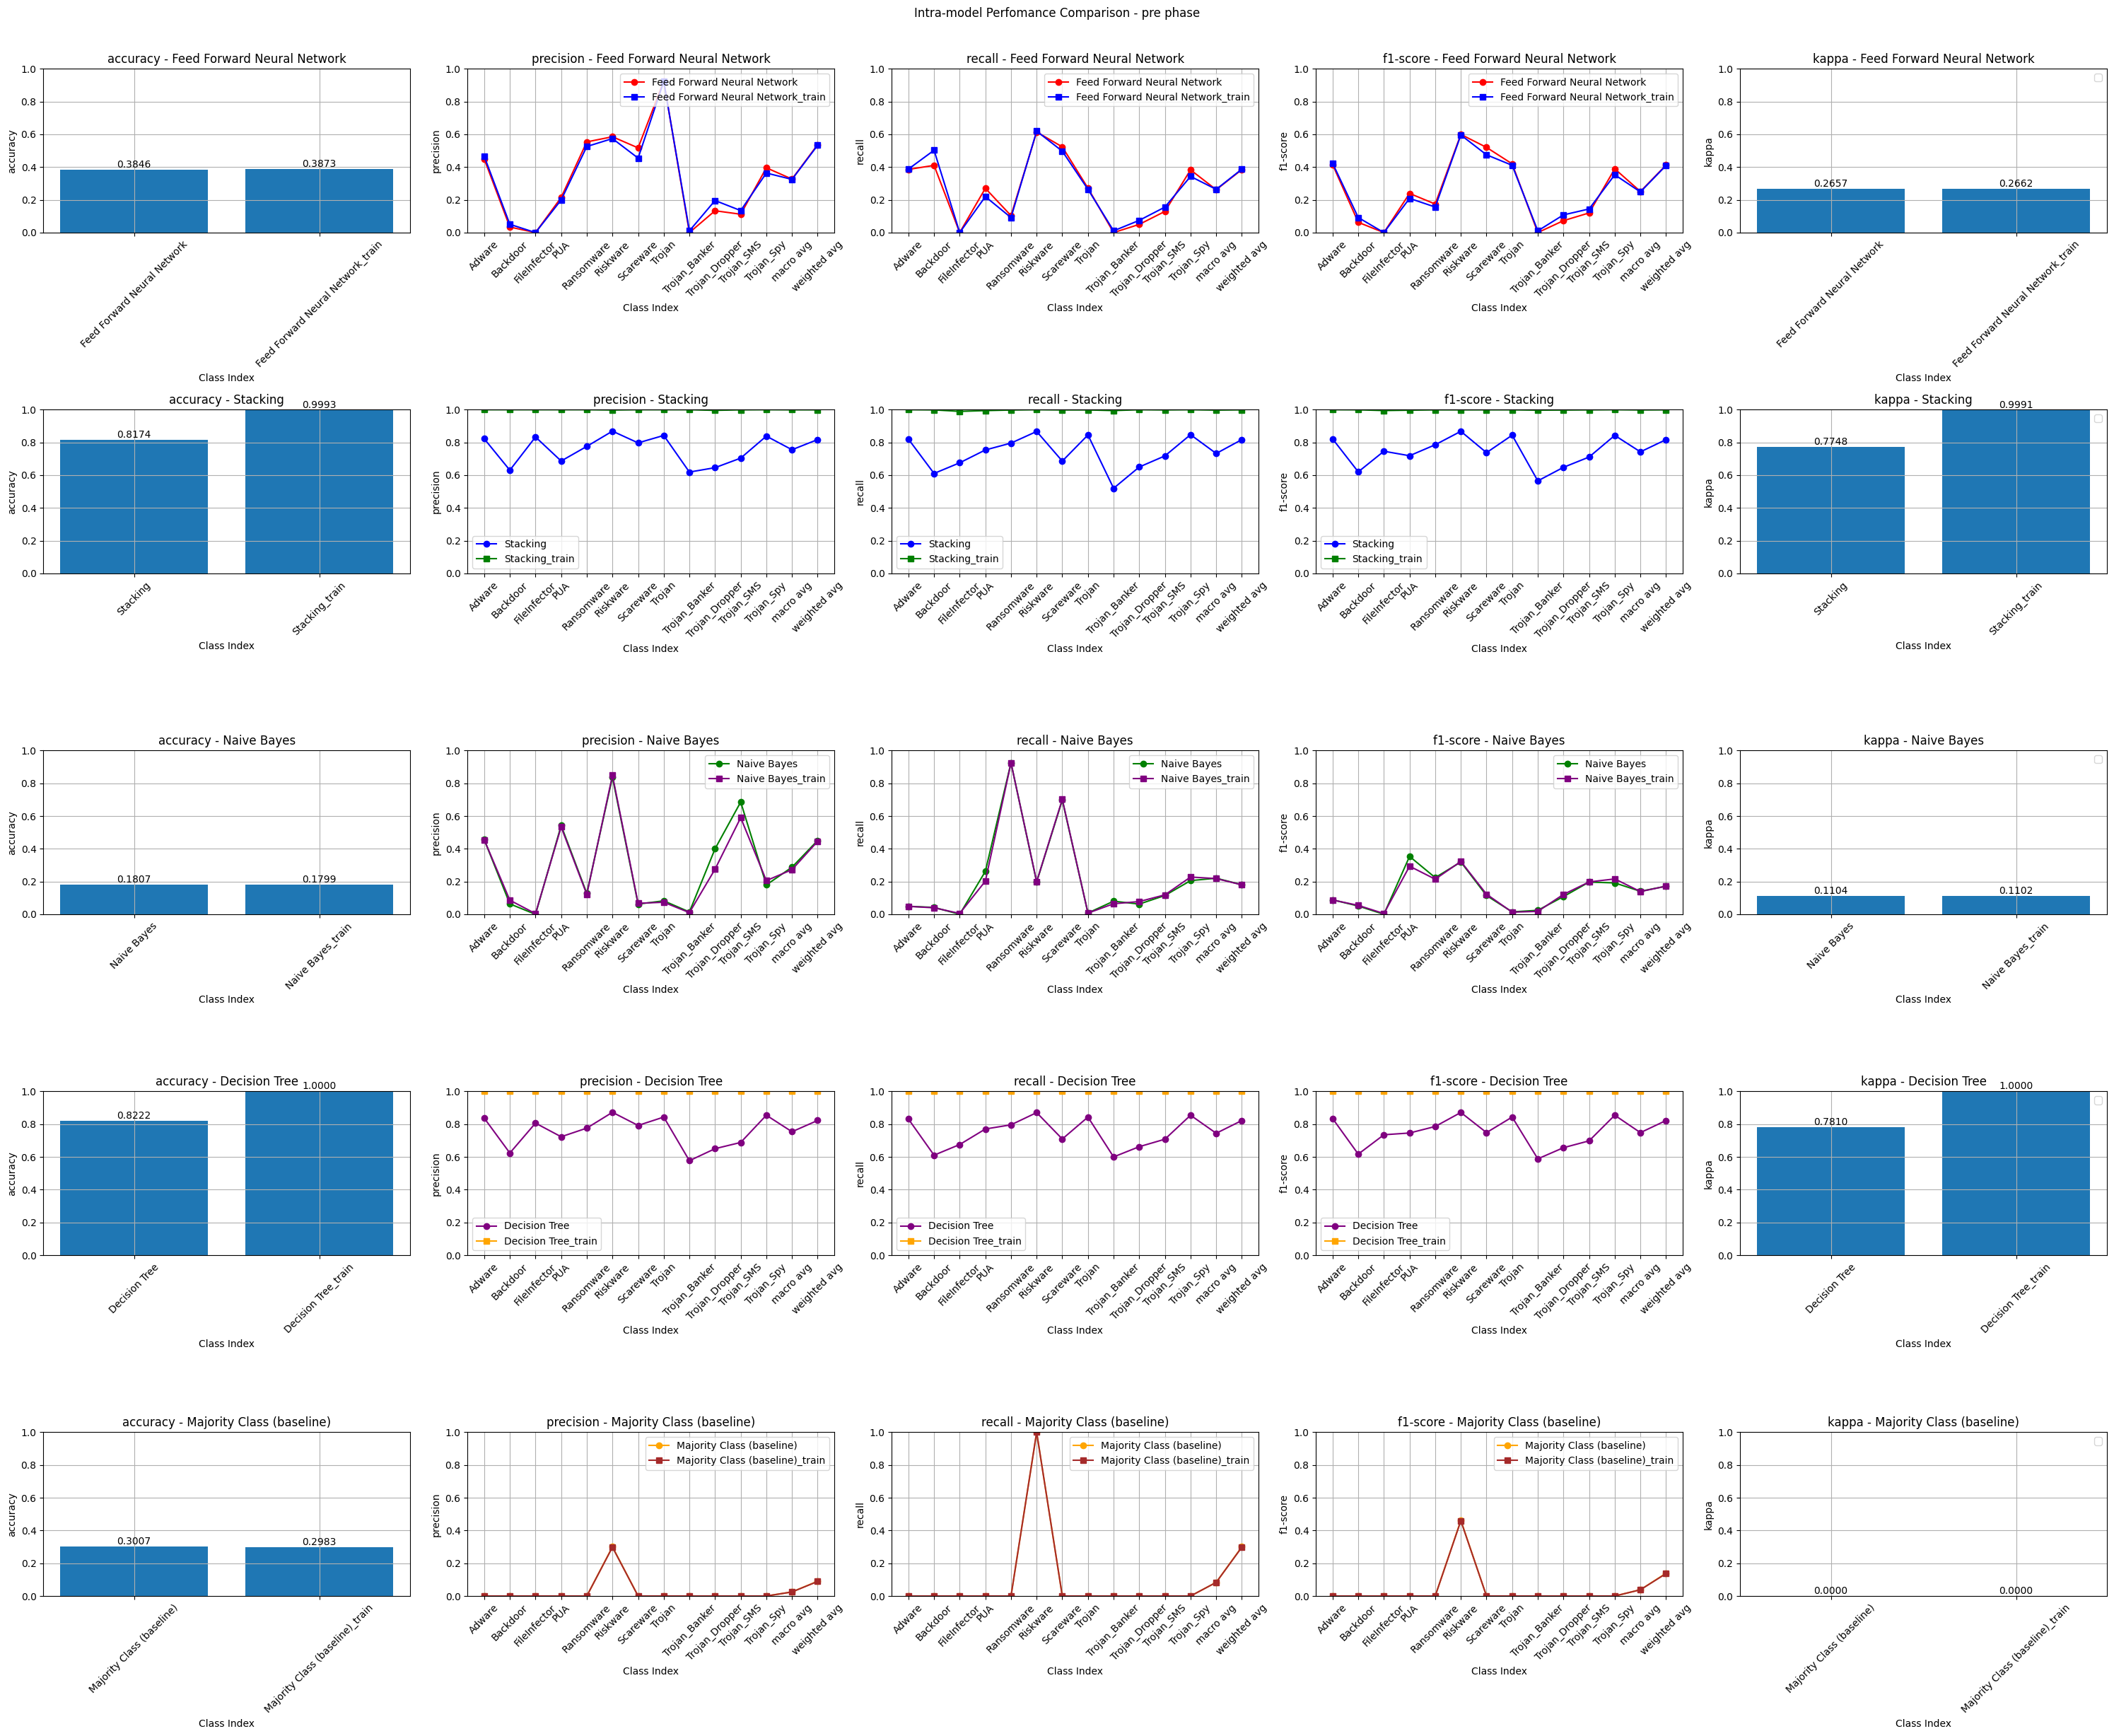

In [73]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(save_plots=False, save_path="")

We can also observe the progress per epoch so lets visualize that:

In [70]:
#pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models["Feed Forward Neural Network"].tuning_states["pre"].assesment["model_sklearn"].history.history

In [71]:
#pipeline_manager.pipelines_analysis.plot_per_epoch_progress(metrics=["accuracy", "loss"], save_plots=False, save_path="")

### Residual analysis (pre-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Decision Tree
Plotting: Naive Bayes
Plotting: Feed Forward Neural Network
Plotting: Stacking
Plotting: Majority Class (baseline)


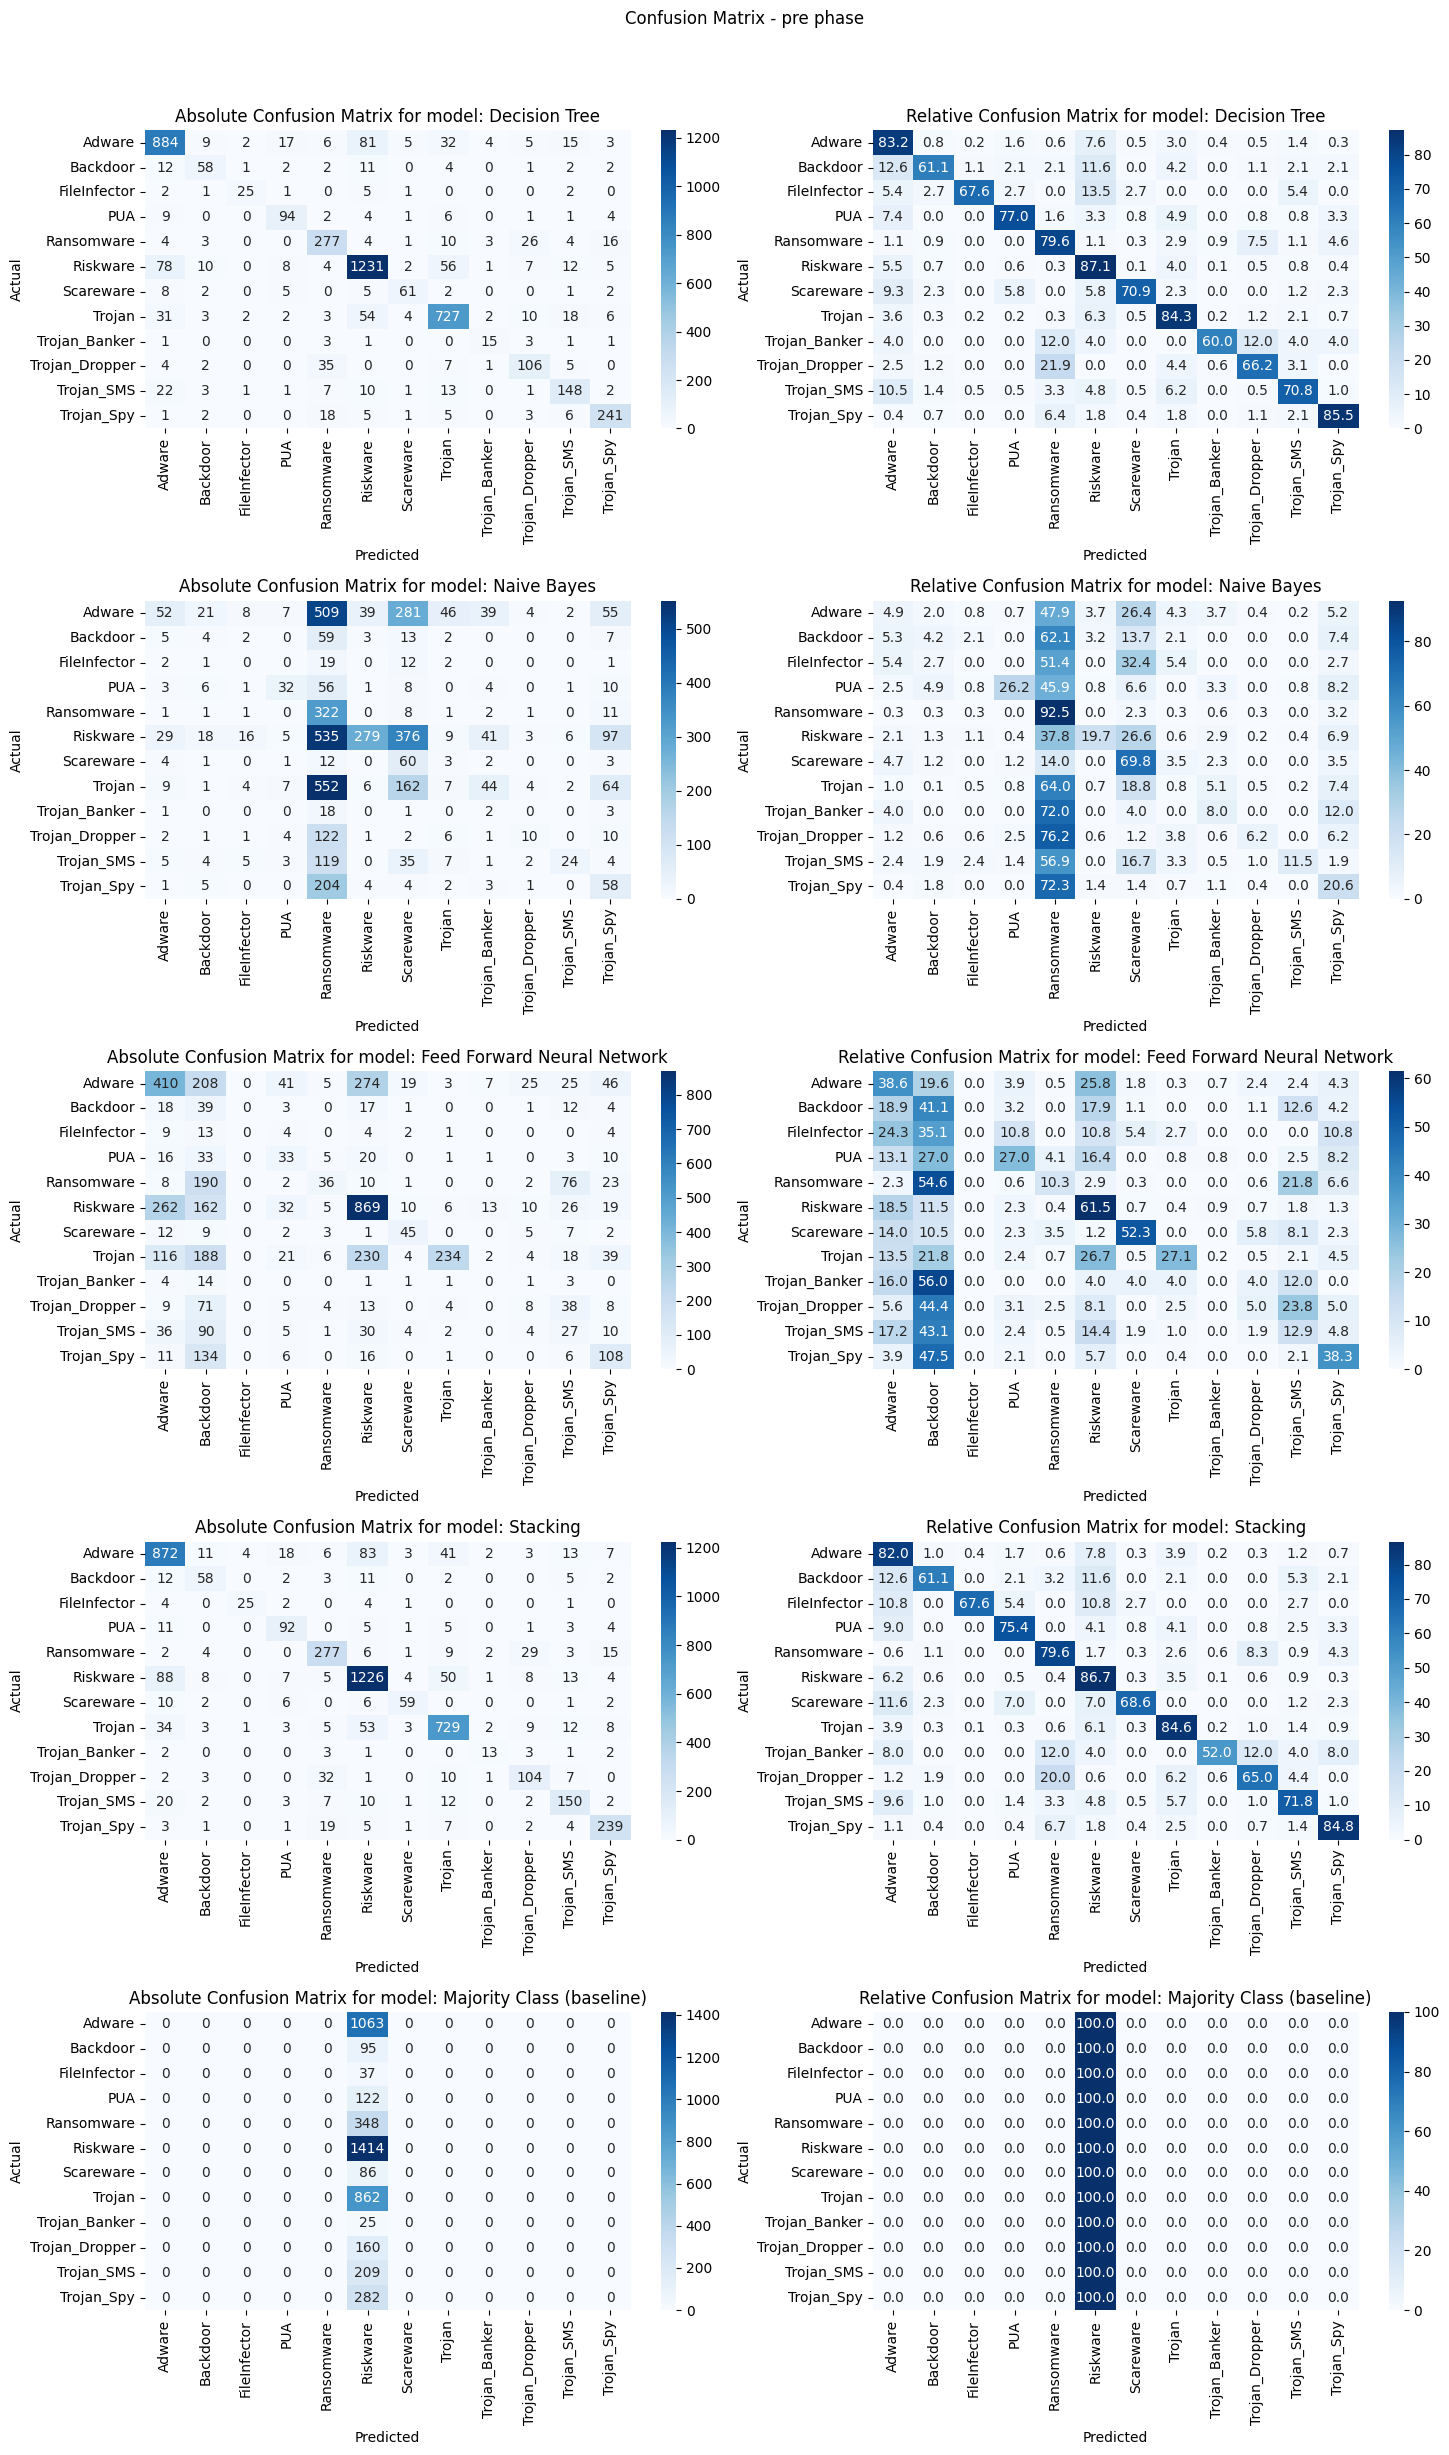

{'tree_based': 53099     3
 42114    11
 46186     7
 41946    10
 38536     5
          ..
 8398      0
 2906      0
 33099     7
 52857     3
 47610     7
 Length: 836, dtype: int64,
 'naive_bayes': 53099    3
 30660    7
 24323    5
 11712    0
 52498    3
         ..
 44394    7
 7212     0
 7612     0
 46313    7
 36519    5
 Length: 3853, dtype: int64,
 'feed_forward_neural_network': 53099    3
 30660    7
 24323    5
 11712    0
 52498    3
         ..
 47610    7
 20081    5
 7212     0
 7612     0
 36519    5
 Length: 2894, dtype: int64,
 'stacking': 53099     3
 42114    11
 46186     7
 41946    10
 22423     5
          ..
 49826     4
 2906      0
 33099     7
 52857     3
 47610     7
 Length: 859, dtype: int64,
 'baselines': 53099    3
 30660    7
 11712    0
 52498    3
 5763     0
         ..
 47610    7
 44394    7
 7212     0
 7612     0
 46313    7
 Length: 3289, dtype: int64}

In [74]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix(save_plots=False, save_path="")
residuals

### Feature importances (pre-tuning)

Feature Importance & Permutation Importance

In [75]:
logisticRegressionModel.fit(X_train, y_train)

c:\Users\irina\ml-final-project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [91]:
gradientBoostingModel.fit(X_train, y_train)

GradientBoostingClassifier()

In [92]:
randomForestModel.fit(X_train, y_train)

RandomForestClassifier()

In [93]:
decisionTreeModel.fit(X_train, y_train)

DecisionTreeClassifier()

In [94]:
nonLinearSupportVectorModel.fit(X_train, y_train)

SVC()

In [95]:
naiveBayesModel.fit(X_train, y_train)

GaussianNB()

In [99]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import pandas as pd

def plot_feature_importance_pipeline(model, X_train, y_train, model_name="Model"):
    plt.figure(figsize=(10, 6))

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = importances.argsort()
        sorted_features = [(X_train.columns[i], importances[i]) for i in indices]

        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
        plt.title(f'{model_name} - Feature Importance')
    else:
        result = permutation_importance(model, X_train, y_train, n_repeats=3, random_state=42)
        sorted_idx = result.importances_mean.argsort()
        sorted_features = [(X_train.columns[i], result.importances_mean[i]) for i in sorted_idx]

        plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
        plt.title(f'{model_name} - Permutation Importance')

    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    importance_df = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])
    print("\nFeature importances:")
    print(importance_df.to_string(index=False))
    return importance_df

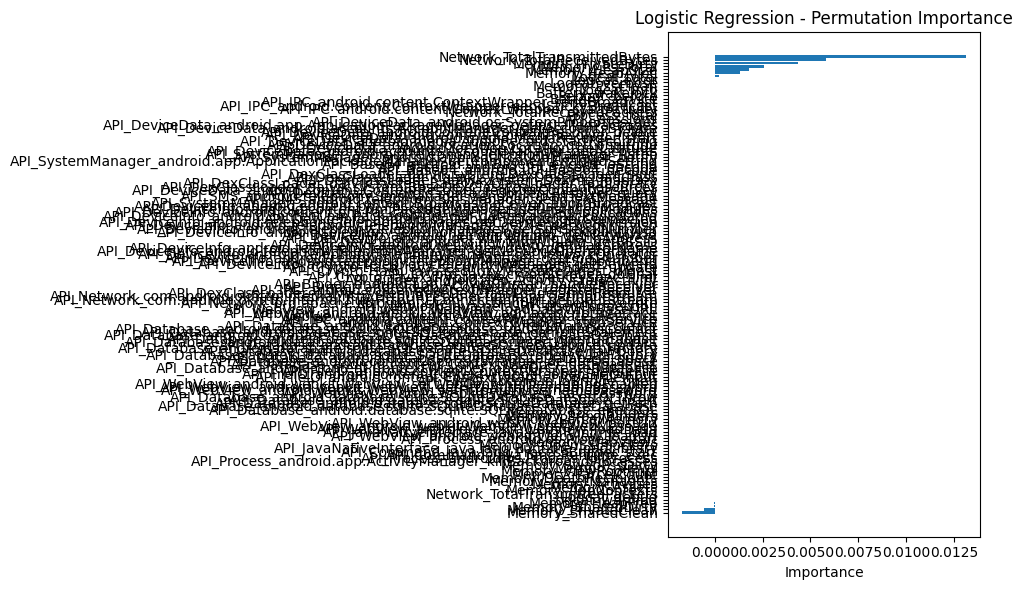


Feature importances:
                                                                           Feature  Importance
                                                                Memory_SharedClean   -0.001701
                                                               Memory_PrivateClean   -0.000549
                                                                Memory_SharedDirty   -0.000062
                                                                   Memory_HeapFree   -0.000062
                                                                    Logcat_warning   -0.000009
                                                                      Logcat_debug   -0.000009
                                                   Network_TotalTransmittedPackets   -0.000009
                                                                Memory_AppContexts    0.000000
                                                                     Memory_Assets    0.000000
                            

Feature  Importance
0               Memory_SharedClean   -0.001701
1              Memory_PrivateClean   -0.000549
2               Memory_SharedDirty   -0.000062
3                  Memory_HeapFree   -0.000062
4                   Logcat_warning   -0.000009
..                             ...         ...
137                Memory_HeapSize    0.001807
138                Memory_PssTotal    0.002569
139            Memory_PrivateDirty    0.004350
140     Network_TotalReceivedBytes    0.005812
141  Network_TotalTransmittedBytes    0.013130

[142 rows x 2 columns]

In [101]:
plot_feature_importance_pipeline(logisticRegressionModel, X_train, y_train, model_name="Logistic Regression")

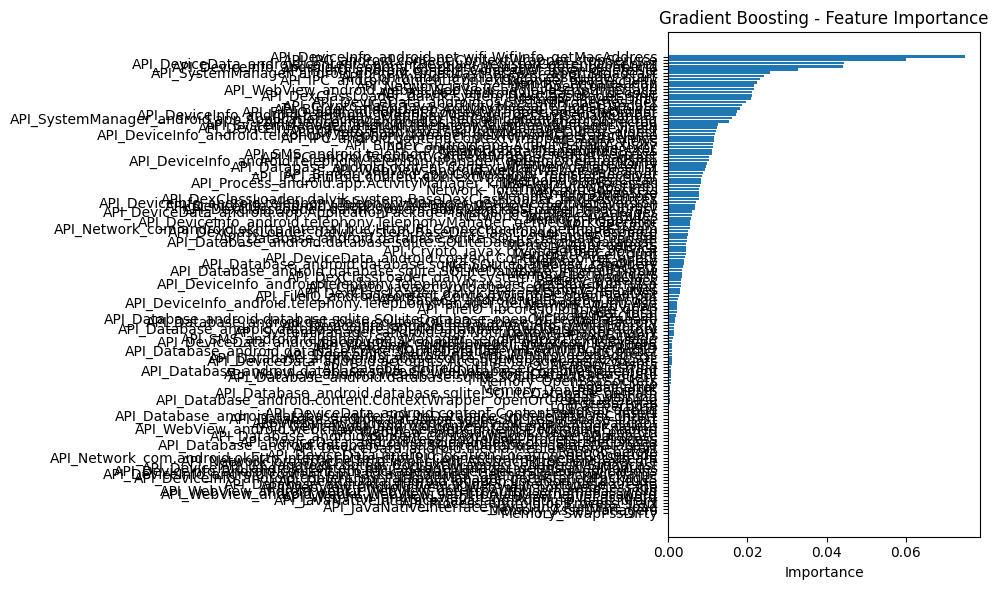


Feature importances:
                                                                           Feature  Importance
                                                               Memory_SwapPssDirty    0.000000
                                                              Memory_AssetManagers    0.000000
                                    API_JavaNativeInterface_java.lang.Runtime_load    0.000000
                                              API_Process_android.os.Process_start    0.000000
                             API_JavaNativeInterface_java.lang.Runtime_loadLibrary    0.000000
                                   API_WebView_android.webkit.WebView_savePassword    0.000000
                    API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword    0.000000
                    API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword    0.000000
                                 API_WebView_android.webkit.WebView_postWebMessage    0.000000
                        API_

Feature  Importance
0                                  Memory_SwapPssDirty    0.000000
1                                 Memory_AssetManagers    0.000000
2       API_JavaNativeInterface_java.lang.Runtime_load    0.000000
3                 API_Process_android.os.Process_start    0.000000
4    API_JavaNativeInterface_java.lang.Runtime_load...    0.000000
..                                                 ...         ...
137  API_FileIO_android.content.ContextWrapper_dele...    0.032786
138  API_DeviceInfo_android.telephony.TelephonyMana...    0.044083
139  API_DeviceData_android.content.ContentResolver...    0.044377
140  API_IPC_android.content.ContextWrapper_stopSer...    0.060140
141  API_DeviceInfo_android.net.wifi.WifiInfo_getMa...    0.074975

[142 rows x 2 columns]

In [102]:
plot_feature_importance_pipeline(gradientBoostingModel, X_train, y_train, model_name="Gradient Boosting")

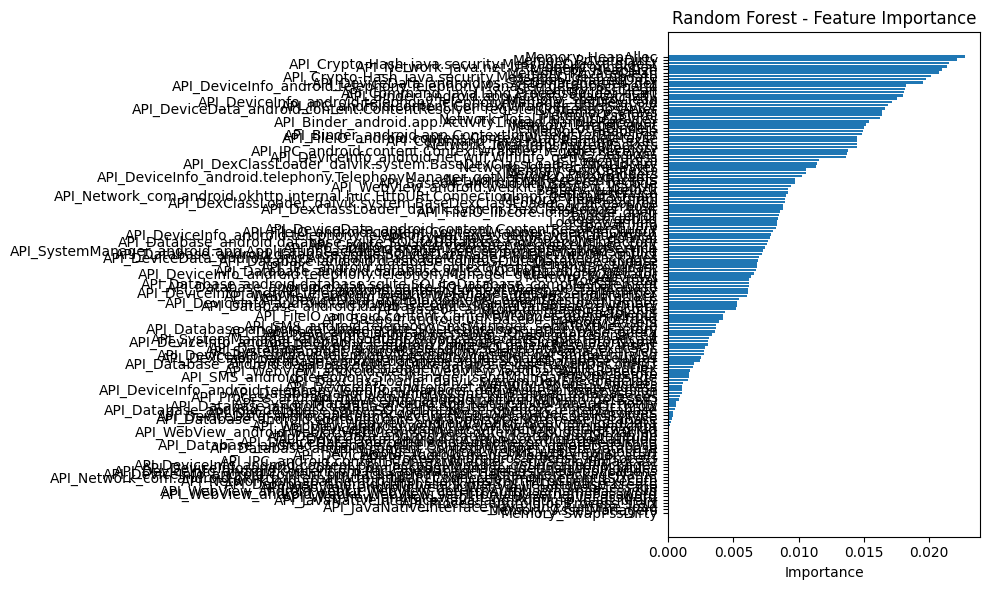


Feature importances:
                                                                           Feature   Importance
                                                               Memory_SwapPssDirty 0.000000e+00
                                                              Memory_AssetManagers 0.000000e+00
                                    API_JavaNativeInterface_java.lang.Runtime_load 0.000000e+00
                                              API_Process_android.os.Process_start 0.000000e+00
                             API_JavaNativeInterface_java.lang.Runtime_loadLibrary 0.000000e+00
                                   API_WebView_android.webkit.WebView_savePassword 0.000000e+00
                    API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword 0.000000e+00
                    API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword 0.000000e+00
                                 API_WebView_android.webkit.WebView_postWebMessage 0.000000e+00
                  

Feature  Importance
0                                  Memory_SwapPssDirty    0.000000
1                                 Memory_AssetManagers    0.000000
2       API_JavaNativeInterface_java.lang.Runtime_load    0.000000
3                 API_Process_android.os.Process_start    0.000000
4    API_JavaNativeInterface_java.lang.Runtime_load...    0.000000
..                                                 ...         ...
137                                    Memory_HeapSize    0.020982
138            API_Network_java.net.URL_openConnection    0.021402
139  API_Crypto-Hash_java.security.MessageDigest_di...    0.021526
140                                Memory_PrivateDirty    0.022128
141                                   Memory_HeapAlloc    0.022755

[142 rows x 2 columns]

In [103]:
plot_feature_importance_pipeline(randomForestModel, X_train, y_train, model_name="Random Forest")

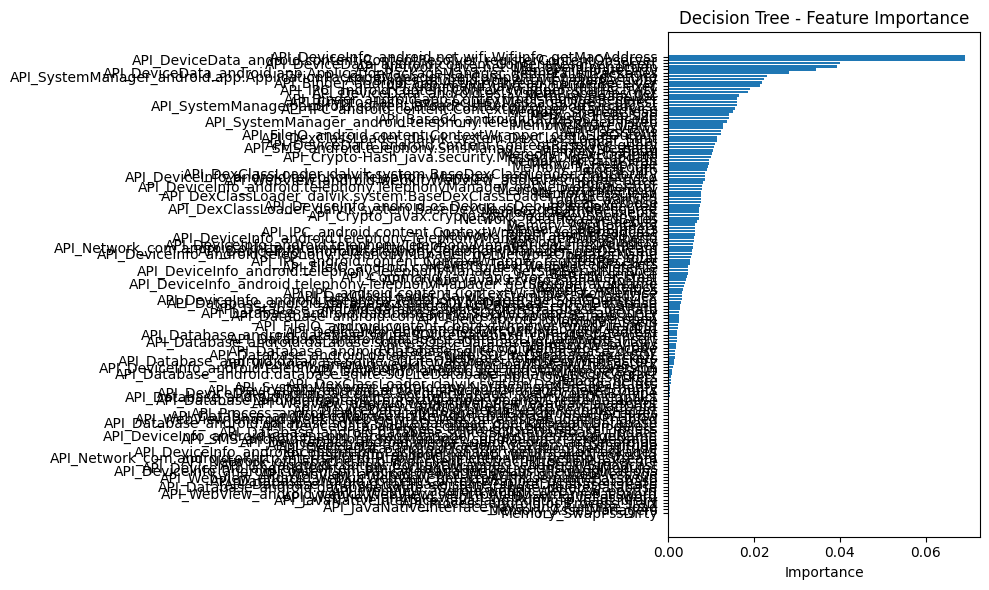


Feature importances:
                                                                           Feature  Importance
                                                               Memory_SwapPssDirty    0.000000
                                                              Memory_AssetManagers    0.000000
                                    API_JavaNativeInterface_java.lang.Runtime_load    0.000000
                                              API_Process_android.os.Process_start    0.000000
                             API_JavaNativeInterface_java.lang.Runtime_loadLibrary    0.000000
                                   API_WebView_android.webkit.WebView_savePassword    0.000000
                    API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword    0.000000
                                        API_WebView_android.webkit.WebView_postUrl    0.000000
                API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase    0.000000
                        API_

Feature  Importance
0                                  Memory_SwapPssDirty    0.000000
1                                 Memory_AssetManagers    0.000000
2       API_JavaNativeInterface_java.lang.Runtime_load    0.000000
3                 API_Process_android.os.Process_start    0.000000
4    API_JavaNativeInterface_java.lang.Runtime_load...    0.000000
..                                                 ...         ...
137                                Memory_PrivateDirty    0.034400
138            API_Network_java.net.URL_openConnection    0.039252
139  API_DeviceData_android.content.ContentResolver...    0.040054
140  API_DeviceData_android.content.ContentResolver...    0.069060
141  API_DeviceInfo_android.net.wifi.WifiInfo_getMa...    0.069198

[142 rows x 2 columns]

In [92]:
plot_feature_importance_pipeline(decisionTreeModel, X_train, y_train, model_name="Decision Tree")

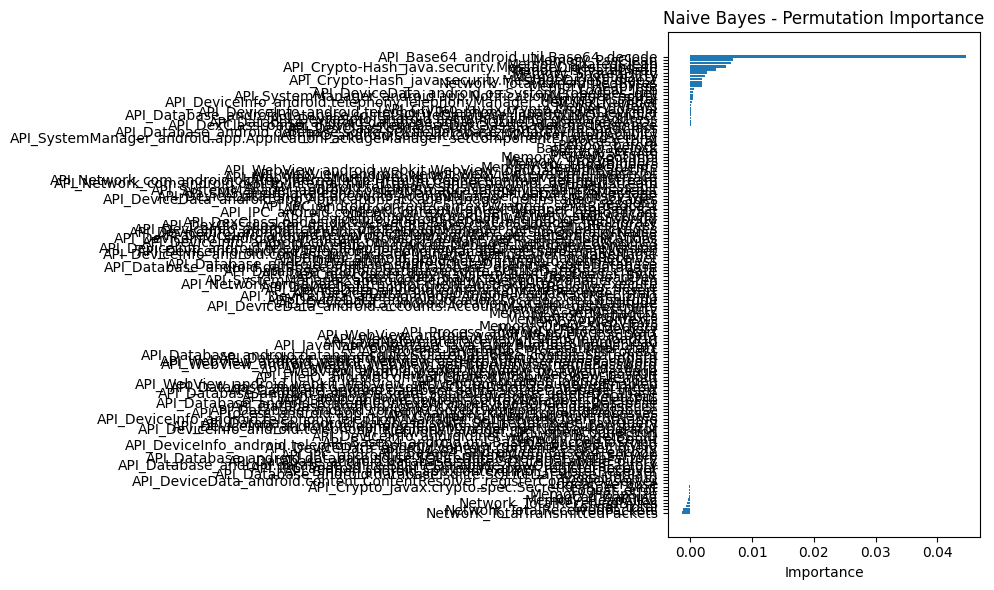


Feature importances:
                                                                           Feature  Importance
                                                   Network_TotalTransmittedPackets   -0.001311
                                                      Network_TotalReceivedPackets   -0.001169
                                                                      Logcat_total   -0.000664
                                                        Network_TotalReceivedBytes   -0.000532
                                                                  Memory_HeapAlloc   -0.000381
                                                                    Logcat_warning   -0.000301
                                                                   Memory_HeapSize   -0.000275
                                                                      Logcat_error   -0.000230
                                  API_Crypto_javax.crypto.spec.SecretKeySpec_$init   -0.000142
                            

Feature  Importance
0                      Network_TotalTransmittedPackets   -0.001311
1                         Network_TotalReceivedPackets   -0.001169
2                                         Logcat_total   -0.000664
3                           Network_TotalReceivedBytes   -0.000532
4                                     Memory_HeapAlloc   -0.000381
..                                                 ...         ...
137                                Memory_PrivateClean    0.004208
138  API_Crypto-Hash_java.security.MessageDigest_up...    0.005723
139                                 Memory_SharedClean    0.006538
140                                    Memory_PssClean    0.006822
141              API_Base64_android.util.Base64_decode    0.044589

[142 rows x 2 columns]

In [93]:
plot_feature_importance_pipeline(naiveBayesModel, X_train, y_train, model_name="Naive Bayes")

SHAP

In [104]:
import shap
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def explain_with_shap_pipeline(model, default_pipeline, model_name="Model"):
    print(f"Generating SHAP explanations for {model_name}. This may take some time...")
    X_sample = default_pipeline.dataset.X_train
    if len(X_sample) > 100:
        sample_indices = np.random.choice(len(X_sample), 100, replace=False)
        X_sample_subset = X_sample.iloc[sample_indices]
    else:
        X_sample_subset = X_sample
    try:
        if hasattr(model, 'predict_proba'):
            explainer = shap.Explainer(model, X_sample_subset)
            shap_values = explainer(X_sample_subset, max_evals=100)
        else:
            explainer = shap.Explainer(model.predict, X_sample_subset)
            shap_values = explainer(X_sample_subset, max_evals=100)
        shap.summary_plot(shap_values, X_sample_subset, plot_type="bar", max_display=10)
        plt.title(f"{model_name} - SHAP Feature Importance")
        plt.tight_layout()
        plt.show()
        return shap_values
    except Exception as e:
        print(f"Error explaining {model_name} with SHAP: {str(e)}")
        print("Skipping this model and continuing with others...")
        return None

c:\Users\irina\ml-final-project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating SHAP explanations for Gradient Boosting. This may take some time...
Error explaining Gradient Boosting with SHAP: The passed model is not callable and cannot be analyzed directly with the given masker! Model: GradientBoostingClassifier()
Skipping this model and continuing with others...
Generating SHAP explanations for Logistic Regression. This may take some time...


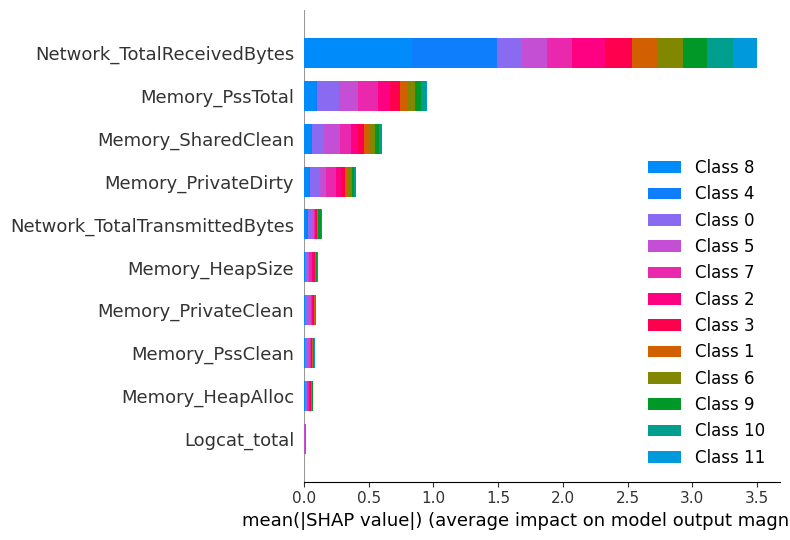

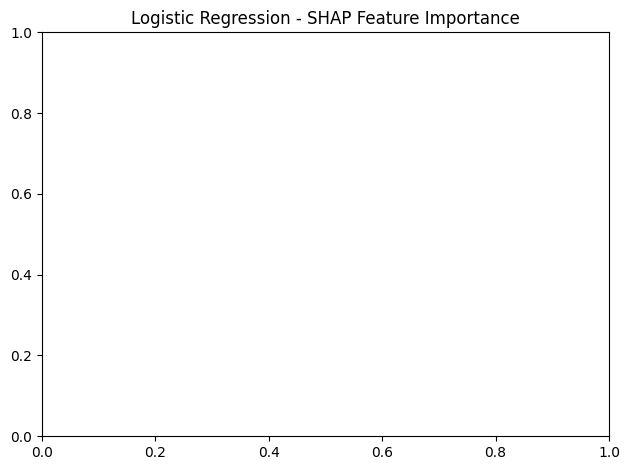

.values =
array([[[-2.26104336e-01,  8.22707591e-02,  1.26573947e-01, ...,
          6.27731104e-02,  4.61724446e-02,  1.60020353e-02],
        [-1.61475240e-02,  4.98540027e-03,  6.10414439e-03, ...,
          4.87643036e-03,  1.87372461e-03,  4.30061947e-03],
        [ 1.08824902e-03, -4.78143711e-04, -7.59782147e-04, ...,
         -3.91790518e-04, -2.59044810e-04,  1.05825755e-05],
        ...,
        [ 8.39825909e-03, -3.64800925e-03, -6.28452140e-03, ...,
         -3.15299343e-03, -2.53237733e-03,  8.43301153e-05],
        [ 1.85002658e-08, -8.48635667e-09, -1.32973318e-08, ...,
         -6.58134700e-09, -4.96379426e-09,  7.78802407e-10],
        [-1.73494638e-11,  8.05642740e-12,  1.23501974e-11, ...,
          5.93022012e-12,  4.79731238e-12, -3.89011702e-12]],

       [[-2.05944273e-01,  7.49352799e-02,  1.15288278e-01, ...,
          5.71760933e-02,  4.20555869e-02,  1.45752514e-02],
        [-1.64528660e-02,  5.07967182e-03,  6.21957086e-03, ...,
          4.96864134e-03,  1

In [105]:
explain_with_shap_pipeline(gradientBoostingModel, default_pipeline, model_name="Gradient Boosting")
explain_with_shap_pipeline(logisticRegressionModel, default_pipeline, model_name="Logistic Regression")

LIME

In [108]:
import lime
import lime.lime_tabular

def explain_with_lime_pipeline(model, default_pipeline, model_name="Model"):
    X_train = default_pipeline.dataset.X_train
    X_sample = X_train.iloc[0]
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=X_train.columns.tolist(),
        mode="classification" if len(set(model.predict(X_train))) > 2 else "regression"
    )
    explanation = explainer.explain_instance(X_sample.values, model.predict_proba)
    explanation.show_in_notebook(show_table=True)
    return explanation

In [119]:
from IPython.display import display

explain_with_lime_pipeline(logisticRegressionModel, default_pipeline, model_name="Logistic Regression")

c:\Users\irina\ml-final-project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


ImportError: cannot import name 'display' from 'IPython.core.display' (c:\Users\irina\ml-final-project\venv\Lib\site-packages\IPython\core\display.py)

Model Calibration

In [111]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

def plot_multiclass_reliability_diagram(model, X, y, class_labels=None, model_name="Model"):
    """
    Plot reliability diagrams for each class in a multiclass setting using one-vs-rest calibration curves.
    """
    print(f"Generating multiclass reliability diagram for {model_name}...")

    # Split calibration set
    X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=0.2, random_state=42)

    # Calibrate model (sigmoid, internal CV)
    calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv=3)
    calibrated_model.fit(X_train, y_train)

    # Get predicted probabilities
    y_probs = calibrated_model.predict_proba(X_calib)

    # Get class labels
    n_classes = y_probs.shape[1]
    if class_labels is None:
        class_labels = list(range(n_classes))

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        y_true_bin = (y_calib == i).astype(int)
        prob_true, prob_pred = calibration_curve(y_true_bin, y_probs[:, i], n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o', label=f"Class {class_labels[i]}")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("True Fraction of Positives")
    plt.title(f"Reliability Diagram - {model_name}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Generating multiclass reliability diagram for Logistic Regression...


c:\Users\irina\ml-final-project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\irina\ml-final-project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

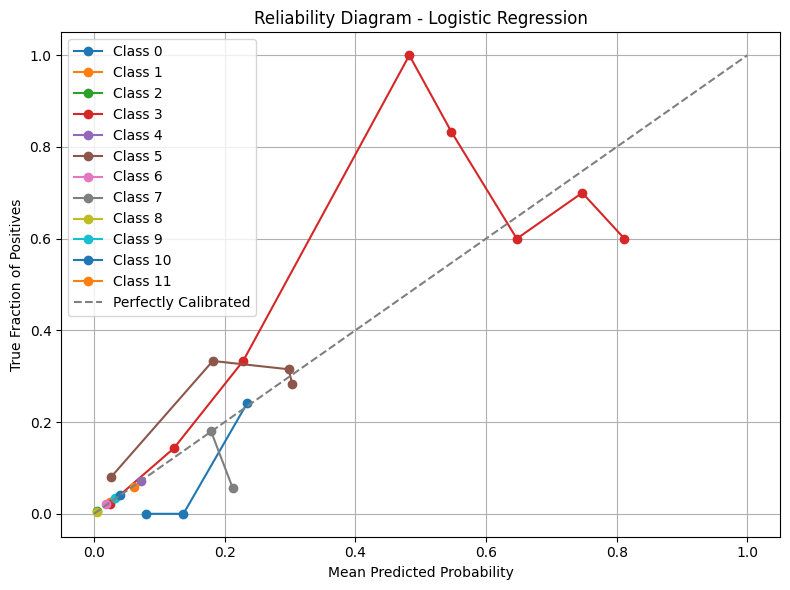

In [112]:
plot_multiclass_reliability_diagram(
    logisticRegressionModel,
    default_pipeline.dataset.X_train,
    default_pipeline.dataset.y_train,
    model_name="Logistic Regression"
)

Generating multiclass reliability diagram for Gradient Boosting...


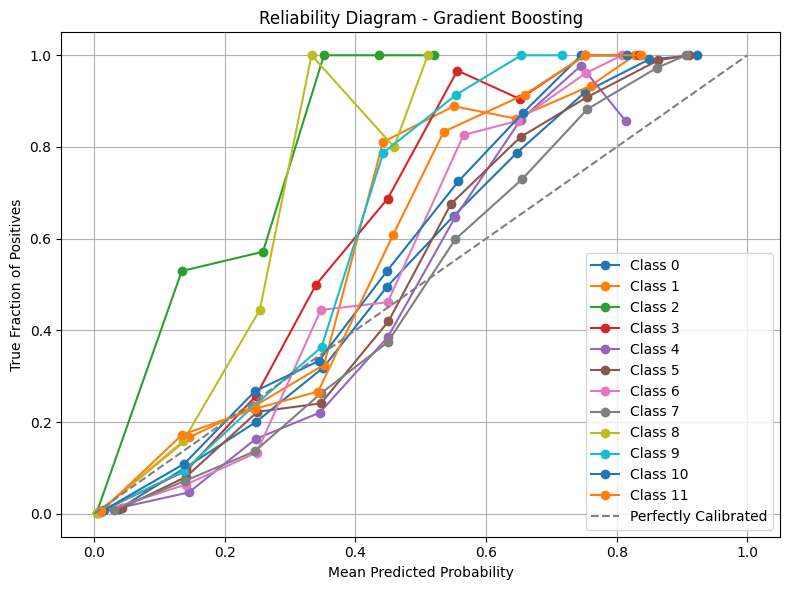

In [113]:
plot_multiclass_reliability_diagram(
    gradientBoostingModel,
    default_pipeline.dataset.X_train,
    default_pipeline.dataset.y_train,
    model_name="Gradient Boosting"
)

## Hyperparameter Optimization
1. Bind the grids to each model in each pipeline
2. Start all optimizations in parallel

In [74]:
pipeline_manager.pipeline_state = "in"

In [75]:
rf_grid = {
      'n_estimators': [50, 100, 150, 200], 
      'max_depth': [None, 10, 20, 30], 
      'min_samples_split': [2, 5, 10], 
      'min_samples_leaf': [1, 2, 4,]
}

dt_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.01, 0.1]

} 

gnb_grid = {
    'var_smoothing': Real(1e-12, 1e-6, prior='log-uniform')
}

In [76]:
modelNameToOptimizer = {
                  "Random Forest": {
                        "optimizer_type": "bayes",
                        "param_grid": rf_grid,
                        "max_iter": 1
                  },
                  "Decision Tree": {
                        "optimizer_type": "bayes",
                        "param_grid": dt_grid,
                        "max_iter": 1
                  },
                  "Naive Bayes": {
                        "optimizer_type": "bayes",
                        "param_grid": gnb_grid,
                        "max_iter": 1
                  },
                  "Feed Forward Neural Network": {
                        "optimizer_type": "bayes_nn",
                        "param_grid": None, # its hardcoded
                        "max_iter": 2,
                        "epochs": 2 
                  }
            }

In [77]:
optimized_models = pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models", 
                                       exclude_pipeline_names=["stacking"],
                                       current_phase=pipeline_manager.pipeline_state,
                                       modelNameToOptimizer=modelNameToOptimizer)

Trial 2 Complete [00h 00m 02s]
val_accuracy: 0.4886242747306824

Best val_accuracy So Far: 0.4886242747306824
Total elapsed time: 00h 00m 03s
 => FINISHED OPTIMIZATION FOR Feed Forward Neural Network
Best params: {'n_layers': 4, 'units_0': 128, 'act_0': 'tanh', 'units_1': 128, 'act_1': 'tanh', 'units_2': 256, 'act_2': 'tanh', 'units_3': 64, 'act_3': 'tanh', 'learning_rate': 0.00012757332121604654}
=> Predicting Feed Forward Neural Network model
!> Started predicting Feed Forward Neural Network
Predicting training data
 368/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
Predicting not training data
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
		 => Predicted Feed Forward Neural Network. Took 0.6260039806365967 seconds
Optimized model Feed Forward Neural Network
=> Fitting Decision Tree model
Model object: <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier object at 0x292ee13d0> for Decision Tree
Model object: <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier object at 0x292ee13d0>
=> Fitting Naive Bayes model
Model object: <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier object at 0x294fe5050> for Naive Bayes
Model object: <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier object at 0x294fe5050>
 => STARTING OPTIMIZATION FOR Naive Bayes
 => STARTING OPTIMIZATION FOR Decision Tree
Fittin

Lets visualize the resutls of the optimized models

In [78]:
pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models

{'Feed Forward Neural Network': <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier at 0x282d72390>}

In [79]:
optimized_models

{'not_baseline': {'ensembled': {},
  'support_vector_machine': {},
  'feed_forward_neural_network': {'Feed Forward Neural Network': FeedForwardNeuralNetwork(activations=['tanh', 'tanh', 'tanh', 'tanh'],
                            batch_size=128, epochs=1,
                            kernel_initializer='glorot_uniform',
                            learning_rate=0.00012757332121604654, n_layers=4,
                            num_classes=12, num_features=142,
                            units_per_layer=[128, 128, 256, 64])},
  'naive_bayes': {'Naive Bayes': GaussianNB(var_smoothing=2.888176653914472e-10)},
  'tree_based': {'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=30,
                          min_samples_leaf=5, min_samples_split=5)}},
 'baseline': {'baselines': {}}}

If you want to see the cross validation progress for a given model you just need to:

## Stacking Model: Training and Hyperparamter Optimization

In [80]:
estimators = []

for pipelineName, results in optimized_models["not_baseline"].items():
      if isinstance(results, dict):
            for modelName, modelObject in results.items():
                  estimators.append((modelName, modelObject))

estimators

[('Feed Forward Neural Network',
  FeedForwardNeuralNetwork(activations=['tanh', 'tanh', 'tanh', 'tanh'],
                           batch_size=128, epochs=1,
                           kernel_initializer='glorot_uniform',
                           learning_rate=0.00012757332121604654, n_layers=4,
                           num_classes=12, num_features=142,
                           units_per_layer=[128, 128, 256, 64])),
 ('Naive Bayes', GaussianNB(var_smoothing=2.888176653914472e-10)),
 ('Decision Tree',
  DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=30,
                         min_samples_leaf=5, min_samples_split=5))]

In [81]:
#Stacking model
stackingModel = StackingClassifier(
      estimators=estimators,
      final_estimator=LogisticRegression(),
      cv=5,
      verbose=3
)
stackingModel

StackingClassifier(cv=5,
                   estimators=[('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(activations=['tanh',
                                                                      'tanh',
                                                                      'tanh',
                                                                      'tanh'],
                                                         batch_size=128,
                                                         epochs=1,
                                                         kernel_initializer='glorot_uniform',
                                                         learning_rate=0.00012757332121604654,
                                                         n_layers=4,
                                                         num_classes=12,
                                                         num_features=142,
                                                         units_per_layer=[128,
                                                                          128,
                                                                          256,
                                                                          64])),
                               ('Naive Bayes',
                                GaussianNB(var_smoothing=2.888176653914472e-10)),
                               ('Decision Tree',
                                DecisionTreeClassifier(ccp_alpha=0.01,
                                                       criterion='entropy',
                                                       max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5))],
                   final_estimator=LogisticRegression(), verbose=3)

In [82]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["in"].assesment["model_sklearn"] = stackingModel
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["post"].assesment["model_sklearn"] = stackingModel

In [83]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["in"].model_sklearn = stackingModel
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["post"].model_sklearn = stackingModel


In [84]:
stackingModel.estimators

[('Feed Forward Neural Network',
  FeedForwardNeuralNetwork(activations=['tanh', 'tanh', 'tanh', 'tanh'],
                           batch_size=128, epochs=1,
                           kernel_initializer='glorot_uniform',
                           learning_rate=0.00012757332121604654, n_layers=4,
                           num_classes=12, num_features=142,
                           units_per_layer=[128, 128, 256, 64])),
 ('Naive Bayes', GaussianNB(var_smoothing=2.888176653914472e-10)),
 ('Decision Tree',
  DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=30,
                         min_samples_leaf=5, min_samples_split=5))]

In [85]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["in"].assesment["model_sklearn"]


StackingClassifier(cv=5,
                   estimators=[('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(activations=['tanh',
                                                                      'tanh',
                                                                      'tanh',
                                                                      'tanh'],
                                                         batch_size=128,
                                                         epochs=1,
                                                         kernel_initializer='glorot_uniform',
                                                         learning_rate=0.00012757332121604654,
                                                         n_layers=4,
                                                         num_classes=12,
                                                         num_features=142,
                                                         units_per_layer=[128,
                                                                          128,
                                                                          256,
                                                                          64])),
                               ('Naive Bayes',
                                GaussianNB(var_smoothing=2.888176653914472e-10)),
                               ('Decision Tree',
                                DecisionTreeClassifier(ccp_alpha=0.01,
                                                       criterion='entropy',
                                                       max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5))],
                   final_estimator=LogisticRegression(), verbose=3)

In [86]:
all_pipelines_to_exclude = []

for pipelineName, pipelineObject in pipeline_manager.pipelines["not_baseline"].items():
      if pipelineName == "stacking":
            continue
      all_pipelines_to_exclude.append(pipelineName)

all_pipelines_to_exclude


['ensembled',
 'tree_based',
 'support_vector_machine',
 'naive_bayes',
 'feed_forward_neural_network']

In [87]:
stacking_grid = {
      'final_estimator__C': [0.01, 0.1, 1, 10],
      'final_estimator__penalty': ['l2'],
      'final_estimator__solver': ['lbfgs'],
      'passthrough': [True, False]
}

In [88]:
modelNameToOptimizer = {
      "Stacking": {
            "optimizer_type": "bayes",
            "param_grid": stacking_grid,
            "max_iter": 1
      }
}

In [89]:
optimized_models = pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models", 
                                       current_phase=pipeline_manager.pipeline_state,
                                       modelNameToOptimizer=modelNameToOptimizer
                                       )

Gonna start fitting models in in phase
Gonna start fitting models in in phase
Gonna start fitting models in in phase
Gonna start fitting models in in phase
Gonna start fitting models in in phase
Gonna start fitting models in in phase
Gonna start fitting models in in phase
Optimizing model Stacking


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


=> Fitting Stacking model
Model object: <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier object at 0x2996e5110> for Stacking
Model object: <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier object at 0x2996e5110>
 => STARTING OPTIMIZATION FOR Stacking
Fitting 5 folds for each of 1 candidates, totalling 5 fits
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3108 - loss: 1.9936


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3213 - loss: 1.9604
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3163 - loss: 1.9748
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3084 - loss: 1.9640    
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3178 - loss: 1.9663
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3116 - loss: 1.9658
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
[CV 1/5] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=lbfgs, passthrough=True;, score=0.184 total time=  14.1s
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3370 - loss: 1.9423


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


146/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2815 - loss: 2.0387  

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2971 - loss: 1.9930
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3020 - loss: 1.9906
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


147/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3164 - loss: 2.0063  

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3287 - loss: 1.9641
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3222 - loss: 1.9661
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3411 - loss: 1.9066
  1/189 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
[CV 2/5] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=lbfgs, passthrough=True;, score=0.178 total time=  14.6s
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3318 - loss: 1.9514


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3308 - loss: 1.9394
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3217 - loss: 1.9858
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3403 - loss: 1.9240
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


145/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2792 - loss: 2.0772  

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2990 - loss: 2.0196
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3065 - loss: 1.9773
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
[CV 3/5] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=lbfgs, passthrough=True;, score=0.227 total time=  14.5s
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3414 - loss: 1.9273


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3104 - loss: 2.0080
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3207 - loss: 1.9561
  1/189 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3484 - loss: 1.8953
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3180 - loss: 1.9444
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


185/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3287 - loss: 1.9478  

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3300 - loss: 1.9440
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
[CV 4/5] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=lbfgs, passthrough=True;, score=0.187 total time=  14.3s
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3284 - loss: 1.9868


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3166 - loss: 1.9825
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3552 - loss: 1.9200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3209 - loss: 1.9375
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3219 - loss: 1.9723
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3238 - loss: 1.9291
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
[CV 5/5] END final_estimator__C=0.1, final_estimator__penalty=l2, final_estimator__solver=lbfgs, passthrough=True;, score=0.196 total time=  14.4s
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3511 - loss: 1.8872


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3469 - loss: 1.8870
  1/236 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3230 - loss: 1.9409


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3544 - loss: 1.9021
178/236 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3269 - loss: 1.9253
175/236 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3112 - loss: 1.9586
170/236 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 => FINISHED OPTIMIZATION FOR Stacking
=> Predicting Stacking model
ESTIMTORS AT PREDICTION ARE: [('Feed Forward Neural Network', FeedForwardNeuralNetwork(activations=['tanh', 'tanh', 'tanh', 'tanh'],
                         batch_size=128, epochs=1,
                         kernel_initializer='glorot_uniform',
                         learning_rate=0.00012757332121604654, n_layers=4,
                         num_classes=12, num_features=142,
                         units_per_layer=[128, 128, 256, 64])), ('Naive Bayes', GaussianNB(var_smoothing=2.888176653914472e-10)), ('Decision Tree', DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=30,
                       min_samples_leaf=5, min_samples_split=5))]
!> Started predicting Stacking
Predicting training data
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
Predicting not training data
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
		 => Predicted Stacking. Took 0.9399738311767578 seconds
Optimized model Stacking


In [90]:
optimized_models

{'not_baseline': {'naive_bayes': {},
  'tree_based': {},
  'feed_forward_neural_network': {},
  'ensembled': {},
  'support_vector_machine': {},
  'stacking': {'Stacking': StackingClassifier(cv=5,
                      estimators=[('Feed Forward Neural Network',
                                   FeedForwardNeuralNetwork(activations=['tanh',
                                                                         'tanh',
                                                                         'tanh',
                                                                         'tanh'],
                                                            batch_size=128,
                                                            epochs=1,
                                                            kernel_initializer='glorot_uniform',
                                                            learning_rate=0.00012757332121604654,
                                                            n_layers=4,

## In-tuning evaluation

In [91]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["in"].assesment["model_sklearn"]

StackingClassifier(cv=5,
                   estimators=[('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(activations=['tanh',
                                                                      'tanh',
                                                                      'tanh',
                                                                      'tanh'],
                                                         batch_size=128,
                                                         epochs=1,
                                                         kernel_initializer='glorot_uniform',
                                                         learning_rate=0.00012757332121604654,
                                                         n_layers=4,
                                                         num_classes=12,
                                                         num_features=142,
                                                         units_per_layer=[128,
                                                                          128,
                                                                          256,
                                                                          64])),
                               ('Naive Bayes',
                                GaussianNB(var_smoothing=2.888176653914472e-10)),
                               ('Decision Tree',
                                DecisionTreeClassifier(ccp_alpha=0.01,
                                                       criterion='entropy',
                                                       max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5))],
                   final_estimator=LogisticRegression(C=0.1), passthrough=True,
                   verbose=3)

In [92]:
model_results = pipeline_manager.all_pipelines_execute(methodName="modelling.evaluate_and_store_models", 
                                                       exclude_category="baseline",
                                                       current_phase=pipeline_manager.pipeline_state)

Evaluating model Feed Forward Neural Network
Evaluating Feed Forward Neural Network in in phase
METRIC RESULTS FOR Feed Forward Neural Network => F1: 0.4528579852668521, Precision: 0.4609710584377584, Recall: 0.4886242823729534, Accuracy: 0.4886242823729534, Kappa: 0.3443050844274128 (val), 0.32828693479457693 (train)
METADATA IS: {'id': None, 'timeStamp': None, 'comments': None, 'modelName': 'Feed Forward Neural Network', 'currentPhase': None, 'features_used': None, 'hyperParameters': None, 'timeToFit': 3.294156074523926, 'timeToPredict': 0.6260039806365967, 'accuracy': None, 'precision': None, 'recall': None, 'f1-score': None, 'kappa': None, 'predictions_val': array([7, 7, 5, ..., 7, 7, 0]), 'predictions_train': array([ 0,  0,  0, ..., 11,  5,  5]), 'predictions_test': None, 'model_sklearn': FeedForwardNeuralNetwork(activations=['tanh', 'tanh', 'tanh', 'tanh'],
                         batch_size=128, epochs=1,
                         kernel_initializer='glorot_uniform',
           

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

Evaluating model Decision Tree
Evaluating Decision Tree in in phase
Evaluating model Naive Bayes
Evaluating Naive Bayes in in phase
METRIC RESULTS FOR Decision Tree => F1: 0.6125515235728184, Precision: 0.6008532417688947, Recall: 0.6372528173506272, Accuracy: 0.6372528173506272, Kappa: 0.5429647385324186 (val), 0.5369492899857313 (train)
METRIC RESULTS FOR Naive Bayes => F1: 0.18472547385256674, Precision: 0.4681097658581059, Recall: 0.1917924728896449, Accuracy: 0.1917924728896449, Kappa: 0.12100693788825734 (val), 0.12148659785849225 (train)
Evaluating model Stacking
Evaluating Stacking in in phase
METRIC RESULTS FOR Stacking => F1: 0.2158752985054583, Precision: 0.26034620679953024, Recall: 0.3308526472464384, Accuracy: 0.3308526472464384, Kappa: 0.057863662135795524 (val), 0.046379579077391764 (train)


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

METADATA IS: {'id': None, 'timeStamp': None, 'comments': None, 'modelName': 'Naive Bayes', 'currentPhase': None, 'features_used': None, 'hyperParameters': None, 'timeToFit': 0.4284400939941406, 'timeToPredict': 0.1727607250213623, 'accuracy': None, 'precision': None, 'recall': None, 'f1-score': None, 'kappa': None, 'predictions_val': array([4, 4, 6, ..., 4, 6, 6]), 'predictions_train': array([4, 6, 4, ..., 1, 4, 4]), 'predictions_test': None, 'model_sklearn': GaussianNB(var_smoothing=2.888176653914472e-10), 'metrics': {'base_metrics': {'accuracy': 0.1917924728896449, 'precision': 0.4681097658581059, 'recall': 0.1917924728896449, 'f1-score': 0.18472547385256674}, 'additional_metrics': {'not_train': {'kappa': np.float64(0.12100693788825734)}, 'train': {'kappa_train': np.float64(0.12148659785849225)}}}}
COL IS: accuracy
COL IS: precision
COL IS: recall
COL IS: f1-score
COL IS: kappa
****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
  

### Cross-Model Evaluation (in-tuning)

In [93]:
pipeline_manager.pipelines["baseline"]["baselines"].modelling.list_of_models["Majority Class (baseline)"].tuning_states["in"].assesment


{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Majority Class (baseline)',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': None}

In [94]:
import math

PLOTTING CROSS MODEL COMPARISON FOR in PHASE
Plotting: accuracy
Plotting: precision
Plotting: recall
Plotting: f1-score
Plotting: kappa


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:197: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:197: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


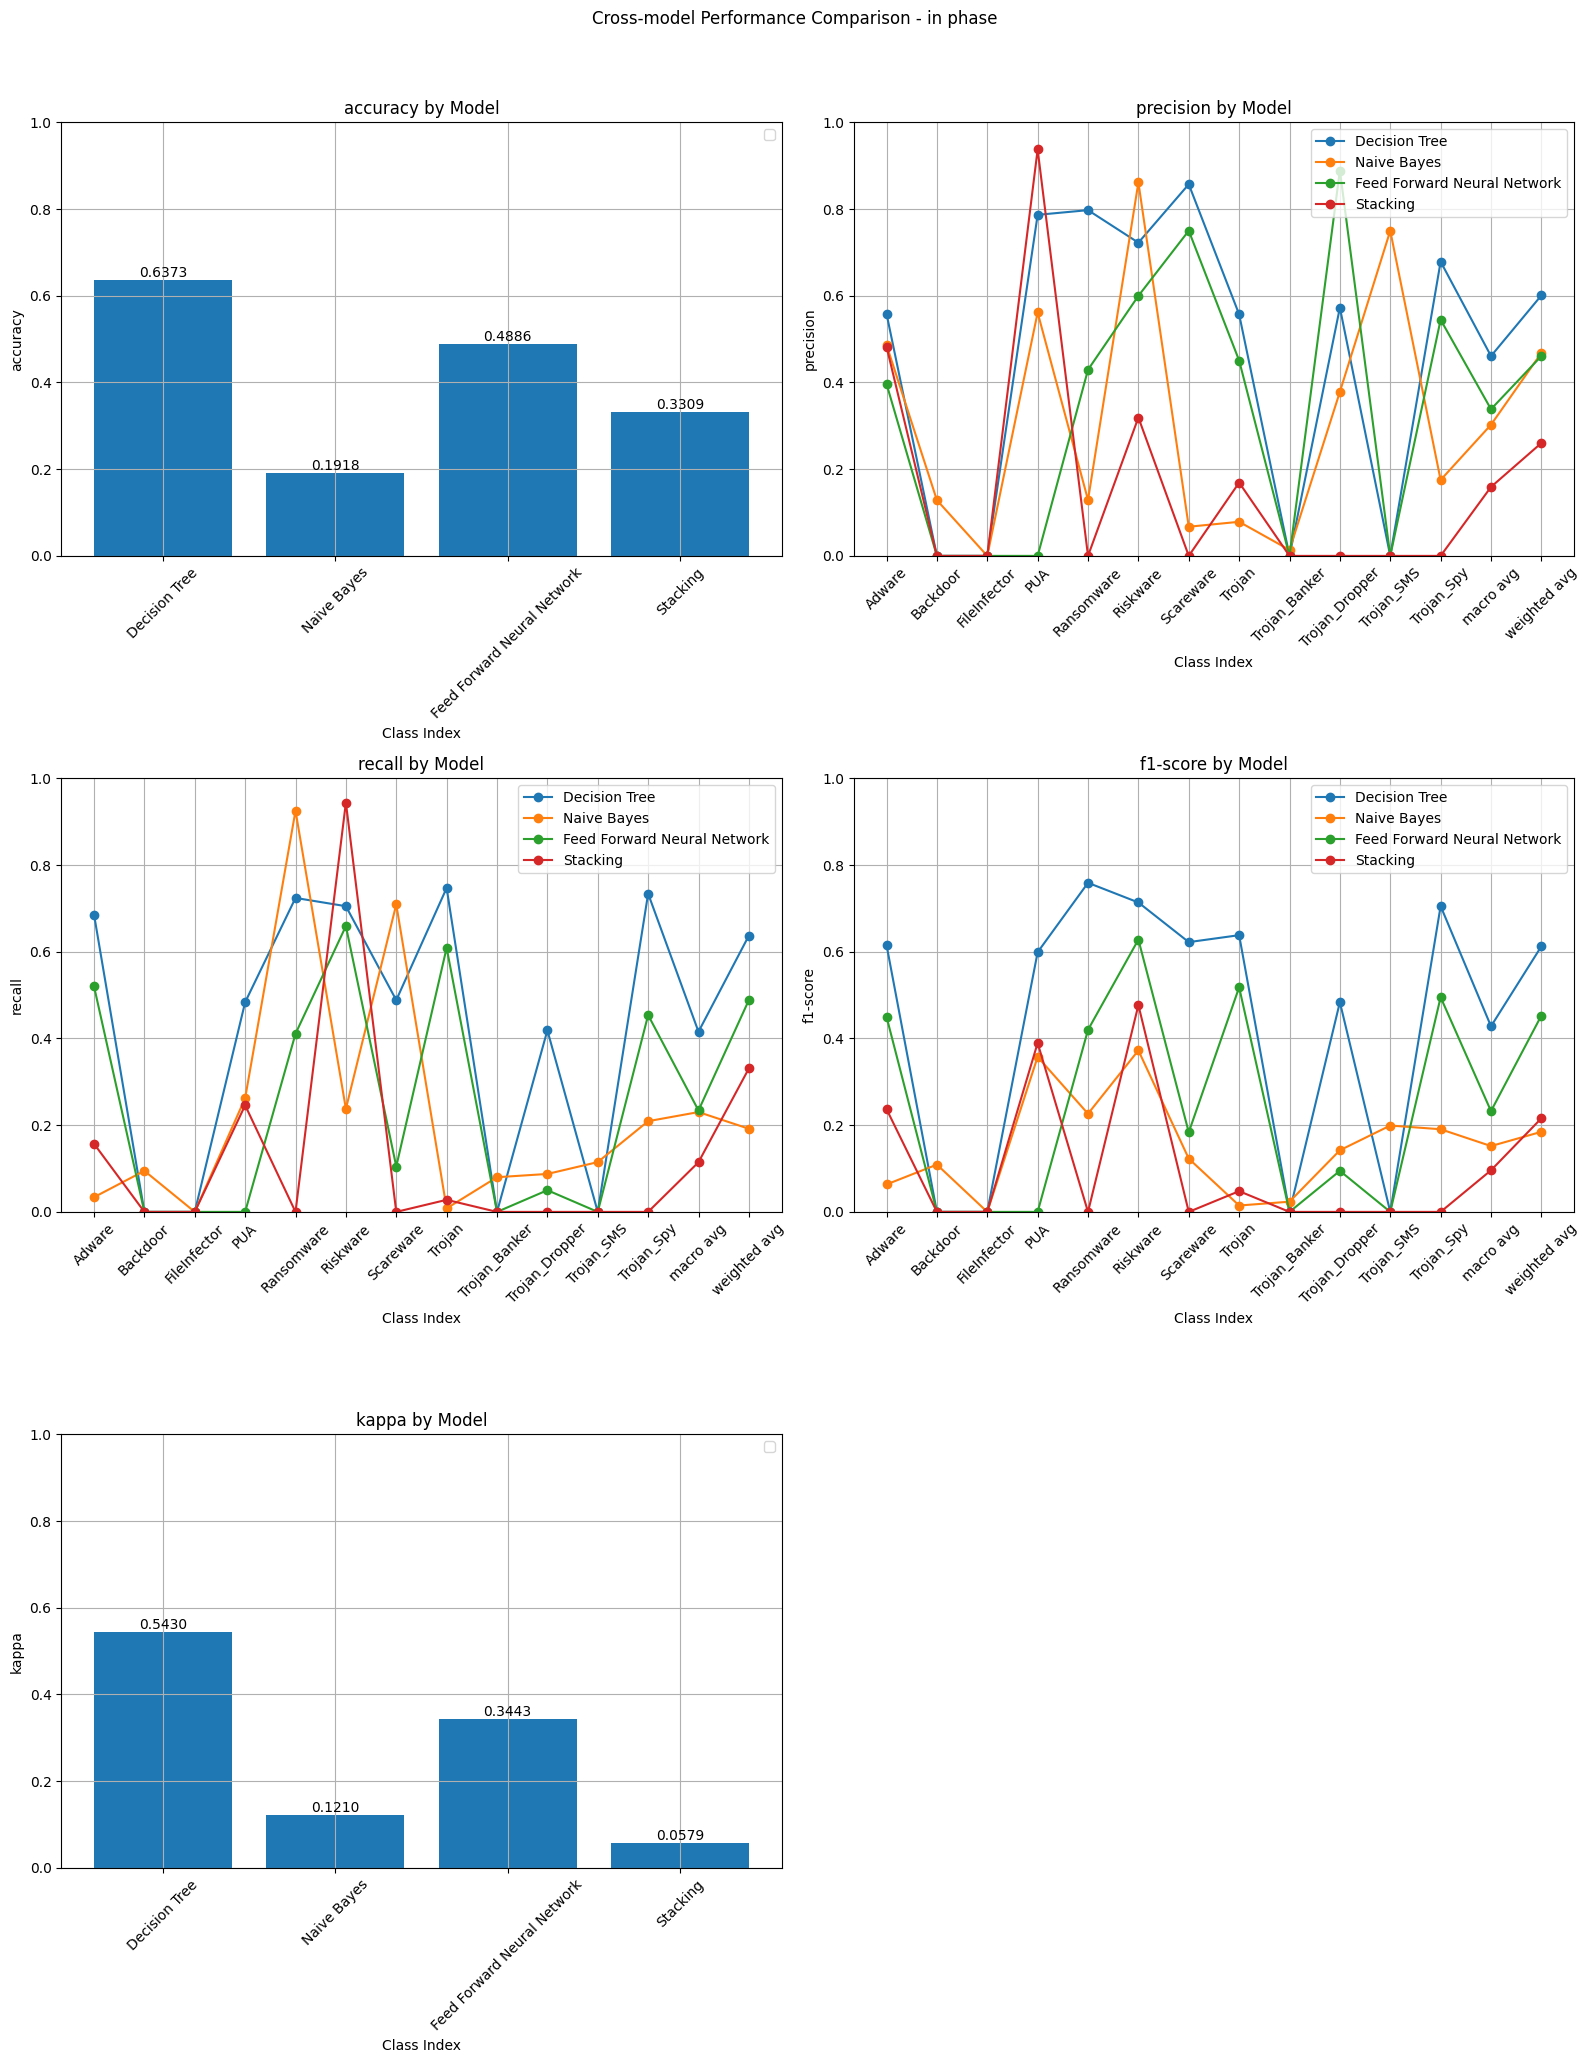

In [95]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(save_plots=False, save_path="")

Metrics df:                                                   id            timeStamp  \
0  243a6598001fa06499ad0568b821fd168ca055810b52aa...  2025-05-10 17:36:15   

                                         comments      modelName currentPhase  \
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME  Decision Tree           in   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.01, 'class_weight': None, 'cri...   7.729023   

   timeToPredict  accuracy_val  accuracy_test  precision_val  precision_test  \
0       0.007952      0.637253             -1       0.600853              -1   

   recall_val  recall_test  f1-score_val  f1-score_test  kappa_val  kappa_test  
0    0.637253           -1      0.612552             -1   0.542965          -1  


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


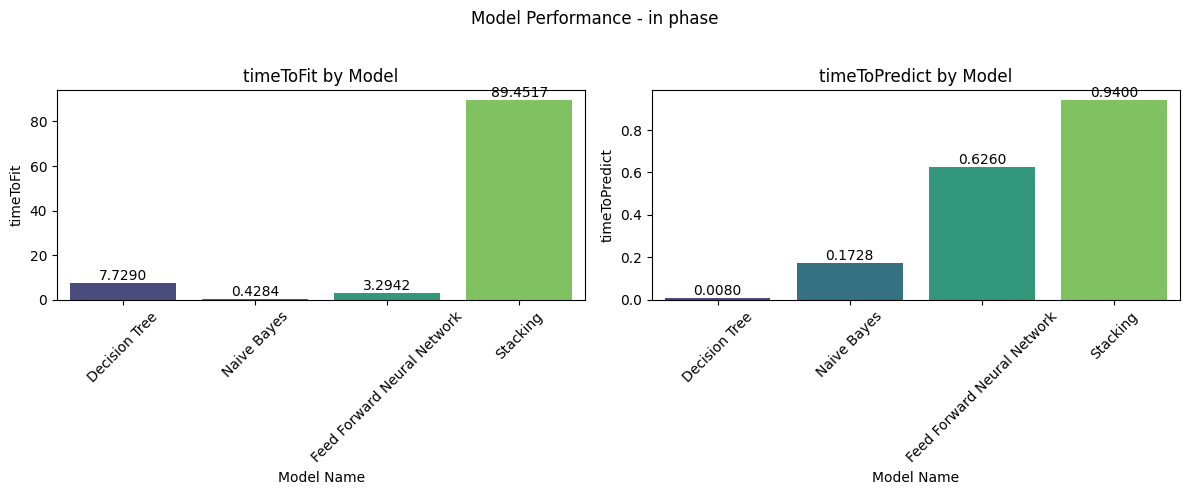

id            timeStamp  \
0  243a6598001fa06499ad0568b821fd168ca055810b52aa...  2025-05-10 17:36:15   
0  e2250069c6cae278a344d419d5b5696f2eae4cf26e21f9...  2025-05-10 17:36:15   
0  37bccda89ba05aeb33922c08f53eea01e34816826f5905...  2025-05-10 17:36:08   
0  0780855ecb8235dc797bab5a61b018312434c27684041b...  2025-05-10 17:36:16   

                                         comments  \
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME   
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME   
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME   
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME   

                     modelName currentPhase  \
0                Decision Tree           in   
0                  Naive Bayes           in   
0  Feed Forward Neural Network           in   
0                     Stacking           in   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.01, 'class_weight': None, 'cri...   7.729023   
0  {'priors': None, 'var_smoothing': 2.8881766539...   0.428440   
0  {'num_features': 142, 'num_classes': 12, 'batc...   3.294156   
0  {'cv': 5, 'estimators': [('Feed Forward Neural...  89.451695   

   timeToPredict  accuracy_val  accuracy_test  precision_val  precision_test  \
0       0.007952      0.637253             -1       0.600853              -1   
0       0.172761      0.191792             -1       0.468110              -1   
0       0.626004      0.488624             -1       0.460971              -1   
0       0.939974      0.330853             -1       0.260346              -1   

   recall_val  recall_test  f1-score_val  f1-score_test  kappa_val  kappa_test  
0    0.637253           -1      0.612552             -1   0.542965          -1  
0    0.191792           -1      0.184725             -1   0.121007          -1  
0    0.488624           -1      0.452858             -1   0.344305          -1  
0    0.330853           -1      0.215875             -1   0.057864          -1

In [96]:
pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"], save_plots=False, save_path="")
# Note I still have not added a way to extract the fitting time from the in-tuning phase

### Results Summary Visualization

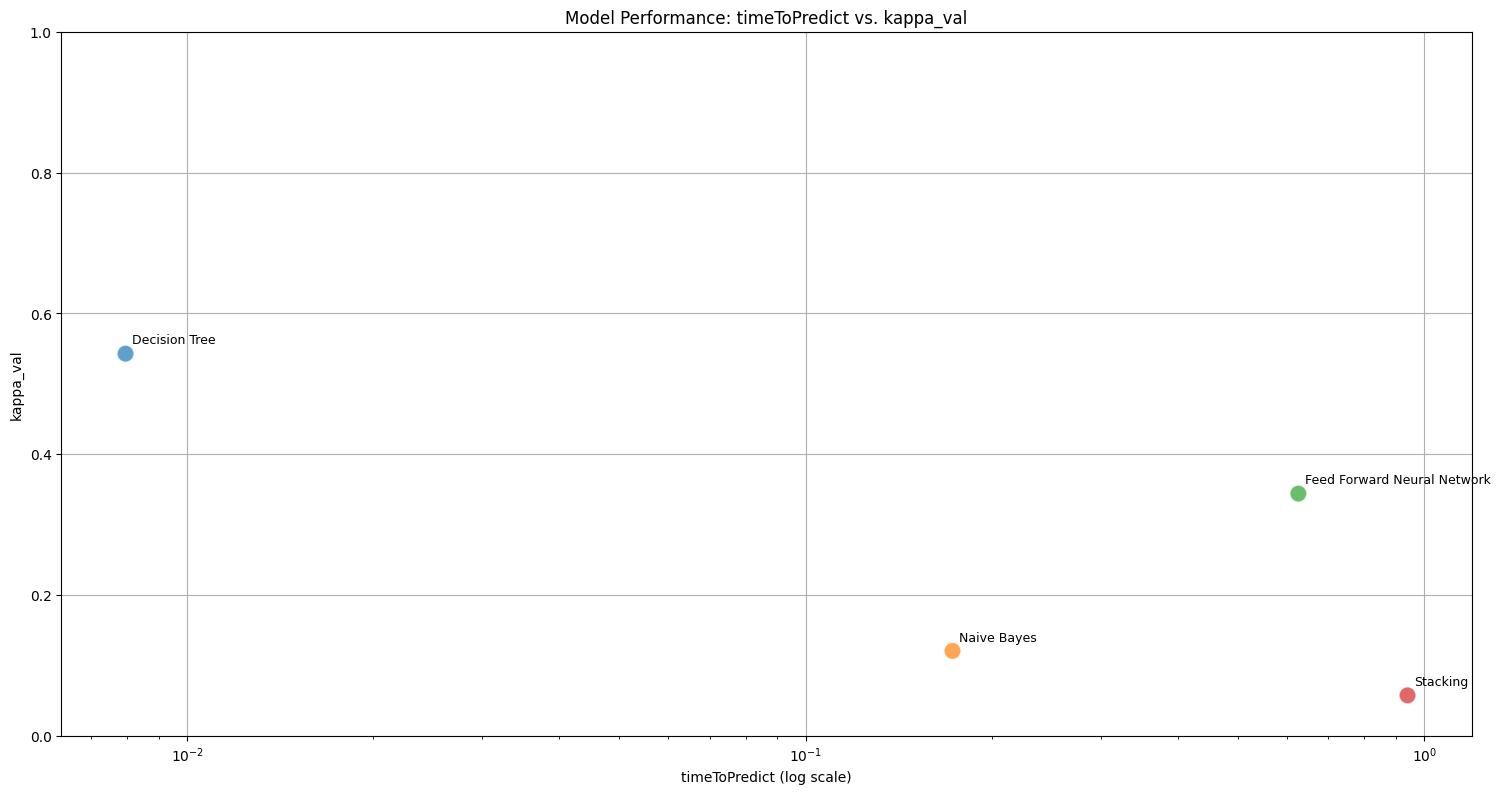

In [97]:
pipeline_manager.pipelines_analysis.plot_results_summary(training_metric="timeToPredict", performance_metric="kappa", save_plots=False, save_path="")

### Intra-model Evaluation (in-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

** EVALUATE HERE THE NOT OPTIMIZED VERSION TOO **

METRICS IS None


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(

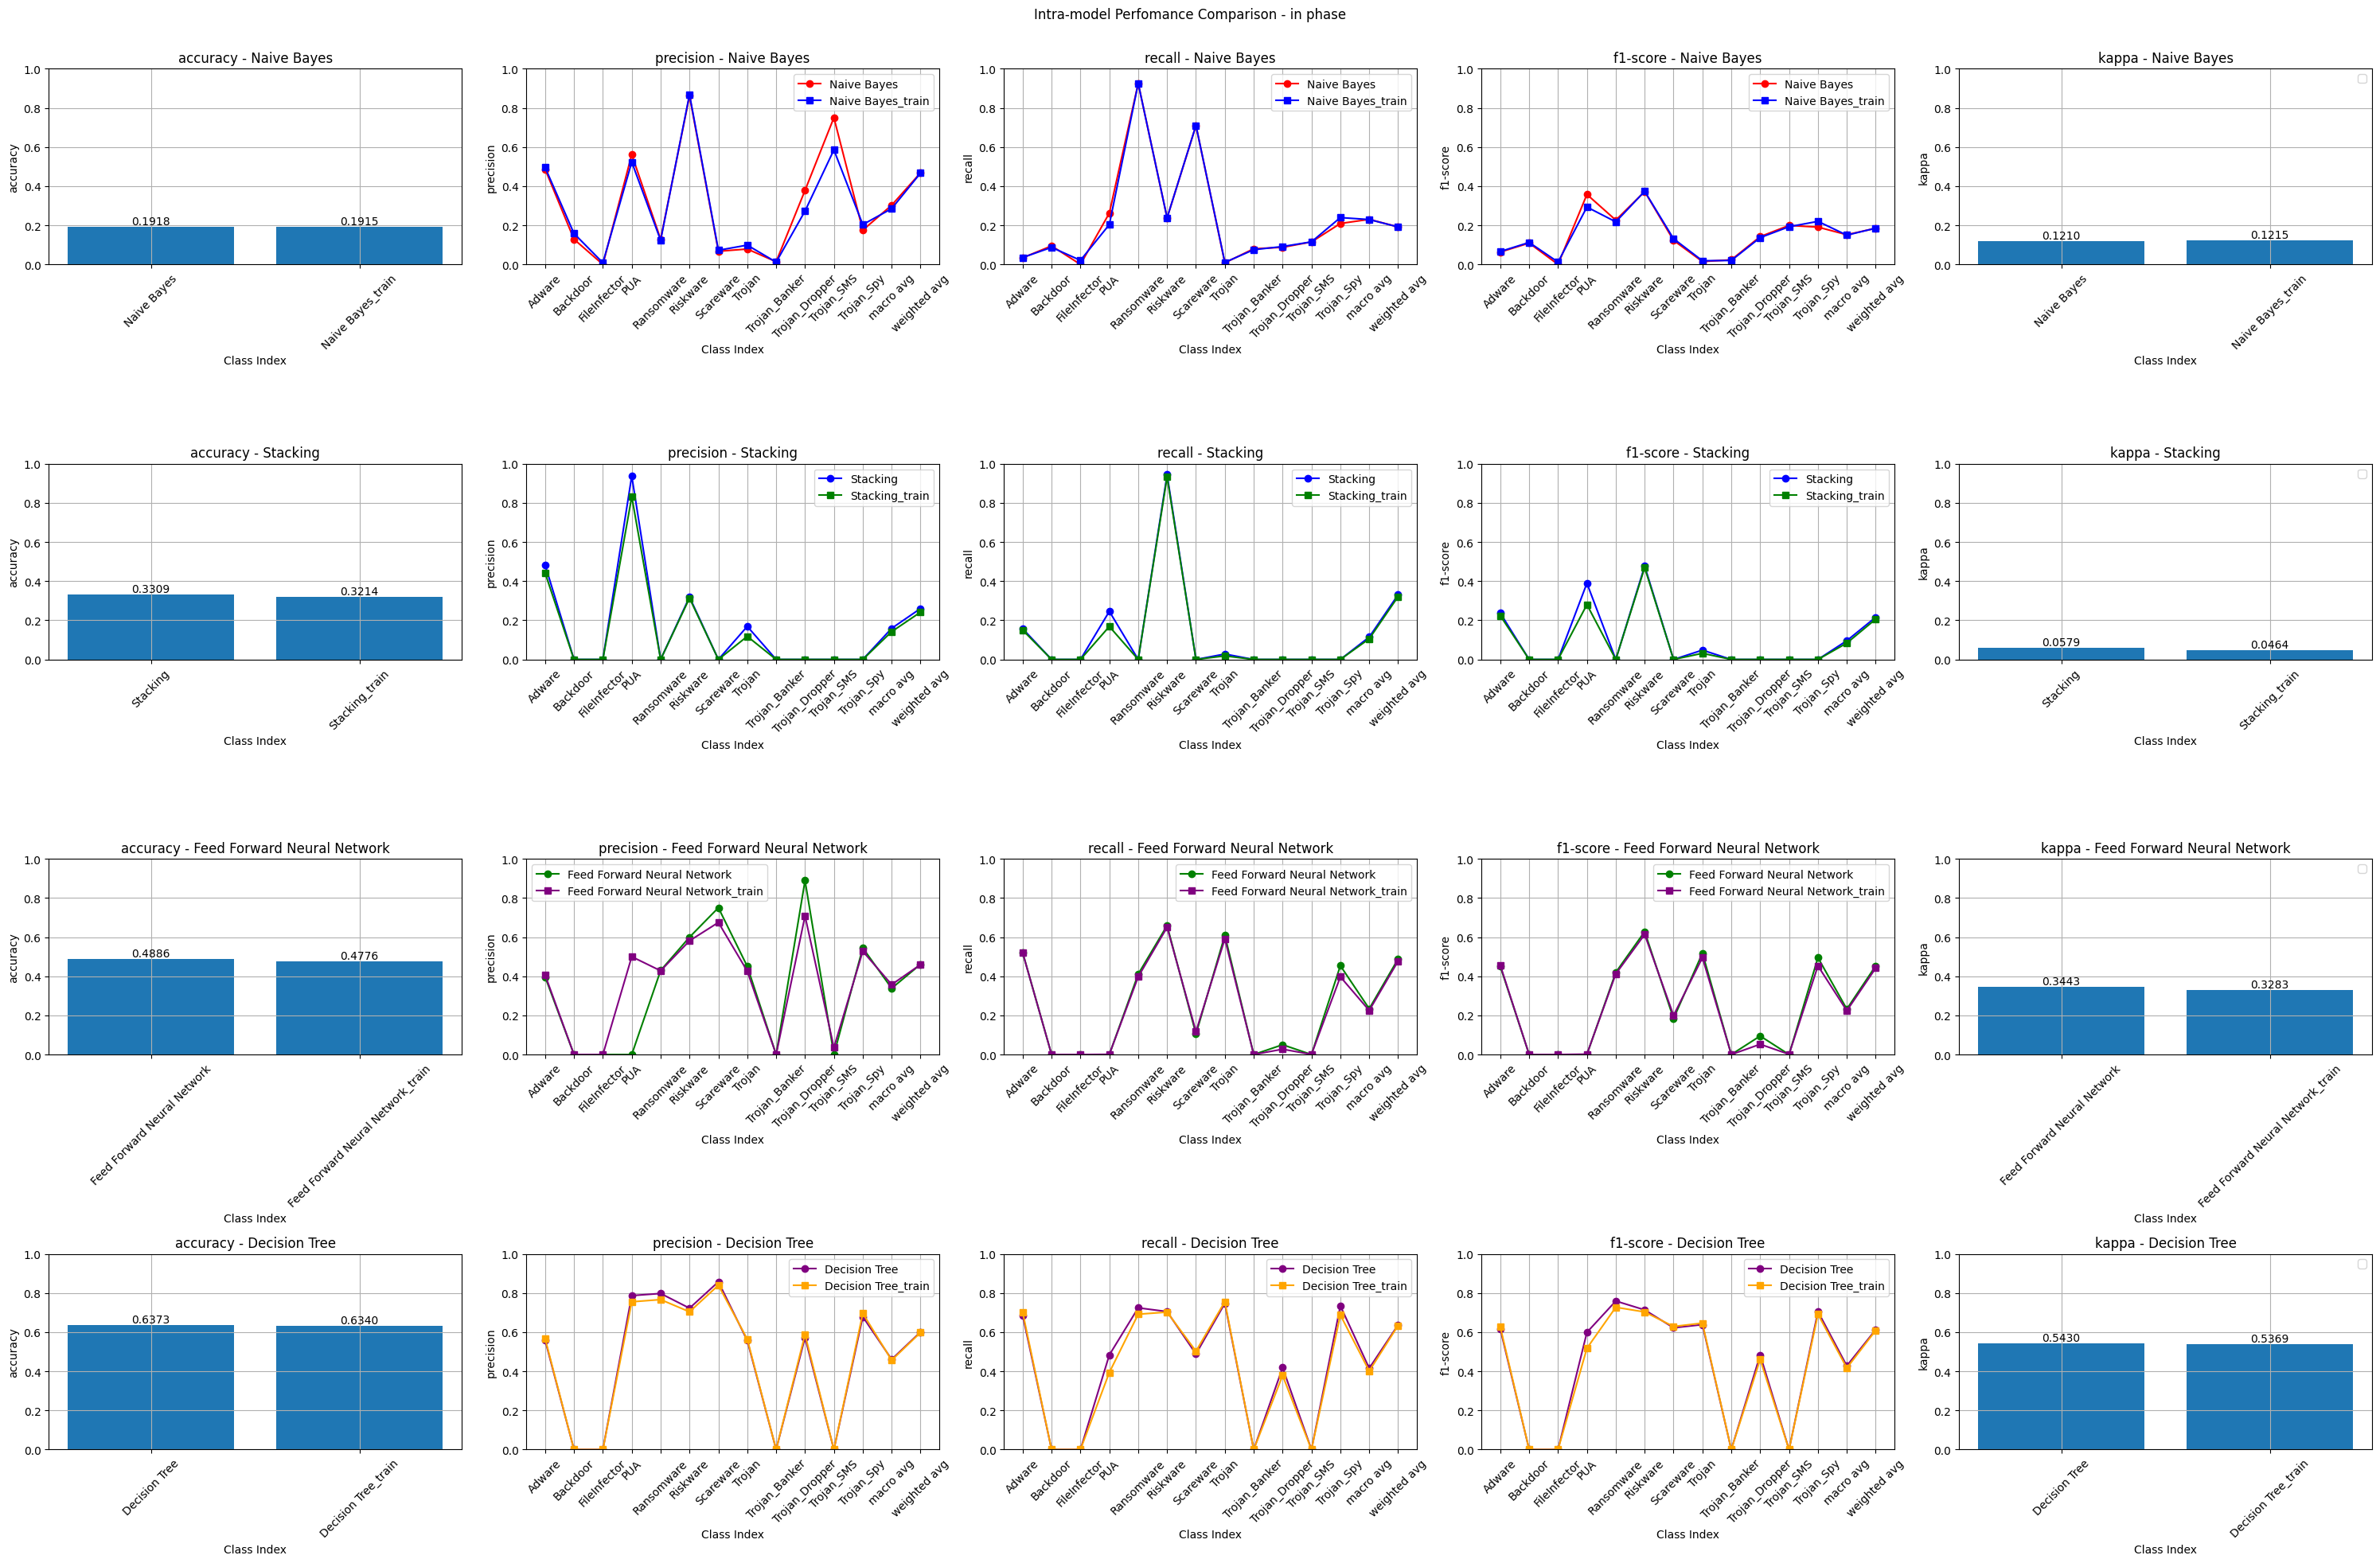

In [98]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(save_plots=False, save_path="")

Unfortunately, keras does not store the per-epoch data when doing Bayesian hyperparemter optimization

In [99]:
#pipeline_manager.pipelines_analysis.plot_per_epoch_progress(metrics=["accuracy", "loss"])

### Residual analysis (in-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Decision Tree
Plotting: Naive Bayes
Plotting: Feed Forward Neural Network
Plotting: Stacking


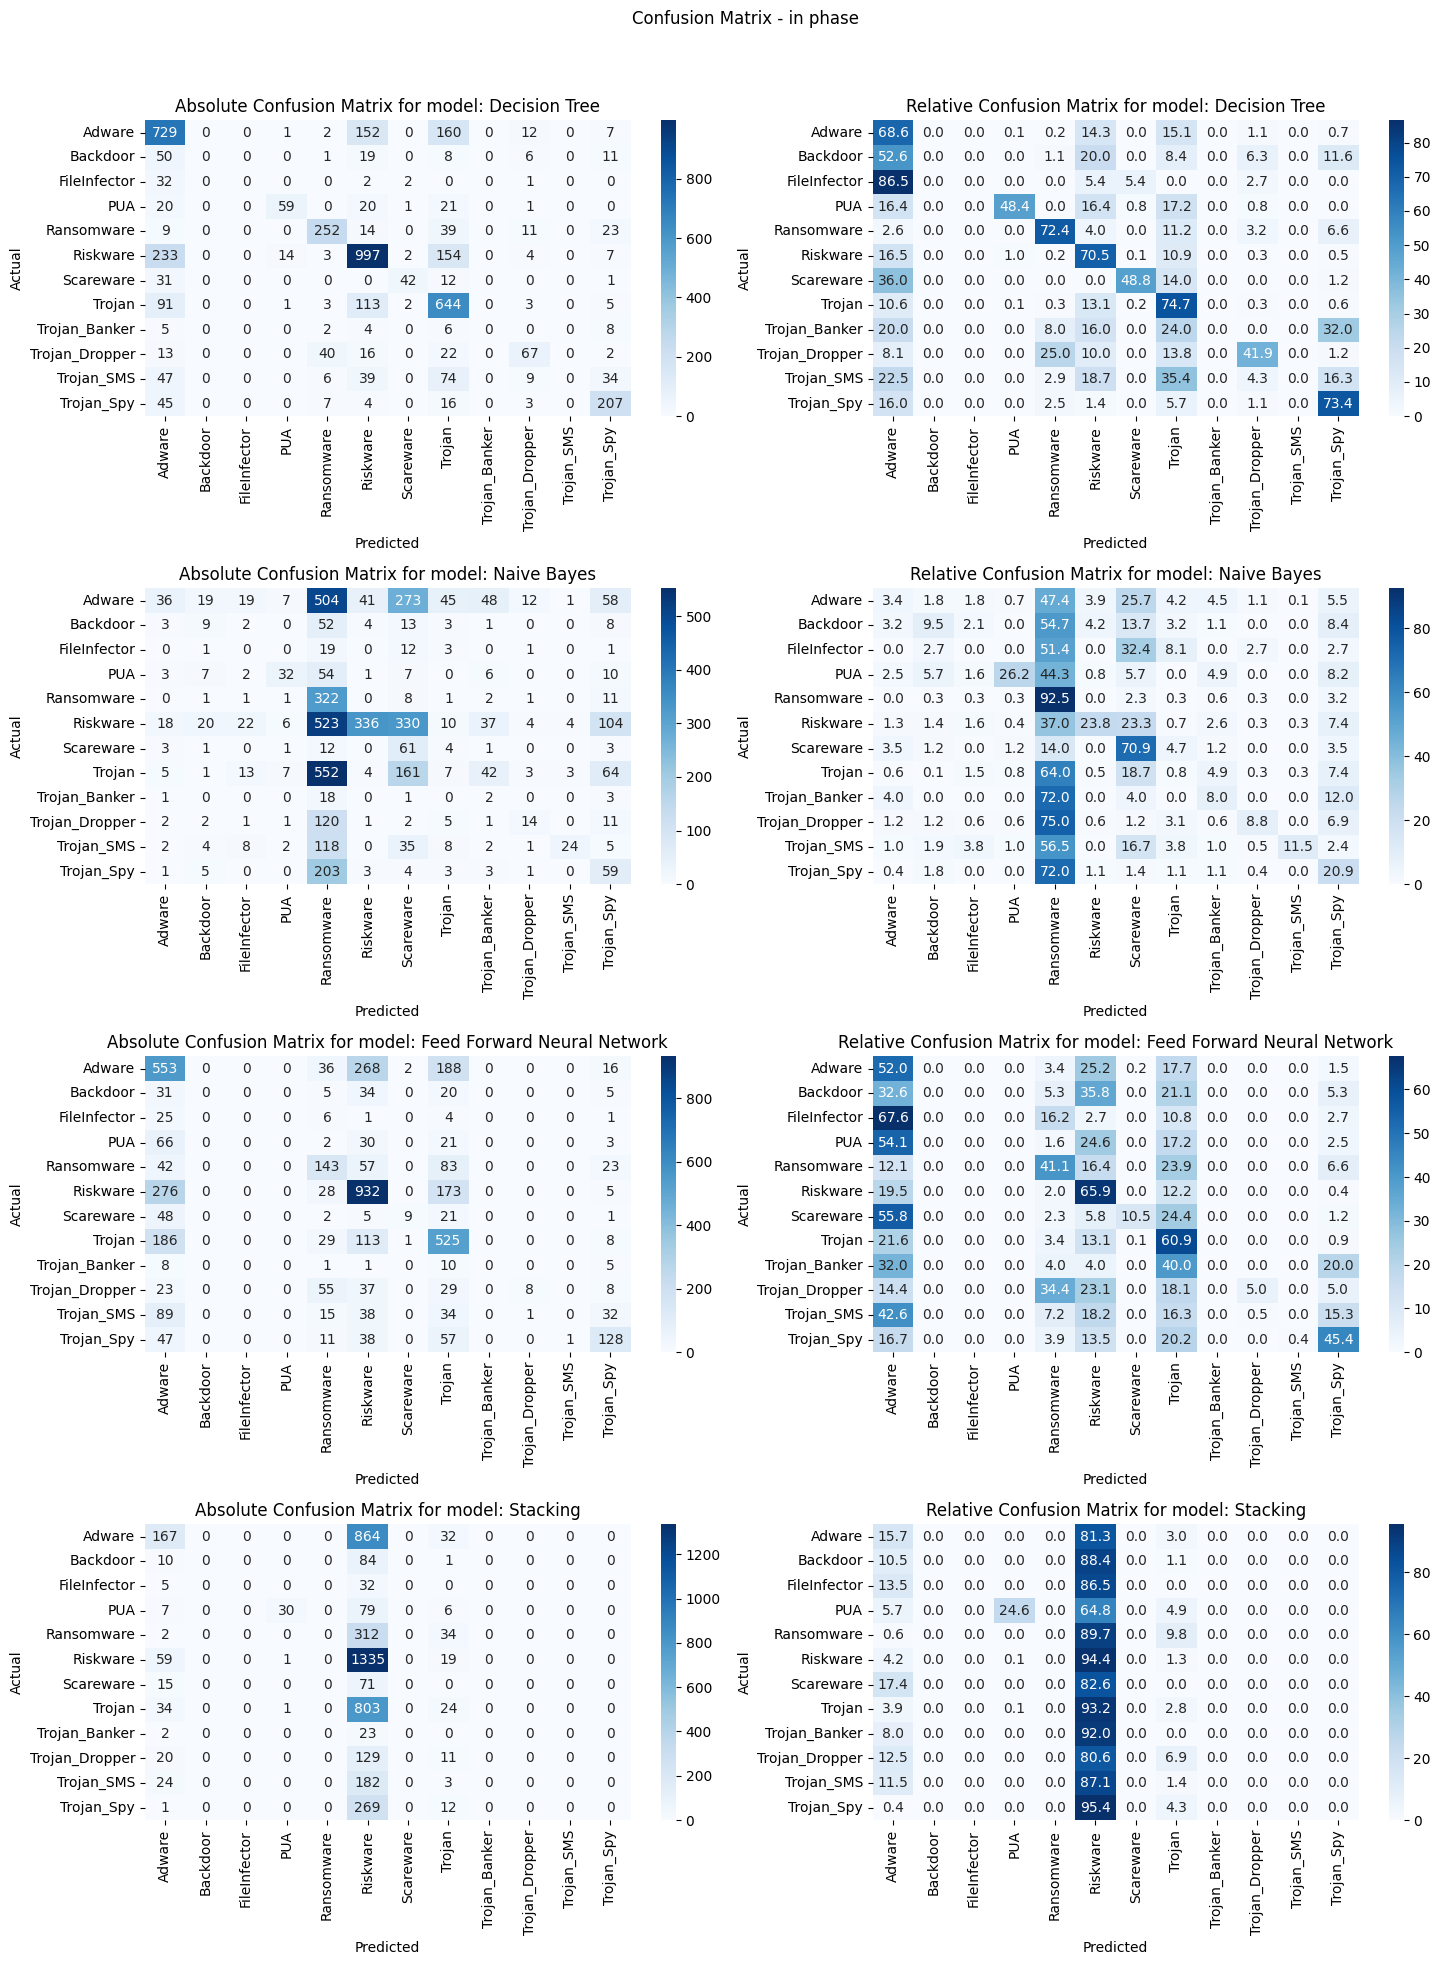

{'tree_based': 53099     3
 11712     0
 52498     3
 41946    10
 2662      0
          ..
 1005     10
 36413     5
 17232     9
 33099     7
 36519     5
 Length: 1706, dtype: int64,
 'naive_bayes': 53099    3
 30660    7
 24323    5
 11712    0
 52498    3
         ..
 44394    7
 7212     0
 7612     0
 46313    7
 36519    5
 Length: 3801, dtype: int64,
 'feed_forward_neural_network': 53099     3
 52498     3
 46186     7
 41946    10
 38536     5
          ..
 17232     9
 52857     3
 47610     7
 7612      0
 36519     5
 Length: 2405, dtype: int64,
 'stacking': 53099     3
 30660     7
 11712     0
 52498     3
 42114    11
          ..
 47610     7
 44394     7
 7212      0
 7612      0
 46313     7
 Length: 3147, dtype: int64}

In [100]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix(save_plots=False, save_path="")
residuals

## Optimizer Covergance
Before we proceed, note that you can access the optimizser object (grid, random or bayes) as per shown in the following example. You may see more detailed information on the tuning process there. For now, we limit ourselves to solely plot the convergence map of the bayes optimizer

Questions:
- what can further be analyzed from this process in order to get better insights?

In [101]:
pipeline_manager.pipelines["not_baseline"]["ensembled"].modelling.list_of_models["Random Forest"].tuning_states["in"].assesment # just an example

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Random Forest',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': None}

In [102]:
#pipeline_manager.all_pipelines_execute(methodName="modelling.plot_convergence")

In [103]:
pipeline_manager.pipelines["baseline"]["baselines"].modelling.list_of_models["Majority Class (baseline)"].tuning_states["post"].assesment # just an example

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Majority Class (baseline)',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': None}

In [104]:
pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models["Feed Forward Neural Network"].tuning_states["post"].assesment # just an example


{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Feed Forward Neural Network',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': FeedForwardNeuralNetwork(activations=['tanh', 'tanh', 'tanh', 'tanh'],
                          batch_size=128, epochs=1,
                          kernel_initializer='glorot_uniform',
                          learning_rate=0.00012757332121604654, n_layers=4,
                          num_classes=12, num_features=142,
                          units_per_layer=[128, 128, 256, 64])}

In [105]:
pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models["Feed Forward Neural Network"].tuning_states["post"].assesment # just an example

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Feed Forward Neural Network',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': FeedForwardNeuralNetwork(activations=['tanh', 'tanh', 'tanh', 'tanh'],
                          batch_size=128, epochs=1,
                          kernel_initializer='glorot_uniform',
                          learning_rate=0.00012757332121604654, n_layers=4,
                          num_classes=12, num_features=142,
                          units_per_layer=[128, 128, 256, 64])}

# Post-tuning Evaluation
Lets start off by selecting the best perfoming model

In [106]:
best_model, best_score = pipeline_manager.select_best_performing_model(metric="f1-score")

Best performing model: Decision Tree with f1-score 0.6126


In [107]:
pipeline_manager.fit_final_models()

Gonna start fitting models in post phase
=> Fitting Decision Tree model
Sklearn model: DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=30,
                       min_samples_leaf=5, min_samples_split=5)
!> Started fitting Decision Tree
X_train_combined: (42328, 142)
Lenght of X_data: 42328
		 => Fitted Decision Tree. Took 1.6952228546142578 seconds
=> Predicting Decision Tree model
!> Started predicting Decision Tree
		 => Predicted Decision Tree. Took 0.009786844253540039 seconds
Fitted and predicted model Decision Tree


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Gonna start fitting models in post phase
=> Fitting Majority Class (baseline) model
Sklearn model: MajorityClassClassifier()
!> Started fitting Majority Class (baseline)
X_train_combined: (42328, 142)
Lenght of X_data: 42328
		 => Fitted Majority Class (baseline). Took 0.0123748779296875 seconds
=> Predicting Majority Class (baseline) model
!> Started predicting Majority Class (baseline)
		 => Predicted Majority Class (baseline). Took 7.486343383789062e-05 seconds
Fitted and predicted model Majority Class (baseline)


In [108]:
pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models["Feed Forward Neural Network"].tuning_states["post"].assesment

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Feed Forward Neural Network',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': FeedForwardNeuralNetwork(activations=['tanh', 'tanh', 'tanh', 'tanh'],
                          batch_size=128, epochs=1,
                          kernel_initializer='glorot_uniform',
                          learning_rate=0.00012757332121604654, n_layers=4,
                          num_classes=12, num_features=142,
                          units_per_layer=[128, 128, 256, 64])}

In [109]:
pipeline_manager.evaluate_store_final_models()

Evaluating model Decision Tree
Evaluating Decision Tree in post phase
METRIC RESULTS FOR Decision Tree => F1: 0.6131239537118284, Precision: 0.6238891387196049, Recall: 0.6343537414965986, Accuracy: 0.6343537414965986, Kappa: 0.535538758060095 (val), 0.5390467012500681 (train)


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

METADATA IS: {'id': None, 'timeStamp': None, 'comments': None, 'modelName': 'Decision Tree', 'currentPhase': None, 'features_used': None, 'hyperParameters': None, 'timeToFit': 1.6952228546142578, 'timeToPredict': 0.009786844253540039, 'accuracy': None, 'precision': None, 'recall': None, 'f1-score': None, 'kappa': None, 'predictions_val': None, 'predictions_train': array([0, 0, 5, ..., 0, 7, 7]), 'predictions_test': array([ 5,  9,  0, ...,  5, 11,  0]), 'model_sklearn': DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=30,
                       min_samples_leaf=5, min_samples_split=5), 'metrics': {'base_metrics': {'accuracy': 0.6343537414965986, 'precision': 0.6238891387196049, 'recall': 0.6343537414965986, 'f1-score': 0.6131239537118284}, 'additional_metrics': {'not_train': {'kappa': np.float64(0.535538758060095)}, 'train': {'kappa_train': np.float64(0.5390467012500681)}}}}
COL IS: accuracy
COL IS: precision
COL IS: recall
COL IS: f1-score
COL IS: kappa
Evaluating 

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

METADATA IS: {'id': None, 'timeStamp': None, 'comments': None, 'modelName': 'Majority Class (baseline)', 'currentPhase': None, 'features_used': None, 'hyperParameters': None, 'timeToFit': 0.0123748779296875, 'timeToPredict': 7.486343383789062e-05, 'accuracy': None, 'precision': None, 'recall': None, 'f1-score': None, 'kappa': None, 'predictions_val': None, 'predictions_train': [np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64

### Metric Evaluation

In [110]:
pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models["Feed Forward Neural Network"].tuning_states["post"].assesment

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Feed Forward Neural Network',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': FeedForwardNeuralNetwork(activations=['tanh', 'tanh', 'tanh', 'tanh'],
                          batch_size=128, epochs=1,
                          kernel_initializer='glorot_uniform',
                          learning_rate=0.00012757332121604654, n_layers=4,
                          num_classes=12, num_features=142,
                          units_per_layer=[128, 128, 256, 64])}

In [111]:
pipeline_manager.pipeline_state = "post"

### Cross-Model Evaluation (post-tuning)

In [112]:
class_report_df = pipeline_manager.pipelines_analysis._compute_classification_report(include_training=True)
class_report_df

precision         recall       f1-score        support  \
Adware               0.528381       0.698148       0.601516         1080.0   
Backdoor                  0.0            0.0            0.0          113.0   
FileInfector              0.0            0.0            0.0           20.0   
PUA                  0.707865         0.5625       0.626866          112.0   
Ransomware           0.640091       0.769863       0.699005          365.0   
Riskware             0.668308       0.766408       0.714004         1417.0   
Scareware                0.86       0.467391       0.605634           92.0   
Trojan               0.699176       0.609581       0.651312          835.0   
Trojan_Banker             0.0            0.0            0.0           30.0   
Trojan_Dropper       0.696203       0.337423       0.454545          163.0   
Trojan_SMS           0.619048       0.122066       0.203922          213.0   
Trojan_Spy           0.742222       0.632576       0.683027          264.0   
macro avg            0.513441        0.41383       0.436652         4704.0   
weighted avg         0.623889       0.634354       0.613124         4704.0   
modelName       Decision Tree  Decision Tree  Decision Tree  Decision Tree   

                     accuracy          kappa            precision  \
Adware               0.634354       0.535539             0.538614   
Backdoor             0.634354       0.535539                  0.0   
FileInfector         0.634354       0.535539                  0.0   
PUA                  0.634354       0.535539             0.664865   
Ransomware           0.634354       0.535539             0.637595   
Riskware             0.634354       0.535539             0.664959   
Scareware            0.634354       0.535539             0.841438   
Trojan               0.634354       0.535539              0.69627   
Trojan_Banker        0.634354       0.535539                  0.0   
Trojan_Dropper       0.634354       0.535539             0.788732   
Trojan_SMS           0.634354       0.535539             0.590551   
Trojan_Spy           0.634354       0.535539              0.76297   
macro avg            0.634354       0.535539             0.515499   
weighted avg         0.634354       0.535539             0.626432   
modelName       Decision Tree  Decision Tree  Decision Tree_train   

                             recall             f1-score              support  \
Adware                     0.712222              0.61337               9900.0   
Backdoor                        0.0                  0.0               1024.0   
FileInfector                    0.0                  0.0                228.0   
PUA                        0.417657             0.513034               1178.0   
Ransomware                 0.772817             0.698724               3046.0   
Riskware                   0.749842             0.704854              12636.0   
Scareware                  0.501259             0.628256                794.0   
Trojan                     0.618785             0.655244               7602.0   
Trojan_Banker                   0.0                  0.0                211.0   
Trojan_Dropper              0.39801             0.529051               1407.0   
Trojan_SMS                 0.130359             0.213574               1726.0   
Trojan_Spy                 0.662267             0.709061               2576.0   
macro avg                  0.413602             0.438764              42328.0   
weighted avg               0.637049             0.617348              42328.0   
modelName       Decision Tree_train  Decision Tree_train  Decision Tree_train   

                ...                   f1-score                    support  \
Adware          ...                        0.0                     1080.0   
Backdoor        ...                        0.0                      113.0   
FileInfector    ...                        0.0                       20.0   
PUA             ...                        0.0               

PLOTTING CROSS MODEL COMPARISON FOR post PHASE
Plotting: accuracy
Plotting: precision
Plotting: recall
Plotting: f1-score
Plotting: kappa


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:197: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:197: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


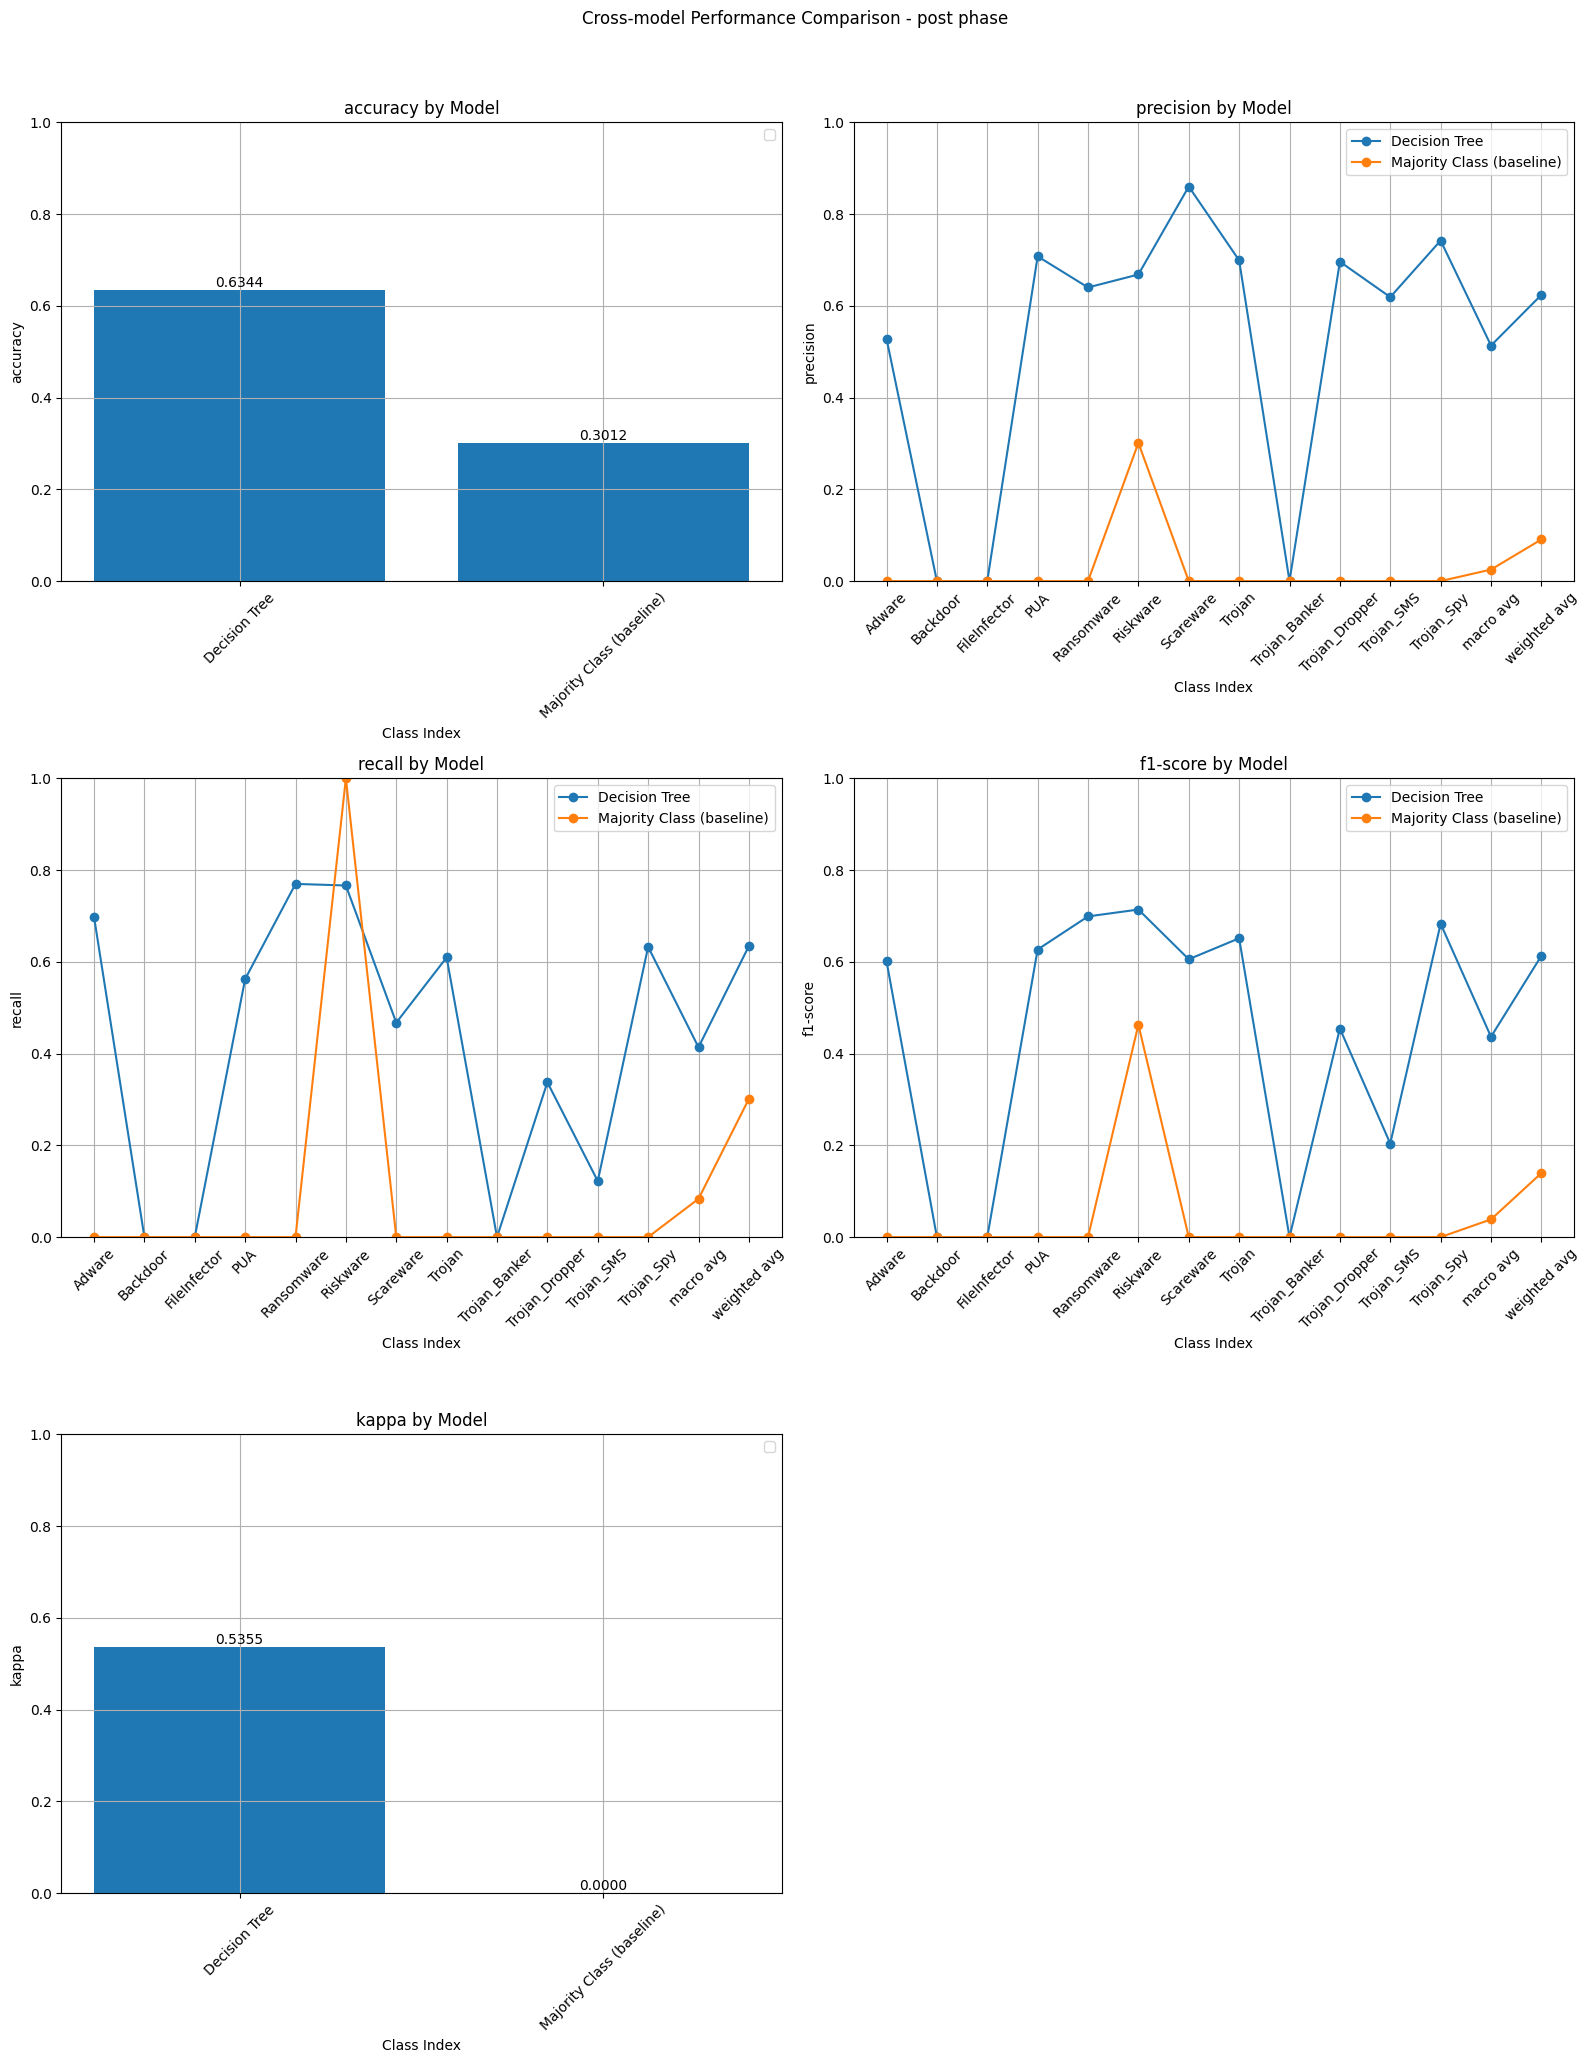

In [113]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(save_plots=False, save_path="")

Metrics df:                                                   id            timeStamp  \
0  6fb5192ce0863bf0c7e6ea8ea204629a92df20dd83b605...  2025-05-10 17:36:35   

                                         comments      modelName currentPhase  \
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME  Decision Tree         post   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.01, 'class_weight': None, 'cri...   1.695223   

   timeToPredict  accuracy_test  accuracy_val  precision_test  precision_val  \
0       0.009787       0.634354            -1        0.623889             -1   

   recall_test  recall_val  f1-score_test  f1-score_val  kappa_test  kappa_val  
0     0.634354          -1       0.613124            -1    0.539047         -1  


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


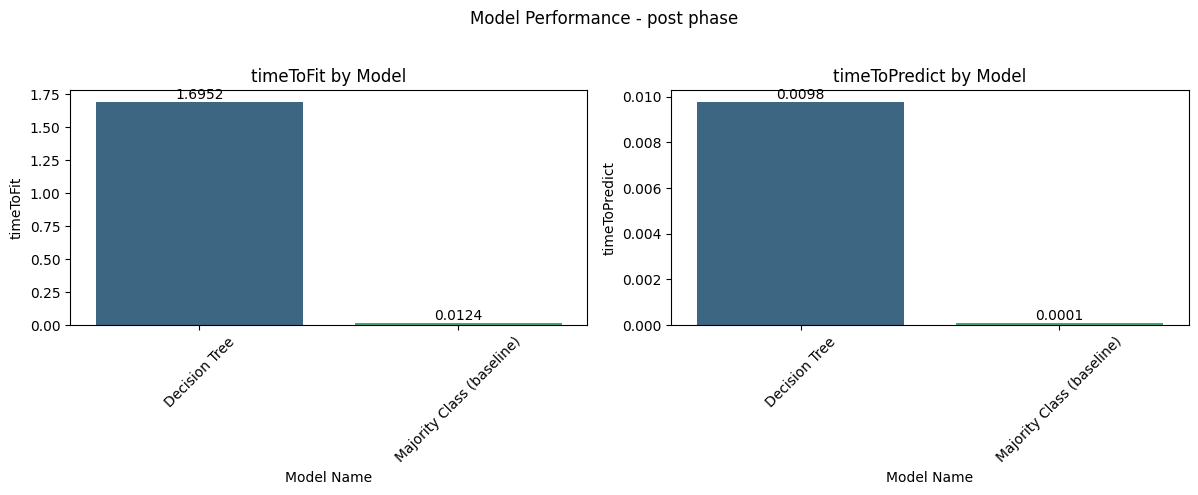

id            timeStamp  \
0  6fb5192ce0863bf0c7e6ea8ea204629a92df20dd83b605...  2025-05-10 17:36:35   
0  e8049b3117f069a3bf6fcc7cd8b302f34aaf5264c0da28...  2025-05-10 17:36:39   

                                         comments                  modelName  \
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME              Decision Tree   
0  UPDATED KAPPA NAME IN THE CSV, ONE SECOND TIME  Majority Class (baseline)   

  currentPhase                                      features_used  \
0         post  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0         post  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.01, 'class_weight': None, 'cri...   1.695223   
0                                                 {}   0.012375   

   timeToPredict  accuracy_test  accuracy_val  precision_test  precision_val  \
0       0.009787       0.634354            -1        0.623889             -1   
0       0.000075       0.301233            -1        0.090741             -1   

   recall_test  recall_val  f1-score_test  f1-score_val  kappa_test  kappa_val  
0     0.634354          -1       0.613124            -1    0.539047         -1  
0     0.301233          -1       0.139470            -1    0.000000         -1

In [114]:
pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"], save_plots=False, save_path="")

### Results Summary Visualization

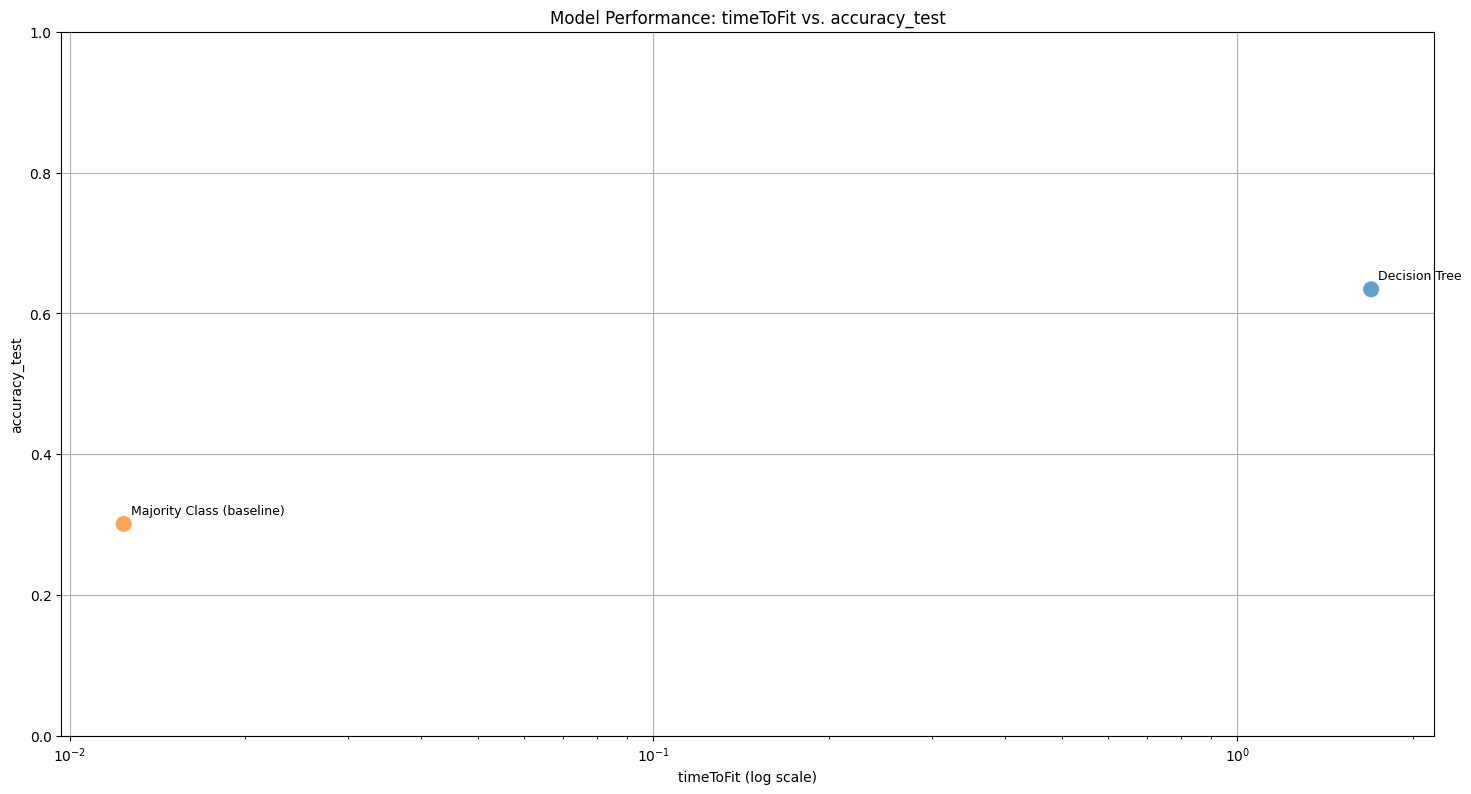

In [115]:
pipeline_manager.pipelines_analysis.plot_results_summary(training_metric="timeToFit", performance_metric="accuracy", save_plots=False, save_path="")

### Intra-model Evaluation (post-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

METRICS IS None


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:258: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


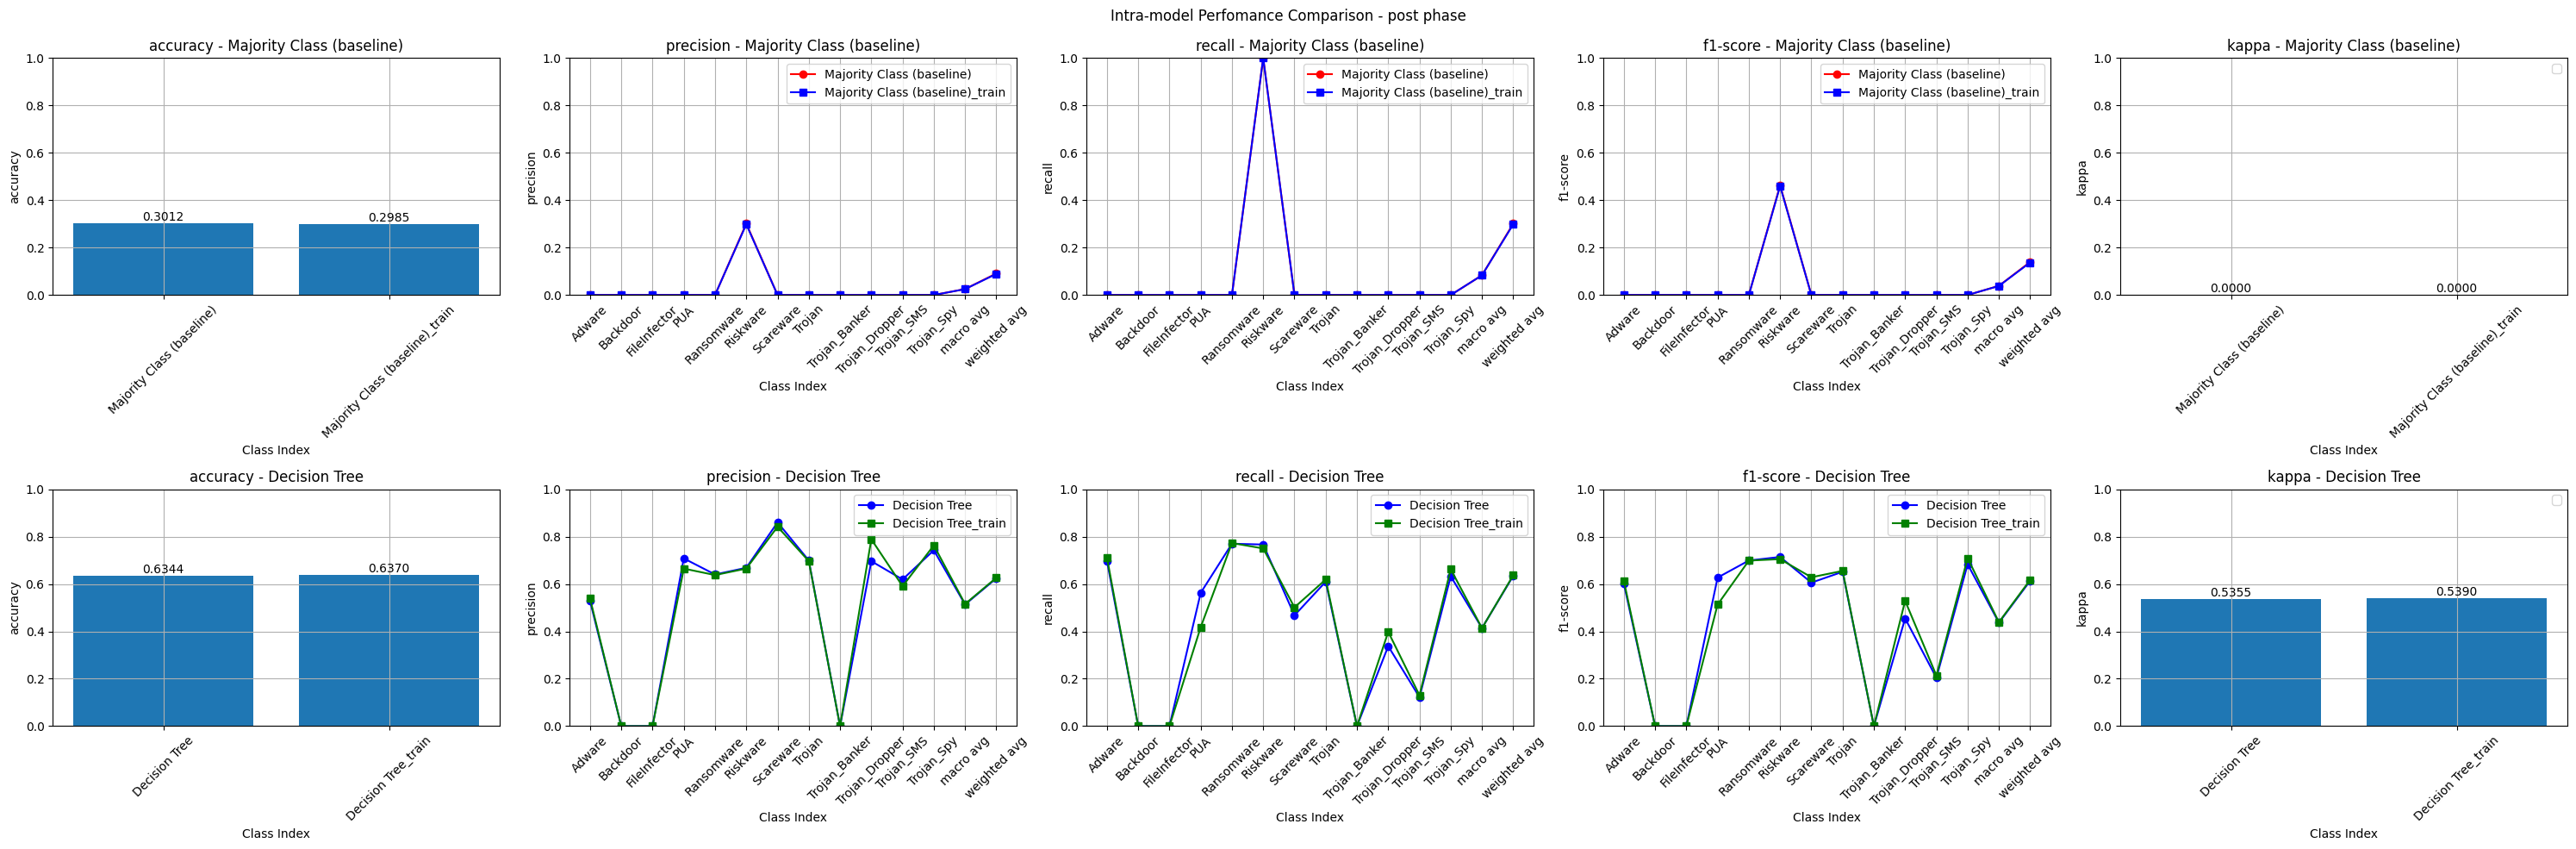

In [116]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(save_plots=False, save_path="")


Lets see the progress of the NN

In [117]:
#pipeline_manager.pipelines_analysis.plot_per_epoch_progress(metrics=["accuracy", "loss"])

### Residual analysis (post-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Decision Tree
Plotting: Majority Class (baseline)


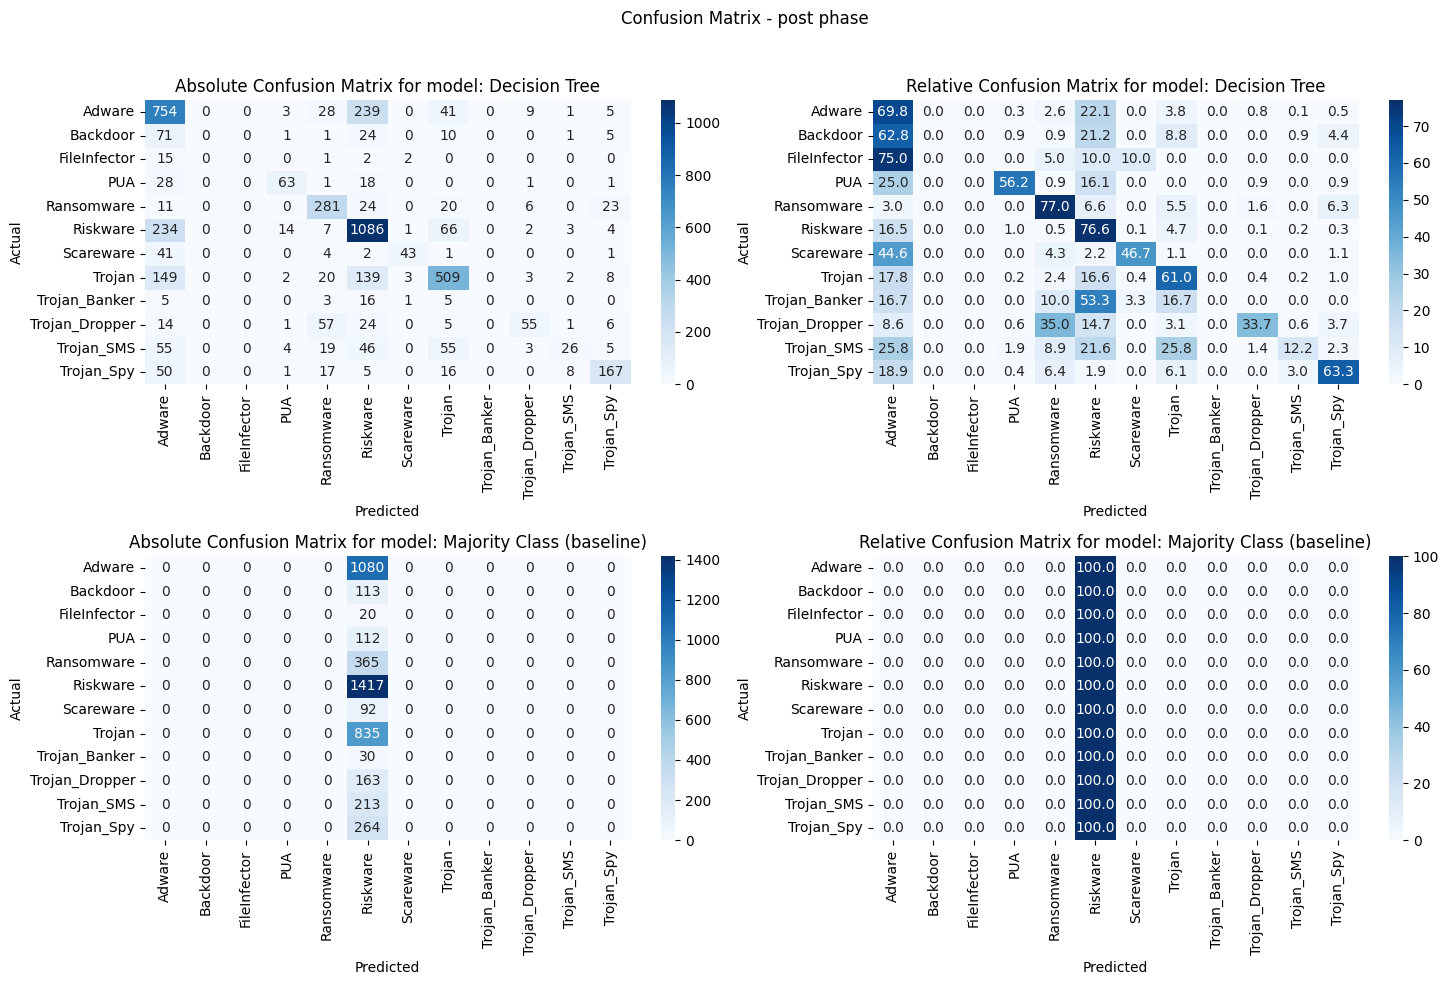

{'tree_based': 155      10
 40893     5
 5338      0
 34312     2
 19104     5
          ..
 32942     7
 15442     1
 10913     0
 32109     7
 36199     5
 Length: 1720, dtype: int64,
 'baselines': 15929     9
 8975      0
 155      10
 51708    11
 1482      6
          ..
 10913     0
 52384     3
 32109     7
 42424    11
 5520      0
 Length: 3287, dtype: int64}

In [118]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix(save_plots=False, save_path="")
residuals

In [119]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["post"].assesment

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Stacking',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'kappa': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': StackingClassifier(cv=5,
                    estimators=[('Feed Forward Neural Network',
                                 FeedForwardNeuralNetwork(activations=['tanh',
                                                                       'tanh',
                                                                       'tanh',
                                                                       'tanh'],
                                                          batch_size=128,
                                                          epochs=1,
                                                          kernel_in

## Saving Best Model

In [120]:
#pipeline_manager.serialize_models(models_to_serialize=["Majority Class (baseline)"])

In [121]:
#pipeline_manager.serialize_pipelines(pipelines_to_serialize=["naive-bayes"])